In [6]:
import numpy as np
import scipy.linalg as sl
from enterprise.signals import (gp_signals, parameter, signal_base, utils,
                                white_signals)
from hasasia import sensitivity as hasens
import healpy as hp
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
import time

import multiprocessing as mp
def chisq(x, k):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, k, nc):
    return stats.ncx2.pdf(x, k, nc, loc=0, scale=1)

def make_Mmat(toas):
    DesignM = np.ones((len(toas), 3))
    DesignM[:,1] = toas
    DesignM[:,2] = DesignM[:,1]**2
    return DesignM

def nc_chisq_fixedk_coh(x, nc):
    return stats.ncx2.pdf(x, 2, nc, loc=0, scale=1)

def nc_chisq_fixedk_incoh(x, nc):
    return stats.ncx2.pdf(x, 40, nc, loc=0, scale=1)

# Rmtx only for WN
# def make_Rmat(toas):
#     I = np.identity(len(toas))
#     DesignM = make_Mmat(toas)
#     return I - np.einsum('kn,nm,pm->kp', DesignM, np.linalg.inv(np.einsum('km,kn->nm',DesignM,DesignM)),DesignM)

def make_Rmat(toas, ninv):
    I = np.identity(len(toas))
    DesignM = make_Mmat(toas)
    return I - np.einsum('kn,nm,mp,pq->kq', DesignM, np.linalg.inv(np.einsum('ij,jk,kl->il',DesignM.T,ninv,DesignM)),DesignM.T, ninv)

def make_Rmat_wn(toas):
    I = np.identity(len(toas))
    DesignM = make_Mmat(toas)
    return I - np.einsum('kn,nm,pm->kp', DesignM, np.linalg.inv(np.einsum('km,kn->nm',DesignM,DesignM)),DesignM)

def inner_prod(x,y,C):
    return (x.T@C)@y


import pta_replicator as ptr
from pta_replicator import sim as ptrsim

def create_rn_timseries(base_toas, amplitude, gamma, components=30):

    Tspan = max(base_toas) - min(base_toas)
    YR_IN_SEC = 3600*24*365.25
    fyr = 1/YR_IN_SEC
    F, freqs = ptrsim.createfourierdesignmatrix_red(base_toas, nmodes=components)
    prior = amplitude**2 * (freqs/fyr)**(-gamma) / (12 * np.pi**2 * Tspan) * YR_IN_SEC**3

    y = np.sqrt(prior) * np.random.randn(freqs.size)
    rn_timeseries = np.dot(F, y)
    return rn_timeseries

def compute_redpsd(amp, gamma, freqs):
    psd = np.zeros(len(freqs))
    Tspan = 1/freqs[0]
    YR_IN_SEC = 3600*24*365.25
    fyr = 1/YR_IN_SEC
    for freq_idx, freq in enumerate(freqs):
        psd[freq_idx] = amp**2 * (freq/fyr)**(-gamma) / (12 * np.pi**2) * YR_IN_SEC**3
    return psd

In [159]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 18,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 12,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath,calrsfs}', r'\DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}'],
        'text.usetex':True,
        'figure.figsize': figsize(1.2)}

plt.rcParams.update(params)

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [8]:
def bwm_delay(toas, pos, log10_h=-14.0, cos_gwtheta=0.0, gwphi=0.0, gwpol=0.0, t0=55000*24*3600,
              antenna_pattern_fn=None):
    """
    Function that calculates the earth-term gravitational-wave
    burst-with-memory signal, as described in:
    Seto et al, van haasteren and Levin, phsirkov et al, Cordes and Jenet.
    This version uses the F+/Fx polarization modes, as verified with the
    Continuous Wave and Anisotropy papers.

    :param toas: Time-of-arrival measurements [s]
    :param pos: Unit vector from Earth to pulsar
    :param log10_h: log10 of GW strain
    :param cos_gwtheta: Cosine of GW polar angle
    :param gwphi: GW azimuthal polar angle [rad]
    :param gwpol: GW polarization angle
    :param t0: Burst central time [s]
    :param antenna_pattern_fn:
        User defined function that takes `pos`, `gwtheta`, `gwphi` as
        arguments and returns (fplus, fcross)

    :return: the waveform as induced timing residuals (seconds)
    
    taken from enterprise_extensions
    """

    # convert
    h = 10 ** log10_h
    gwtheta = np.arccos(cos_gwtheta)
    t0 *= 1

    # antenna patterns
    if antenna_pattern_fn is None:
        apc = utils.create_gw_antenna_pattern(pos, gwtheta, gwphi)
    else:
        apc = antenna_pattern_fn(pos, gwtheta, gwphi)

    # grab fplus, fcross
    fp, fc = apc[0], apc[1]

    # combined polarization
    pol = np.cos(2 * gwpol) * fp + np.sin(2 * gwpol) * fc

    # Return the time-series for the pulsar
    return pol * h * np.heaviside(toas - t0, 0.5) * (toas - t0)
    

Instantiate psrlocs

In [9]:
npsrs = 40
# psr_locs = []

# for ipsr in range(npsrs):
#     psr_theta = np.random.rand() * np.pi
#     psr_phi = np.random.rand() * 2 * np.pi

#     psr_locs.append([psr_theta, psr_phi])
    
# np.savetxt('/home/nima/nanograv/bwm_fpfe/production_runs/psrlocs.txt', psr_locs)
psrloc_path = '/home/nima/nanograv/bwm_fpfe/production_runs/psrlocs.txt'

# Easiest attempt 
WN Only

In [10]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)
   

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [15]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        # prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        # prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        prefit_toas = base_toases[ipsr] + wn_series
        prefit_resids = wn_series
        noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        # plt.scatter(prefit_toas, ramp_templates[ipsr], color='tab:blue', label='prefit')
        # plt.scatter(prefit_toas, postfit_template, color='tab:orange', label = 'postfit')
        # plt.legend()
        # plt.title('PSR {} Templates'.format(ipsr))
        # plt.show()
        # plt.close()

        # plt.scatter(prefit_toas, prefit_resids, label='prefit')
        # plt.scatter(prefit_toas, postfit_resids, label='postfit')
        # plt.legend()
        # plt.title('PSR {} resids'.format(ipsr))
        # plt.show()
        # plt.close()
        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc
        
        # compute resids dotted with templates
        
        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        
        # fig, ax = plt.subplots(1,1)
        # ax.scatter(base_toases[ipsr], postfit_resids, color='k')
        # twinax = ax.twinx()
        # twinax.scatter(base_toases[ipsr], Ap, label='Ap', ls = '--', color='red')
        # twinax.scatter(base_toases[ipsr], Ac, label='Ac', ls = '--', color='blue')
        # plt.title('PSR {} [Np = {:.02e}, Nc = {:.02e}]'.format(ipsr, Np_contribution, Nc_contribution))
        # plt.show()
        # plt.close()
        
        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    # Mij_inv = np.linalg.inv(Mij)
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe

In [16]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fes = pool.starmap(fe_worker, args)
 
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn.txt'
np.savetxt(outfile, np.array(Fes))

Finished iteration 1092 in 0.3s. Fe = 2.241568353935321
Finished iteration 168 in 0.5s. Fe = 3.4111853674248334
Finished iteration 588 in 0.5s. Fe = 0.8439255377188469Finished iteration 1176 in 0.6s. Fe = 6.712157218590089Finished iteration 672 in 0.6s. Fe = 1.405051057936716
Finished iteration 840 in 0.6s. Fe = 3.451341592996294


Finished iteration 924 in 0.6s. Fe = 0.42525146207839437
Finished iteration 252 in 0.7s. Fe = 10.791195916180701
Finished iteration 504 in 0.7s. Fe = 0.028296231283650115
Finished iteration 420 in 0.8s. Fe = 5.392997638626496Finished iteration 756 in 0.8s. Fe = 0.22724977776962066

Finished iteration 0 in 0.9s. Fe = 5.03826864148153
Finished iteration 336 in 0.9s. Fe = 2.3407203099615397
Finished iteration 1008 in 1.0s. Fe = 2.2136632921402737
Finished iteration 84 in 1.0s. Fe = 2.447538203949588
Finished iteration 169 in 0.6s. Fe = 5.307228483218458
Finished iteration 673 in 0.5s. Fe = 4.064909842401291
Finished iteration 1093 in 0.8s. Fe = 8.60666255007085

Finished iteration 850 in 0.6s. Fe = 1.3963176714211716
Finished iteration 933 in 0.6s. Fe = 0.07684871259954996
Finished iteration 178 in 0.7s. Fe = 0.8833072126396968Finished iteration 345 in 0.6s. Fe = 0.3567970401712562

Finished iteration 598 in 0.7s. Fe = 1.4347196905836994
Finished iteration 1017 in 0.8s. Fe = 1.9084824314080517Finished iteration 94 in 0.5s. Fe = 1.1402546168691559

Finished iteration 766 in 0.7s. Fe = 1.7393090612172966Finished iteration 429 in 0.8s. Fe = 1.9959870895866807
Finished iteration 262 in 0.7s. Fe = 0.0805578670000215

Finished iteration 1186 in 0.8s. Fe = 3.9474972290277224Finished iteration 682 in 0.8s. Fe = 1.5418700202887856

Finished iteration 10 in 0.7s. Fe = 1.9262876789251164Finished iteration 1102 in 0.8s. Fe = 1.5174079374292162

Finished iteration 934 in 0.7s. Fe = 5.448965306383174Finished iteration 514 in 0.8s. Fe = 0.5091615446755196

Finished iteration 179 in 0.6s. Fe = 5.105311195994176
Finished iteration 851 in 0.8s. Fe = 0.436520027

Finished iteration 1027 in 0.7s. Fe = 0.2505583383050931Finished iteration 438 in 0.6s. Fe = 2.517162129215305

Finished iteration 104 in 0.7s. Fe = 0.9157633047006759Finished iteration 860 in 0.7s. Fe = 0.5447552987325309

Finished iteration 523 in 0.7s. Fe = 3.559119056466027
Finished iteration 272 in 0.6s. Fe = 0.010030059044785192
Finished iteration 19 in 0.6s. Fe = 2.080920468668297
Finished iteration 1195 in 0.8s. Fe = 4.4904261774340695
Finished iteration 188 in 0.7s. Fe = 2.523358486970265
Finished iteration 609 in 0.6s. Fe = 0.11627003692274923Finished iteration 355 in 0.7s. Fe = 4.52457275154491
Finished iteration 943 in 0.6s. Fe = 0.6106038077090643

Finished iteration 692 in 0.6s. Fe = 0.5749549334878699Finished iteration 775 in 0.7s. Fe = 1.6243818173209392

Finished iteration 1112 in 0.6s. Fe = 0.39738209047679535
Finished iteration 439 in 0.7s. Fe = 1.0532375766996047Finished iteration 1028 in 0.7s. Fe = 0.22328663175306257Finished iteration 105 in 0.7s. Fe = 0.837351166

Finished iteration 784 in 0.8s. Fe = 7.9709931902310025Finished iteration 700 in 0.6s. Fe = 11.222237363678747
Finished iteration 1204 in 0.5s. Fe = 0.3513280868257123

Finished iteration 198 in 0.4s. Fe = 0.39383885794895557Finished iteration 364 in 0.7s. Fe = 1.5558097288959352
Finished iteration 114 in 0.7s. Fe = 3.04238697910491

Finished iteration 533 in 0.8s. Fe = 0.8145892010976911Finished iteration 29 in 0.5s. Fe = 0.5077069616313814

Finished iteration 870 in 0.7s. Fe = 0.32017683222196747
Finished iteration 282 in 0.8s. Fe = 0.33222217788195346Finished iteration 1037 in 0.8s. Fe = 1.3401556506077477Finished iteration 619 in 0.7s. Fe = 1.4741483265729942
Finished iteration 449 in 0.7s. Fe = 0.8479198192953361


Finished iteration 701 in 0.5s. Fe = 2.999247777397384Finished iteration 1205 in 0.5s. Fe = 0.38380790447464086

Finished iteration 1122 in 0.7s. Fe = 0.17571140594783294Finished iteration 953 in 0.8s. Fe = 0.7716899258222198

Finished iteration 785 in 0.8s. Fe = 1.1784

Finished iteration 123 in 0.7s. Fe = 2.7803624184338176
Finished iteration 710 in 0.5s. Fe = 1.2776308300046904
Finished iteration 1131 in 0.8s. Fe = 0.4172743416112362
Finished iteration 38 in 0.9s. Fe = 1.5272339222523876Finished iteration 543 in 0.6s. Fe = 0.3115984930417656Finished iteration 794 in 0.7s. Fe = 2.0695265870000408


Finished iteration 1047 in 0.8s. Fe = 2.598239819196816
Finished iteration 629 in 0.9s. Fe = 0.352868330715253
Finished iteration 374 in 0.7s. Fe = 2.088310440248624
Finished iteration 208 in 0.7s. Fe = 2.647622774521969
Finished iteration 1216 in 0.7s. Fe = 0.05738720709243911Finished iteration 962 in 0.7s. Fe = 0.7268853884908848Finished iteration 458 in 0.7s. Fe = 2.0392123775385773
Finished iteration 291 in 0.9s. Fe = 0.16146834929025397


Finished iteration 880 in 0.9s. Fe = 2.3686635432646623
Finished iteration 711 in 0.6s. Fe = 5.718463206104512Finished iteration 124 in 0.7s. Fe = 2.801343623266457

Finished iteration 1132 in 0.6s. Fe = 5.0923409694

Finished iteration 133 in 0.7s. Fe = 6.738871088293293
Finished iteration 804 in 0.7s. Fe = 6.772640194038191Finished iteration 971 in 0.8s. Fe = 2.245017843164364

Finished iteration 467 in 0.7s. Fe = 6.732170353269204
Finished iteration 1142 in 0.7s. Fe = 2.043129940941187
Finished iteration 1226 in 0.4s. Fe = 2.083993471788442Finished iteration 554 in 0.4s. Fe = 2.415082237524116Finished iteration 888 in 0.8s. Fe = 0.33724202620645394

Finished iteration 719 in 0.7s. Fe = 1.7895879631211835

Finished iteration 1057 in 0.8s. Fe = 0.5938932656250602Finished iteration 639 in 0.7s. Fe = 2.141356522111756Finished iteration 300 in 0.8s. Fe = 4.359261697368608


Finished iteration 48 in 0.7s. Fe = 2.1467142928377108
Finished iteration 384 in 0.8s. Fe = 1.5763195135090242
Finished iteration 134 in 0.7s. Fe = 4.000900687702995
Finished iteration 805 in 0.7s. Fe = 0.31734692916091983Finished iteration 555 in 0.4s. Fe = 4.290454504559405
Finished iteration 218 in 0.9s. Fe = 1.8497244669469695


Finished iteration 476 in 0.7s. Fe = 5.400948868048893
Finished iteration 1235 in 0.7s. Fe = 3.7921627269519282
Finished iteration 1152 in 0.6s. Fe = 6.830311251689957
Finished iteration 143 in 0.7s. Fe = 1.489702502330574Finished iteration 980 in 0.6s. Fe = 3.285765174546698Finished iteration 57 in 0.6s. Fe = 1.558768910964243


Finished iteration 309 in 0.7s. Fe = 0.23754324284195497
Finished iteration 897 in 0.8s. Fe = 0.22406265329617717
Finished iteration 649 in 0.7s. Fe = 0.8192868160246716
Finished iteration 814 in 0.7s. Fe = 0.7799774578269456
Finished iteration 228 in 0.5s. Fe = 1.0322388090903276
Finished iteration 1067 in 0.7s. Fe = 0.8087686267771701Finished iteration 728 in 0.8s. Fe = 10.751051735463236
Finished iteration 566 in 0.5s. Fe = 1.0456557965751236

Finished iteration 395 in 0.6s. Fe = 4.3968372372488105
Finished iteration 477 in 0.6s. Fe = 1.3989554113767637
Finished iteration 1153 in 0.6s. Fe = 0.3138170380170904
Finished iteration 144 in 0.6s. Fe = 0.735524989

Finished iteration 318 in 0.7s. Fe = 8.64836347188941Finished iteration 823 in 0.6s. Fe = 0.2815682538860952Finished iteration 236 in 0.7s. Fe = 2.9557093841913136

Finished iteration 737 in 0.8s. Fe = 2.897846152166798
Finished iteration 405 in 0.7s. Fe = 1.5894169658579218
Finished iteration 906 in 0.8s. Fe = 3.571437104464723

Finished iteration 575 in 0.8s. Fe = 3.265574834708594
Finished iteration 1076 in 0.7s. Fe = 1.4696111405992016Finished iteration 990 in 0.8s. Fe = 1.304113056320282
Finished iteration 660 in 0.6s. Fe = 2.313112531286595

Finished iteration 319 in 0.4s. Fe = 2.5484893737267065Finished iteration 1162 in 0.6s. Fe = 5.230252203428862
Finished iteration 1245 in 0.6s. Fe = 2.249011955144997

Finished iteration 154 in 0.6s. Fe = 0.027825260116457633Finished iteration 486 in 0.8s. Fe = 1.8361782705558334
Finished iteration 69 in 0.7s. Fe = 1.342976021079473

Finished iteration 237 in 0.6s. Fe = 4.778855086131215
Finished iteration 907 in 0.5s. Fe = 1.1704008042101066

Finished iteration 415 in 0.8s. Fe = 1.220784964028103
Finished iteration 999 in 0.7s. Fe = 2.1830029478319872
Finished iteration 163 in 0.7s. Fe = 0.416064320199072
Finished iteration 832 in 0.9s. Fe = 2.413944785225408
Finished iteration 747 in 0.6s. Fe = 1.446500175839748
Finished iteration 584 in 0.8s. Fe = 1.2966029327190531Finished iteration 916 in 0.6s. Fe = 2.0420926443226928

Finished iteration 1172 in 0.7s. Fe = 1.3739168772873525
Finished iteration 495 in 0.7s. Fe = 0.5594536475478676
Finished iteration 78 in 0.7s. Fe = 0.9713032762710367
Finished iteration 1086 in 0.8s. Fe = 5.368459572281569Finished iteration 247 in 0.6s. Fe = 0.41627820776469177
Finished iteration 1255 in 0.7s. Fe = 0.19579414399234185Finished iteration 164 in 0.5s. Fe = 10.90273914084226


Finished iteration 670 in 0.7s. Fe = 0.3047107749585962Finished iteration 416 in 0.7s. Fe = 1.1855951792153625Finished iteration 329 in 0.8s. Fe = 3.3256514361960217


Finished iteration 833 in 0.5s. Fe = 2.89688290714

Finished iteration 2185 in 0.8s. Fe = 1.1554716619564382
Finished iteration 1517 in 0.6s. Fe = 0.1360975597550629
Finished iteration 2018 in 0.6s. Fe = 0.48209749826417825
Finished iteration 2352 in 0.8s. Fe = 0.9572858051655618
Finished iteration 1686 in 0.7s. Fe = 0.2724134770591131
Finished iteration 1852 in 0.8s. Fe = 1.8556494315260055
Finished iteration 1768 in 0.8s. Fe = 0.32678123079119686Finished iteration 2436 in 0.7s. Fe = 0.4908034807518924

Finished iteration 1435 in 0.5s. Fe = 1.0463580038971274Finished iteration 1935 in 0.7s. Fe = 0.1580927286276584Finished iteration 1267 in 0.8s. Fe = 1.291619244483227Finished iteration 1601 in 0.8s. Fe = 0.210014918576634


Finished iteration 1350 in 0.7s. Fe = 0.26746722949571994

Finished iteration 2269 in 0.6s. Fe = 6.868945995026183
Finished iteration 2102 in 0.8s. Fe = 0.7097994355135115
Finished iteration 2186 in 0.8s. Fe = 0.24570587920489506
Finished iteration 1936 in 0.4s. Fe = 2.1289577030996965Finished iteration 2019 in 0.7s

Finished iteration 1776 in 0.8s. Fe = 1.0618753790108793Finished iteration 2361 in 0.8s. Fe = 2.6677037084653374

Finished iteration 2445 in 0.8s. Fe = 3.7266020170815755
Finished iteration 1944 in 0.8s. Fe = 0.6862613292358422
Finished iteration 2112 in 0.6s. Fe = 1.3264297060179324
Finished iteration 1526 in 0.8s. Fe = 3.7982652827036087Finished iteration 1277 in 0.4s. Fe = 1.9372613351695254

Finished iteration 2278 in 0.7s. Fe = 0.3321536462308794Finished iteration 1359 in 0.8s. Fe = 0.46898798523917795
Finished iteration 1697 in 0.8s. Fe = 0.39685220565412277
Finished iteration 1611 in 0.7s. Fe = 1.6811331898442938

Finished iteration 2028 in 0.8s. Fe = 0.5179535714907997
Finished iteration 1862 in 0.7s. Fe = 7.856639056095581Finished iteration 1445 in 0.7s. Fe = 0.8054742498986959

Finished iteration 1777 in 0.7s. Fe = 0.9449400977544014
Finished iteration 2362 in 0.7s. Fe = 1.4224407268414205
Finished iteration 2446 in 0.6s. Fe = 2.243532971223211Finished iteration 2195 in 0.8s.

Finished iteration 2037 in 0.5s. Fe = 1.0874157678932928Finished iteration 2454 in 0.9s. Fe = 6.530739277255579Finished iteration 1369 in 0.6s. Fe = 0.24843582747125847


Finished iteration 1786 in 0.6s. Fe = 1.5309061817879854
Finished iteration 1535 in 0.7s. Fe = 0.3459230947981484
Finished iteration 1287 in 0.7s. Fe = 0.5458440934405243
Finished iteration 2123 in 0.7s. Fe = 1.933243758176493
Finished iteration 2288 in 0.6s. Fe = 0.06514598742525714
Finished iteration 2204 in 0.8s. Fe = 0.8948683421398665
Finished iteration 1953 in 0.8s. Fe = 4.025933954452533Finished iteration 1871 in 0.9s. Fe = 1.1142813997058019Finished iteration 1454 in 0.5s. Fe = 0.2456817522818048
Finished iteration 1370 in 0.5s. Fe = 1.2572469306832033
Finished iteration 1707 in 0.8s. Fe = 0.7694343518328175Finished iteration 1620 in 0.8s. Fe = 0.3354146888296741
Finished iteration 1536 in 0.4s. Fe = 2.043166612800812

Finished iteration 2371 in 0.8s. Fe = 2.973007495945053

Finished iteration 2038 in 0.6s. Fe

Finished iteration 2213 in 0.6s. Fe = 2.878317229919255
Finished iteration 2380 in 0.4s. Fe = 1.4895555957696458Finished iteration 1297 in 0.5s. Fe = 0.5038408637091939Finished iteration 2297 in 0.8s. Fe = 3.9757245151375704Finished iteration 1629 in 0.8s. Fe = 5.0250516706328225



Finished iteration 1795 in 0.9s. Fe = 1.7262533107916591Finished iteration 2464 in 0.8s. Fe = 1.9384513349321708
Finished iteration 1879 in 0.9s. Fe = 1.280707520868689Finished iteration 1378 in 0.8s. Fe = 1.3576088355846427
Finished iteration 1962 in 0.6s. Fe = 4.780863639985314


Finished iteration 1545 in 0.8s. Fe = 1.1943094131034289
Finished iteration 1716 in 0.8s. Fe = 2.2601782726410207Finished iteration 2048 in 0.7s. Fe = 1.034374061349777

Finished iteration 2134 in 0.6s. Fe = 0.7302529967948491
Finished iteration 1465 in 0.6s. Fe = 3.723297157887954
Finished iteration 1298 in 0.6s. Fe = 3.5110238657337765Finished iteration 2381 in 0.6s. Fe = 0.36379426696214234
Finished iteration 2214 in 0.7s. Fe 

Finished iteration 1474 in 0.6s. Fe = 1.2058865173701239Finished iteration 2390 in 0.6s. Fe = 1.556838293915133
Finished iteration 2143 in 0.6s. Fe = 0.5052881402608161

Finished iteration 2057 in 0.6s. Fe = 9.336153309931358
Finished iteration 1972 in 0.8s. Fe = 0.11168464056718924
Finished iteration 1387 in 0.9s. Fe = 0.5685603883048287
Finished iteration 1555 in 0.8s. Fe = 0.5248613965244955
Finished iteration 1725 in 0.8s. Fe = 0.12123418731140621
Finished iteration 1308 in 0.5s. Fe = 3.3491850528432474Finished iteration 2474 in 0.6s. Fe = 0.08446476018721323Finished iteration 1888 in 0.6s. Fe = 6.154169022862582


Finished iteration 2391 in 0.4s. Fe = 0.5053968016407957Finished iteration 1639 in 0.6s. Fe = 1.6059394816880466Finished iteration 2307 in 0.6s. Fe = 7.308244408032204
Finished iteration 2058 in 0.4s. Fe = 1.3176194937631698

Finished iteration 2223 in 0.6s. Fe = 1.0772770375369132
Finished iteration 1475 in 0.5s. Fe = 0.23219829089657817
Finished iteration 1804 in 0.7s.

Finished iteration 2400 in 0.8s. Fe = 0.428896980836616Finished iteration 1564 in 0.9s. Fe = 0.7675603460124139Finished iteration 1484 in 0.8s. Fe = 5.332239905364336Finished iteration 2153 in 0.5s. Fe = 0.9147530935301771



Finished iteration 2483 in 0.5s. Fe = 0.10642572495407947
Finished iteration 2316 in 0.8s. Fe = 4.143592874354561Finished iteration 1897 in 0.9s. Fe = 0.3065342628696887

Finished iteration 1982 in 0.5s. Fe = 1.2597541186080874
Finished iteration 1318 in 0.6s. Fe = 0.37874648393875016
Finished iteration 2232 in 0.5s. Fe = 0.5534829730774046Finished iteration 1813 in 0.6s. Fe = 1.3663521589823016

Finished iteration 1649 in 0.6s. Fe = 2.2011232578142135
Finished iteration 2154 in 0.6s. Fe = 0.43764974359147535Finished iteration 1735 in 0.7s. Fe = 0.7369076351710679Finished iteration 1485 in 0.6s. Fe = 3.3072142584391386


Finished iteration 2067 in 0.7s. Fe = 0.710703952195874Finished iteration 1565 in 0.7s. Fe = 0.9955812482718235
Finished iteration 2401 in 0.7s. 

Finished iteration 1328 in 0.4s. Fe = 1.9010660940678707Finished iteration 2076 in 0.6s. Fe = 0.8910970486004356

Finished iteration 2410 in 0.8s. Fe = 2.449333849948433
Finished iteration 1573 in 0.9s. Fe = 0.8694644268860923
Finished iteration 1494 in 0.5s. Fe = 2.9747057065060334Finished iteration 2493 in 0.4s. Fe = 0.5335975963504023

Finished iteration 1406 in 0.6s. Fe = 0.390410320355405Finished iteration 2164 in 0.6s. Fe = 0.7426250264049529Finished iteration 2326 in 0.4s. Fe = 0.9079806450113665
Finished iteration 2241 in 0.5s. Fe = 0.10223225995135984


Finished iteration 1992 in 0.6s. Fe = 1.7190266579959717Finished iteration 1658 in 0.9s. Fe = 3.254454822253231

Finished iteration 1574 in 0.4s. Fe = 4.854286995685276Finished iteration 1744 in 0.8s. Fe = 3.5626566796349106

Finished iteration 1906 in 0.8s. Fe = 0.08361961489452521
Finished iteration 2494 in 0.4s. Fe = 2.7362470616610945Finished iteration 1495 in 0.5s. Fe = 0.4955667469958386Finished iteration 1822 in 0.8s. Fe

Finished iteration 2502 in 0.9s. Fe = 0.7052966655043865
Finished iteration 2173 in 0.7s. Fe = 2.364370186605717
Finished iteration 2086 in 0.8s. Fe = 0.7383537692372506Finished iteration 1667 in 0.8s. Fe = 1.1077713981085602Finished iteration 1583 in 0.8s. Fe = 0.6045829928137231


Finished iteration 1338 in 0.9s. Fe = 2.2787282080787237
Finished iteration 1831 in 0.8s. Fe = 1.1136779048311911
Finished iteration 2251 in 0.8s. Fe = 1.6191643966706017Finished iteration 1415 in 0.6s. Fe = 4.753836207958739
Finished iteration 1915 in 0.9s. Fe = 9.321345253824443

Finished iteration 2420 in 0.7s. Fe = 3.2872158883674625
Finished iteration 2336 in 0.6s. Fe = 1.522387473258733Finished iteration 1754 in 0.5s. Fe = 0.3943835396745063Finished iteration 2002 in 0.6s. Fe = 4.43770372920904


Finished iteration 1504 in 0.7s. Fe = 1.4979492114617017
Finished iteration 2503 in 0.7s. Fe = 1.7419511535148806
Finished iteration 2087 in 0.7s. Fe = 1.0182846984842668
Finished iteration 2174 in 0.8s. Fe =

Finished iteration 2511 in 0.8s. Fe = 5.482844815531278
Finished iteration 1763 in 0.8s. Fe = 0.48022018656112403
Finished iteration 2010 in 0.8s. Fe = 1.9667036997245038
Finished iteration 2262 in 0.6s. Fe = 1.4069614650704543Finished iteration 2523 in 0.8s. Fe = 5.616738901914926
Finished iteration 1593 in 0.8s. Fe = 1.8548314073985759

Finished iteration 1924 in 0.6s. Fe = 1.388465762169761Finished iteration 2183 in 0.6s. Fe = 1.1839726826856767Finished iteration 1424 in 0.8s. Fe = 0.23830306649679164


Finished iteration 2430 in 0.5s. Fe = 2.803812951068976
Finished iteration 2096 in 0.8s. Fe = 3.8100636473413063
Finished iteration 1841 in 0.6s. Fe = 0.33824712327363543Finished iteration 2347 in 0.5s. Fe = 2.9363752790736646

Finished iteration 1677 in 0.8s. Fe = 1.5658645173265875
Finished iteration 2605 in 0.8s. Fe = 2.3768002370957597
Finished iteration 2011 in 0.6s. Fe = 0.1118150229623118
Finished iteration 2688 in 0.9s. Fe = 0.07165836368683777Finished iteration 2263 in 0.7s.

Finished iteration 3530 in 0.6s. Fe = 0.4770064674183676

Finished iteration 3696 in 0.9s. Fe = 0.28449902292912266
Finished iteration 3029 in 0.8s. Fe = 1.9992884497952552
Finished iteration 2780 in 0.9s. Fe = 0.7747122242835478
Finished iteration 3363 in 0.7s. Fe = 0.0583070460231961Finished iteration 2697 in 0.6s. Fe = 2.4178097121816218

Finished iteration 2614 in 0.6s. Fe = 0.13330150571981797Finished iteration 3114 in 0.5s. Fe = 0.7374951667304371
Finished iteration 3196 in 0.6s. Fe = 1.334866769584473Finished iteration 3447 in 0.6s. Fe = 1.6834796494468056
Finished iteration 3613 in 0.6s. Fe = 3.4214937589549526


Finished iteration 2863 in 0.6s. Fe = 0.3587347762151939
Finished iteration 3281 in 0.6s. Fe = 0.7575939465759765
Finished iteration 2534 in 0.5s. Fe = 3.5567128177156566
Finished iteration 2615 in 0.4s. Fe = 0.704920714594758
Finished iteration 3448 in 0.5s. Fe = 6.637845108856176
Finished iteration 3197 in 0.4s. Fe = 4.0859410979525155Finished iteration 3364 in 0.6s.

Finished iteration 2789 in 0.6s. Fe = 1.3315532120974367Finished iteration 3289 in 0.9s. Fe = 4.5824809970554075

Finished iteration 2706 in 0.8s. Fe = 1.3865749376885528
Finished iteration 3457 in 0.7s. Fe = 2.319041473940153Finished iteration 2957 in 0.8s. Fe = 4.500878464255404

Finished iteration 2872 in 0.8s. Fe = 0.4264542386277341Finished iteration 3540 in 0.5s. Fe = 5.724396324307567
Finished iteration 3373 in 0.8s. Fe = 2.704812128303044
Finished iteration 2544 in 0.5s. Fe = 0.1359157811976708
Finished iteration 3124 in 0.5s. Fe = 0.10789833089590067Finished iteration 3205 in 0.8s. Fe = 1.6716217875750545


Finished iteration 3039 in 0.6s. Fe = 0.19693125991208238
Finished iteration 2707 in 0.4s. Fe = 2.090422733778732
Finished iteration 2625 in 0.8s. Fe = 0.48264583057799304
Finished iteration 3706 in 0.8s. Fe = 0.47517362211468867
Finished iteration 3623 in 0.8s. Fe = 2.052106361434126Finished iteration 2790 in 0.8s. Fe = 2.471980680860651

Finished iteration 3458 in 0.5s. F

Finished iteration 2882 in 0.5s. Fe = 5.49979419220454Finished iteration 3548 in 0.8s. Fe = 0.7740083703587975Finished iteration 2967 in 0.4s. Fe = 0.8285206884058263Finished iteration 3631 in 0.7s. Fe = 2.886778324888012


Finished iteration 3133 in 0.7s. Fe = 3.503265899361925Finished iteration 3714 in 0.8s. Fe = 1.155063266192021


Finished iteration 3049 in 0.8s. Fe = 1.5962313727313324
Finished iteration 3467 in 0.8s. Fe = 2.159729064125984
Finished iteration 3214 in 0.8s. Fe = 4.697963587420108
Finished iteration 3382 in 0.8s. Fe = 4.579504081480033
Finished iteration 3549 in 0.5s. Fe = 1.3909469076005325Finished iteration 2799 in 0.8s. Fe = 5.352876053980351Finished iteration 2635 in 0.8s. Fe = 2.175502713115023

Finished iteration 2883 in 0.5s. Fe = 1.7704974838884922
Finished iteration 2554 in 0.8s. Fe = 1.320409949524666

Finished iteration 3299 in 0.8s. Fe = 0.3099615279390298Finished iteration 3632 in 0.6s. Fe = 2.2157013310718874

Finished iteration 2717 in 0.7s. Fe = 0.81

Finished iteration 2726 in 0.5s. Fe = 0.7385660688430239Finished iteration 3308 in 0.7s. Fe = 0.5812535391194786
Finished iteration 3391 in 0.8s. Fe = 3.718391131319374
Finished iteration 3222 in 0.7s. Fe = 3.595025877198085

Finished iteration 2644 in 0.7s. Fe = 1.836011506070272
Finished iteration 2564 in 0.8s. Fe = 3.711774648870171Finished iteration 3144 in 0.6s. Fe = 3.329012950213522Finished iteration 3476 in 0.8s. Fe = 0.016857709662363326Finished iteration 2892 in 0.8s. Fe = 2.748926298062585



Finished iteration 2977 in 0.8s. Fe = 1.2383799098572603
Finished iteration 2727 in 0.4s. Fe = 0.49759838411860835
Finished iteration 3641 in 0.8s. Fe = 0.46442555892409665Finished iteration 3309 in 0.6s. Fe = 1.7447691878828269Finished iteration 2808 in 0.8s. Fe = 0.6075643214191302Finished iteration 3392 in 0.6s. Fe = 0.9081051295379508Finished iteration 3059 in 0.7s. Fe = 2.934914320761285




Finished iteration 3724 in 0.8s. Fe = 2.287877051348743Finished iteration 3558 in 0.8s. Fe 

Finished iteration 3732 in 0.7s. Fe = 0.1730841679108229Finished iteration 2986 in 0.4s. Fe = 0.9055226983703273

Finished iteration 3566 in 0.9s. Fe = 0.49297929166405297
Finished iteration 3154 in 0.7s. Fe = 4.476285186835735
Finished iteration 2654 in 0.8s. Fe = 1.2110053530515659
Finished iteration 2574 in 0.7s. Fe = 0.09223889544547287Finished iteration 3485 in 0.8s. Fe = 0.07031979017486563

Finished iteration 2818 in 0.8s. Fe = 1.6693413137662827Finished iteration 2736 in 0.8s. Fe = 4.019711383267585Finished iteration 3318 in 0.8s. Fe = 3.4440905902700303

Finished iteration 3069 in 0.7s. Fe = 0.9085472707515593

Finished iteration 2901 in 0.8s. Fe = 0.8865179080973907Finished iteration 3567 in 0.5s. Fe = 0.569434141840957Finished iteration 3650 in 0.7s. Fe = 1.1389077366372042


Finished iteration 3733 in 0.7s. Fe = 0.8903384319822844Finished iteration 2655 in 0.5s. Fe = 0.962905304465408Finished iteration 3232 in 0.7s. Fe = 2.415572622946784
Finished iteration 3402 in 0.8s. Fe

Finished iteration 3495 in 0.5s. Fe = 8.65579349559715

Finished iteration 3327 in 0.4s. Fe = 2.443976827148563
Finished iteration 3410 in 0.6s. Fe = 2.861004662095846
Finished iteration 2995 in 0.8s. Fe = 1.6395588053915646
Finished iteration 3660 in 0.5s. Fe = 0.28254386955378297
Finished iteration 2583 in 0.6s. Fe = 3.659676671918227Finished iteration 2911 in 0.8s. Fe = 0.46601527775486107Finished iteration 3577 in 0.8s. Fe = 3.4947212599562785


Finished iteration 3243 in 0.5s. Fe = 1.0118235212409048
Finished iteration 3741 in 0.7s. Fe = 1.3378730968547639Finished iteration 2745 in 0.5s. Fe = 6.702791515319067Finished iteration 3496 in 0.5s. Fe = 0.10217655893219021

Finished iteration 3328 in 0.5s. Fe = 0.5728361063826826Finished iteration 2828 in 0.6s. Fe = 2.0446225776885814
Finished iteration 2664 in 0.6s. Fe = 2.1338985479215156


Finished iteration 3164 in 0.6s. Fe = 0.6493606587223084Finished iteration 3078 in 0.7s. Fe = 2.0104413243431583

Finished iteration 3411 in 0.6s. 

Finished iteration 3748 in 0.8s. Fe = 1.4070165715514764


Finished iteration 2673 in 0.6s. Fe = 1.6083729089738958
Finished iteration 3338 in 0.6s. Fe = 0.14414045400624945
Finished iteration 3173 in 0.6s. Fe = 0.7150369422666745Finished iteration 2592 in 0.7s. Fe = 2.3972409363512766Finished iteration 3671 in 0.4s. Fe = 1.563075498116882


Finished iteration 3086 in 0.8s. Fe = 0.36290697922066595Finished iteration 3505 in 0.5s. Fe = 0.8988472452895281
Finished iteration 3420 in 0.7s. Fe = 1.0548028118376136

Finished iteration 3005 in 0.5s. Fe = 1.4228231903419921
Finished iteration 2837 in 0.8s. Fe = 2.135636706411925
Finished iteration 3253 in 0.5s. Fe = 4.315692218517932Finished iteration 2756 in 0.5s. Fe = 3.5863456091695105

Finished iteration 2921 in 0.5s. Fe = 1.8538754638555528
Finished iteration 3587 in 0.8s. Fe = 1.3694065714432544Finished iteration 3749 in 0.6s. Fe = 0.10019028643158268Finished iteration 2674 in 0.6s. Fe = 6.5893900123873275

Finished iteration 3339 in 0.4

Finished iteration 3595 in 0.8s. Fe = 0.26522819696370126Finished iteration 2765 in 0.7s. Fe = 2.770142201542136

Finished iteration 3514 in 0.8s. Fe = 1.729539622007365
Finished iteration 3261 in 0.8s. Fe = 4.735767041500039
Finished iteration 3014 in 0.5s. Fe = 0.3462047668303819Finished iteration 2931 in 0.6s. Fe = 2.677949564801704Finished iteration 3681 in 0.6s. Fe = 0.17473271084342518


Finished iteration 3183 in 0.7s. Fe = 1.0451211523728514Finished iteration 2846 in 0.6s. Fe = 2.9238151652525435
Finished iteration 2683 in 0.6s. Fe = 0.02776631737551975

Finished iteration 3758 in 0.6s. Fe = 4.118110293696576
Finished iteration 2602 in 0.6s. Fe = 1.9983170270088841Finished iteration 3096 in 0.7s. Fe = 5.080340304929221

Finished iteration 3349 in 0.6s. Fe = 1.8554415101857336
Finished iteration 3431 in 0.6s. Fe = 0.004953352343983515
Finished iteration 3515 in 0.6s. Fe = 0.23827598679327672Finished iteration 2766 in 0.6s. Fe = 10.393249572546473

Finished iteration 3596 in 0.7s

Finished iteration 2855 in 1.1s. Fe = 0.9670451942407466Finished iteration 3270 in 0.8s. Fe = 0.5858650368453492Finished iteration 4116 in 0.8s. Fe = 1.4198025568589443
Finished iteration 3869 in 0.7s. Fe = 0.8581491238026786

Finished iteration 3951 in 0.7s. Fe = 0.5037887828011643

Finished iteration 3105 in 0.8s. Fe = 3.75561406290794
Finished iteration 3525 in 0.5s. Fe = 2.284622609708981
Finished iteration 3440 in 0.6s. Fe = 2.740997810854144
Finished iteration 3767 in 0.9s. Fe = 0.07435205468591619Finished iteration 4200 in 0.7s. Fe = 0.4923275187746381
Finished iteration 3605 in 0.7s. Fe = 0.17788877338691522

Finished iteration 3691 in 0.7s. Fe = 1.3121799876412175Finished iteration 3787 in 0.7s. Fe = 3.844939167663758
Finished iteration 4033 in 0.8s. Fe = 1.771476771103563

Finished iteration 3359 in 0.6s. Fe = 1.6585189056194471
Finished iteration 3870 in 0.5s. Fe = 4.3839874700890675
Finished iteration 4117 in 0.6s. Fe = 3.829226262407422Finished iteration 3526 in 0.5s. Fe =

Finished iteration 3880 in 0.4s. Fe = 1.2714683087977743

Finished iteration 3776 in 0.7s. Fe = 1.0368242262625236
Finished iteration 4542 in 0.7s. Fe = 0.5676189541889232
Finished iteration 4041 in 0.8s. Fe = 0.6312146510142309
Finished iteration 4626 in 0.6s. Fe = 6.083470021481124
Finished iteration 3795 in 0.8s. Fe = 0.06706406610107071
Finished iteration 4377 in 0.8s. Fe = 1.5726633099058889Finished iteration 3960 in 0.6s. Fe = 1.2236401464826856Finished iteration 4125 in 0.8s. Fe = 2.0899594511717647Finished iteration 4460 in 0.6s. Fe = 1.5388288297431967



Finished iteration 4875 in 0.6s. Fe = 0.290370055593834
Finished iteration 4209 in 0.9s. Fe = 5.406325172655911
Finished iteration 4709 in 0.6s. Fe = 0.030661386223808464
Finished iteration 4293 in 0.6s. Fe = 3.034728544666611
Finished iteration 4793 in 0.6s. Fe = 0.7635806524776968
Finished iteration 3777 in 0.7s. Fe = 5.6453304268307996
Finished iteration 3881 in 0.7s. Fe = 2.5197953416125154
Finished iteration 4627 in 0.6s

Finished iteration 4217 in 0.5s. Fe = 1.3764836663991433Finished iteration 3971 in 0.4s. Fe = 5.16347554370063

Finished iteration 4637 in 0.4s. Fe = 4.736331599541617
Finished iteration 4802 in 0.7s. Fe = 0.2539246481239873Finished iteration 3804 in 0.7s. Fe = 0.5811384723734749
Finished iteration 4551 in 0.6s. Fe = 1.5301638283690584Finished iteration 4469 in 0.8s. Fe = 2.8541567535232013


Finished iteration 3889 in 0.8s. Fe = 2.276128876450492
Finished iteration 4718 in 0.5s. Fe = 1.6058494420959444Finished iteration 4135 in 0.6s. Fe = 2.4643654329919533

Finished iteration 4386 in 0.7s. Fe = 0.5851903290266938Finished iteration 4050 in 0.9s. Fe = 2.146752187261849Finished iteration 4962 in 0.6s. Fe = 0.03582679441765185


Finished iteration 3972 in 0.4s. Fe = 0.11342433706772158
Finished iteration 4304 in 0.6s. Fe = 1.99680689573233Finished iteration 4885 in 0.6s. Fe = 2.690160943659005Finished iteration 4218 in 0.5s. Fe = 1.3034850525154666


Finished iteration 4638 in 0.5s. Fe =

Finished iteration 4144 in 0.7s. Fe = 0.43187046844431315Finished iteration 4313 in 0.8s. Fe = 2.289036122129045Finished iteration 4560 in 0.8s. Fe = 1.352529149073763
Finished iteration 4894 in 0.8s. Fe = 0.6054119782072556
Finished iteration 4970 in 0.9s. Fe = 0.1702795754185341Finished iteration 3898 in 0.8s. Fe = 0.2620550773393665



Finished iteration 4647 in 0.7s. Fe = 0.19994980240895646Finished iteration 3814 in 0.5s. Fe = 3.109579388521927

Finished iteration 4059 in 0.4s. Fe = 4.190215987088755Finished iteration 4812 in 0.9s. Fe = 1.352693706814774Finished iteration 3982 in 0.7s. Fe = 2.0019430186344853


Finished iteration 4479 in 0.6s. Fe = 0.9848024262379653
Finished iteration 4228 in 0.5s. Fe = 1.6433991781863582
Finished iteration 4728 in 0.7s. Fe = 2.87962563658993
Finished iteration 4145 in 0.6s. Fe = 2.8989188983251006Finished iteration 3815 in 0.4s. Fe = 0.5837621764459535Finished iteration 4648 in 0.5s. Fe = 1.7535151786491676

Finished iteration 4396 in 0.7s. Fe =

Finished iteration 4237 in 0.9s. Fe = 1.0711181733451696
Finished iteration 3991 in 0.7s. Fe = 0.9861529535960969Finished iteration 4656 in 0.7s. Fe = 1.4393238680023257

Finished iteration 4069 in 0.8s. Fe = 1.233943406456745
Finished iteration 4488 in 1.0s. Fe = 6.34814303975539
Finished iteration 4154 in 0.7s. Fe = 1.7368560256983352
Finished iteration 3824 in 0.9s. Fe = 2.5439908572563734Finished iteration 4737 in 0.9s. Fe = 5.899425182446453

Finished iteration 4323 in 0.8s. Fe = 1.295222305623458Finished iteration 4905 in 1.0s. Fe = 0.5071642192407914
Finished iteration 4980 in 0.6s. Fe = 0.5606047992360861Finished iteration 4569 in 0.9s. Fe = 3.4791648677420905


Finished iteration 4822 in 0.9s. Fe = 1.347759215098025
Finished iteration 3908 in 0.9s. Fe = 1.3515775168813575Finished iteration 4405 in 0.9s. Fe = 1.052836353658075

Finished iteration 4238 in 0.8s. Fe = 5.760932398660076Finished iteration 3992 in 0.8s. Fe = 1.3410438372229847Finished iteration 4657 in 0.8s. Fe = 3.9

Finished iteration 4413 in 0.7s. Fe = 0.37841091955552597Finished iteration 4830 in 0.6s. Fe = 0.8229064585419789Finished iteration 4666 in 0.6s. Fe = 1.2730968488036716


Finished iteration 4579 in 0.8s. Fe = 3.329921177501938
Finished iteration 4748 in 0.7s. Fe = 6.413755418542534
Finished iteration 4497 in 0.6s. Fe = 1.460925688317897
Finished iteration 4079 in 0.8s. Fe = 1.6254893849139318Finished iteration 4916 in 0.4s. Fe = 0.6590139646258895

Finished iteration 4246 in 0.8s. Fe = 1.7297618348495882
Finished iteration 3834 in 0.8s. Fe = 3.253440919103357
Finished iteration 3917 in 0.8s. Fe = 4.090302014238633
Finished iteration 4164 in 0.6s. Fe = 2.5761782074961768Finished iteration 4332 in 0.7s. Fe = 1.738858071497833Finished iteration 4001 in 0.8s. Fe = 1.8026463724066992Finished iteration 4667 in 0.5s. Fe = 1.0906992249562106



Finished iteration 4990 in 0.6s. Fe = 6.1888702480604545Finished iteration 4831 in 0.6s. Fe = 0.06058815311214749
Finished iteration 4580 in 0.5s. Fe 

Finished iteration 4422 in 0.7s. Fe = 1.0122199369680247
Finished iteration 4839 in 0.7s. Fe = 3.4808722661272378
Finished iteration 4676 in 0.8s. Fe = 4.585648752761015Finished iteration 4998 in 0.8s. Fe = 0.10037325365357502

Finished iteration 4341 in 0.6s. Fe = 7.915384690275925
Finished iteration 3844 in 0.8s. Fe = 0.7276430822304277Finished iteration 4588 in 0.9s. Fe = 5.507628466792651Finished iteration 4507 in 0.7s. Fe = 1.6269474021498116
Finished iteration 4927 in 0.7s. Fe = 1.9579792652112813


Finished iteration 4256 in 0.7s. Fe = 0.9834995433190787
Finished iteration 4758 in 0.7s. Fe = 2.405681246096598Finished iteration 3927 in 0.7s. Fe = 0.7806169004756897Finished iteration 4089 in 0.7s. Fe = 3.4595436584869224
Finished iteration 4423 in 0.5s. Fe = 1.4467566427843797


Finished iteration 4173 in 0.7s. Fe = 2.191738254710101
Finished iteration 4011 in 0.8s. Fe = 0.14388447715858133
Finished iteration 4342 in 0.5s. Fe = 0.5847792282814429
Finished iteration 4677 in 0.8s. F

Finished iteration 3855 in 0.4s. Fe = 1.8846318964891406Finished iteration 4432 in 0.6s. Fe = 0.2585760330749885Finished iteration 4597 in 0.8s. Fe = 0.3148656732069652


Finished iteration 3936 in 0.6s. Fe = 1.0401711420885373
Finished iteration 4937 in 0.8s. Fe = 3.612701147129152
Finished iteration 4021 in 0.7s. Fe = 0.3456266461056035
Finished iteration 4686 in 0.7s. Fe = 2.663651183535017
Finished iteration 4768 in 0.7s. Fe = 0.37485544861896114Finished iteration 4518 in 0.4s. Fe = 0.7759838206230674
Finished iteration 4099 in 0.7s. Fe = 6.774232115770566
Finished iteration 4183 in 0.7s. Fe = 0.6955378139782403Finished iteration 4267 in 0.7s. Fe = 4.849016741906304


Finished iteration 3856 in 0.4s. Fe = 0.07913838730358883
Finished iteration 4352 in 0.7s. Fe = 0.7770704079246638
Finished iteration 3937 in 0.4s. Fe = 1.8975967159831784Finished iteration 4849 in 0.7s. Fe = 4.188878142723121

Finished iteration 4938 in 0.5s. Fe = 4.371219392387797
Finished iteration 4433 in 0.7s. Fe

Finished iteration 4608 in 0.5s. Fe = 6.3109459675356945Finished iteration 4443 in 0.5s. Fe = 0.31025609269438015Finished iteration 4527 in 0.6s. Fe = 2.6784572155737614

Finished iteration 4192 in 0.7s. Fe = 1.8478052533953468Finished iteration 4276 in 0.6s. Fe = 0.33858143611083563


Finished iteration 4859 in 0.6s. Fe = 0.17523935871406351
Finished iteration 3947 in 0.5s. Fe = 1.6558553223577968
Finished iteration 4779 in 0.5s. Fe = 6.66264623219396Finished iteration 4948 in 0.5s. Fe = 0.45275484884761974
Finished iteration 4362 in 0.5s. Fe = 1.8776170412946633

Finished iteration 4528 in 0.4s. Fe = 0.10526955262212503Finished iteration 4697 in 0.6s. Fe = 1.7000361051907737

Finished iteration 4277 in 0.5s. Fe = 3.446239463057918
Finished iteration 4609 in 0.6s. Fe = 0.42321207263200694Finished iteration 4444 in 0.5s. Fe = 0.012555478555714365
Finished iteration 4109 in 0.6s. Fe = 5.426877425101803

Finished iteration 4193 in 0.7s. Fe = 1.991759679792192Finished iteration 4860 in 0.

In [ ]:
Fes = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn.txt')
ns, bins, patches = plt.hist(Fes, histtype='step', bins=160,density=True)
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk, midpts, counts, p0 = [120],maxfev = 5000)


# opt_k = popt[0]
opt_k = 2
opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(nc_chisq_fixedk(pt, opt_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(opt_k, opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fe")
plt.ylabel("pdf")
plt.show()
plt.close()

WN + BWM

In [9]:
base_toases = []
base_long_toases = []

residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.



for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)


for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [29]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    estimated_nc = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        # prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        # prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        prefit_resids = wn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc
        
        # compute resids dotted with templates
        
        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        
        
        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)
        
        estimated_nc +=  inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    # Mij_inv = np.linalg.inv(Mij)
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, estimated_nc

In [31]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

Fes = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]



outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm.txt'
np.savetxt(outfile, np.array(Fes))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 1092 in 0.4s. Fe = 5344.889306611573Finished iteration 840 in 0.4s. Fe = 5435.793664507606

Finished iteration 1008 in 0.6s. Fe = 5278.935365147053
Finished iteration 168 in 0.6s. Fe = 5006.667752689959
Finished iteration 924 in 0.7s. Fe = 5229.700277074723Finished iteration 252 in 0.7s. Fe = 4787.276340107317

Finished iteration 588 in 0.7s. Fe = 5367.827962724399Finished iteration 504 in 0.7s. Fe = 5248.342787265701Finished iteration 336 in 0.8s. Fe = 5050.502697633271


Finished iteration 0 in 0.9s. Fe = 5534.765525373106
Finished iteration 756 in 0.8s. Fe = 5250.9649228348135Finished iteration 672 in 0.9s. Fe = 5280.828519541733

Finished iteration 420 in 1.0s. Fe = 5362.827219200384Finished iteration 1176 in 1.0s. Fe = 4867.269457072543

Finished iteration 84 in 1.1s. Fe = 5101.038240190036Finished iteration 841 in 0.6s. Fe = 5092.969188168687Finished iteration 1093 in 0.6s. Fe = 5401.439802817598


Finished iteration 1009 in 0.6s. Fe = 5413.048453671243
Finishe

Finished iteration 1019 in 0.6s. Fe = 5275.097657387621Finished iteration 765 in 0.7s. Fe = 5252.049583812953

Finished iteration 1102 in 0.7s. Fe = 5392.437721341346
Finished iteration 1185 in 0.9s. Fe = 5090.901133614189
Finished iteration 8 in 1.0s. Fe = 5083.145702584893
Finished iteration 177 in 0.9s. Fe = 5437.222631734264Finished iteration 681 in 0.7s. Fe = 5034.5136407262
Finished iteration 430 in 0.8s. Fe = 5206.774591727968

Finished iteration 598 in 0.8s. Fe = 5252.121459507065
Finished iteration 934 in 0.8s. Fe = 5443.5407089790215Finished iteration 851 in 0.6s. Fe = 5139.0764772873645
Finished iteration 1020 in 0.4s. Fe = 5270.726564743199

Finished iteration 345 in 0.6s. Fe = 5283.973636682978Finished iteration 94 in 0.8s. Fe = 5324.941441999766

Finished iteration 263 in 0.7s. Fe = 5155.711290098108
Finished iteration 766 in 0.6s. Fe = 5328.486934214289Finished iteration 1103 in 0.6s. Fe = 5232.775973705116

Finished iteration 515 in 0.8s. Fe = 5402.256080426879
Finished

Finished iteration 862 in 0.7s. Fe = 5023.003460763618
Finished iteration 440 in 0.5s. Fe = 5187.024009001839
Finished iteration 776 in 0.5s. Fe = 5411.7711765295535Finished iteration 353 in 0.7s. Fe = 5203.472328308037

Finished iteration 187 in 0.7s. Fe = 5294.654144561588
Finished iteration 944 in 0.7s. Fe = 5269.288563366394
Finished iteration 1029 in 0.8s. Fe = 5400.236396607182
Finished iteration 103 in 0.7s. Fe = 5163.395557350894Finished iteration 272 in 1.0s. Fe = 5240.725375511755
Finished iteration 1195 in 0.5s. Fe = 5030.278252358696

Finished iteration 1112 in 0.7s. Fe = 5208.995916896459Finished iteration 525 in 0.7s. Fe = 5406.064492945956Finished iteration 441 in 0.5s. Fe = 5403.4645829013825


Finished iteration 608 in 0.8s. Fe = 5375.288485757158
Finished iteration 354 in 0.5s. Fe = 5213.058655804704
Finished iteration 777 in 0.5s. Fe = 5230.739616539888
Finished iteration 188 in 0.5s. Fe = 5204.547973390948Finished iteration 18 in 0.9s. Fe = 5240.373844465526

Finish

Finished iteration 616 in 0.7s. Fe = 5361.112754464456
Finished iteration 363 in 0.6s. Fe = 4937.415190035652
Finished iteration 197 in 0.7s. Fe = 5472.419626242313
Finished iteration 536 in 0.4s. Fe = 5370.409156856881Finished iteration 1205 in 0.5s. Fe = 5300.4308098297415
Finished iteration 113 in 0.7s. Fe = 5180.542935643805

Finished iteration 699 in 0.9s. Fe = 5287.044782248437
Finished iteration 27 in 0.5s. Fe = 5070.278209105939Finished iteration 872 in 0.8s. Fe = 5280.7172902247985

Finished iteration 1122 in 0.6s. Fe = 5178.267389356984
Finished iteration 786 in 0.8s. Fe = 5181.490406515051Finished iteration 283 in 0.7s. Fe = 5296.058442229803
Finished iteration 451 in 0.7s. Fe = 5436.863003988515
Finished iteration 954 in 0.8s. Fe = 5294.991662725533

Finished iteration 1039 in 0.8s. Fe = 5152.488886689818
Finished iteration 617 in 0.7s. Fe = 5091.884891935289
Finished iteration 1206 in 0.5s. Fe = 5150.128591302881Finished iteration 364 in 0.7s. Fe = 5217.716049100176

Finis

Finished iteration 123 in 0.7s. Fe = 5099.768659259343Finished iteration 461 in 0.7s. Fe = 5154.865341710102
Finished iteration 1047 in 0.7s. Fe = 5079.428679659916

Finished iteration 882 in 0.7s. Fe = 5204.493188290201
Finished iteration 37 in 0.6s. Fe = 5329.186763473166Finished iteration 965 in 0.7s. Fe = 4937.543233742356Finished iteration 292 in 0.7s. Fe = 5163.9272710315645

Finished iteration 1215 in 0.9s. Fe = 5440.414548959756Finished iteration 626 in 0.8s. Fe = 5084.849471548657


Finished iteration 1132 in 0.7s. Fe = 5001.280309409483Finished iteration 207 in 0.9s. Fe = 5219.814925611113

Finished iteration 796 in 0.6s. Fe = 5153.097889913051Finished iteration 546 in 0.8s. Fe = 5214.666430858995Finished iteration 709 in 0.7s. Fe = 5044.169331960909
Finished iteration 373 in 0.7s. Fe = 5121.838027603135


Finished iteration 124 in 0.5s. Fe = 5343.847110187404
Finished iteration 462 in 0.6s. Fe = 5019.816597590019
Finished iteration 883 in 0.6s. Fe = 5199.173577794199
Finishe

Finished iteration 216 in 0.9s. Fe = 5096.4239788686555Finished iteration 892 in 0.7s. Fe = 5323.6022880551645

Finished iteration 1141 in 0.7s. Fe = 5203.064503247229
Finished iteration 1057 in 0.7s. Fe = 5321.53846322573Finished iteration 383 in 0.7s. Fe = 5415.4300541758475
Finished iteration 806 in 0.8s. Fe = 5078.048579931971Finished iteration 555 in 0.7s. Fe = 5163.971053443


Finished iteration 718 in 0.8s. Fe = 5386.733940835713
Finished iteration 134 in 0.8s. Fe = 5167.084776766753Finished iteration 302 in 0.8s. Fe = 5396.346398881515
Finished iteration 47 in 0.8s. Fe = 5278.527284078212

Finished iteration 635 in 0.8s. Fe = 5466.140533639172
Finished iteration 472 in 0.6s. Fe = 5406.941356913219Finished iteration 1225 in 0.6s. Fe = 4912.046025021379

Finished iteration 976 in 0.7s. Fe = 5329.586997392553
Finished iteration 893 in 0.7s. Fe = 5222.378347666128
Finished iteration 1142 in 0.6s. Fe = 5043.023991251829Finished iteration 217 in 0.8s. Fe = 5129.65831123445

Finished 

Finished iteration 565 in 0.7s. Fe = 5063.791789520087
Finished iteration 393 in 0.7s. Fe = 5263.666524725094
Finished iteration 311 in 0.8s. Fe = 5305.949211936129
Finished iteration 985 in 0.7s. Fe = 5179.255025807822Finished iteration 482 in 0.7s. Fe = 5272.028971780499

Finished iteration 727 in 0.7s. Fe = 5331.44660483511Finished iteration 816 in 0.6s. Fe = 5141.027827470883Finished iteration 645 in 0.7s. Fe = 5386.428994356885


Finished iteration 1152 in 0.8s. Fe = 5616.617882670202Finished iteration 57 in 0.7s. Fe = 5061.803518735556

Finished iteration 144 in 0.8s. Fe = 5187.62667443635Finished iteration 1067 in 0.9s. Fe = 5247.8847184509605

Finished iteration 902 in 0.6s. Fe = 5278.411099233136
Finished iteration 1235 in 0.8s. Fe = 5385.913907892552
Finished iteration 566 in 0.8s. Fe = 5349.168588441009Finished iteration 226 in 0.9s. Fe = 5260.9929743932535

Finished iteration 394 in 0.8s. Fe = 5130.243380865821
Finished iteration 986 in 0.6s. Fe = 5148.356519178601
Finished

Finished iteration 1076 in 0.8s. Fe = 5095.755657309069Finished iteration 67 in 0.7s. Fe = 5386.1111568692595Finished iteration 1161 in 1.0s. Fe = 5178.8193188179575


Finished iteration 491 in 0.9s. Fe = 5182.962336210454
Finished iteration 575 in 0.8s. Fe = 5259.598492017945
Finished iteration 911 in 0.8s. Fe = 5176.702254701562
Finished iteration 154 in 0.7s. Fe = 5237.396768677571Finished iteration 737 in 0.8s. Fe = 5025.154135236845

Finished iteration 236 in 0.8s. Fe = 5178.1570936243215
Finished iteration 995 in 0.8s. Fe = 4953.046538670574
Finished iteration 403 in 0.8s. Fe = 5419.15865966324Finished iteration 656 in 1.0s. Fe = 5287.0536029118975

Finished iteration 1245 in 0.8s. Fe = 5342.5187889718445
Finished iteration 1077 in 0.5s. Fe = 5119.426579788391
Finished iteration 492 in 0.6s. Fe = 4853.606030889192Finished iteration 826 in 0.8s. Fe = 5098.8892380810175

Finished iteration 321 in 1.0s. Fe = 5117.281596016695
Finished iteration 1162 in 0.8s. Fe = 5570.233076711959
F

Finished iteration 666 in 0.6s. Fe = 5013.405215572645
Finished iteration 164 in 0.6s. Fe = 4776.09012963698
Finished iteration 584 in 0.5s. Fe = 5266.7608151662025Finished iteration 836 in 0.7s. Fe = 4934.156074837796

Finished iteration 1170 in 0.8s. Fe = 5464.378773409488
Finished iteration 747 in 0.8s. Fe = 5352.618120925826Finished iteration 1086 in 0.8s. Fe = 5507.124880679881Finished iteration 245 in 0.8s. Fe = 5285.928564132698


Finished iteration 412 in 0.9s. Fe = 5130.875171323889Finished iteration 77 in 0.5s. Fe = 5008.318443372866Finished iteration 502 in 0.8s. Fe = 5341.415918120437Finished iteration 331 in 0.5s. Fe = 4938.723166448102



Finished iteration 1005 in 0.6s. Fe = 5241.705859190533Finished iteration 922 in 0.7s. Fe = 5153.470850636129
Finished iteration 1255 in 0.7s. Fe = 5176.87008396794Finished iteration 667 in 0.5s. Fe = 5138.345701067489
Finished iteration 165 in 0.4s. Fe = 5268.012630046064


Finished iteration 585 in 0.6s. Fe = 5096.599256407777
Finished

Finished iteration 2104 in 0.5s. Fe = 5111.925314731595Finished iteration 1434 in 0.7s. Fe = 5188.730201830624
Finished iteration 1518 in 0.5s. Fe = 4996.930568813961
Finished iteration 1351 in 0.8s. Fe = 5166.985498360685
Finished iteration 2271 in 0.5s. Fe = 5208.075146374432

Finished iteration 1601 in 0.9s. Fe = 5252.894284701016
Finished iteration 1769 in 0.7s. Fe = 5531.758207316038Finished iteration 1268 in 0.7s. Fe = 5167.916234639507

Finished iteration 2353 in 0.7s. Fe = 5484.377165668623
Finished iteration 1936 in 0.7s. Fe = 5431.768439973044
Finished iteration 1686 in 0.7s. Fe = 5213.48490955737Finished iteration 2020 in 0.6s. Fe = 5225.844958401871
Finished iteration 2105 in 0.5s. Fe = 5277.684360556034

Finished iteration 2187 in 0.8s. Fe = 4941.179531054066Finished iteration 1519 in 0.5s. Fe = 5273.977266278828

Finished iteration 1853 in 0.7s. Fe = 5302.871578652603Finished iteration 2437 in 0.7s. Fe = 5170.1865129324715Finished iteration 2272 in 0.5s. Fe = 5124.3639011

Finished iteration 2281 in 0.7s. Fe = 5484.7240701198325Finished iteration 1361 in 0.6s. Fe = 5235.428953950304

Finished iteration 1945 in 0.8s. Fe = 5034.005498621672Finished iteration 2195 in 0.8s. Fe = 5323.952104631803

Finished iteration 1444 in 0.7s. Fe = 5217.914113585823
Finished iteration 1861 in 0.9s. Fe = 5252.838743141908
Finished iteration 1278 in 0.7s. Fe = 5890.649860137576Finished iteration 1696 in 0.7s. Fe = 5070.664166393544

Finished iteration 2446 in 1.0s. Fe = 5023.392933269932
Finished iteration 2363 in 0.8s. Fe = 5393.398720192131Finished iteration 1611 in 0.5s. Fe = 5058.116766214582Finished iteration 2114 in 0.9s. Fe = 5348.074345723419


Finished iteration 1779 in 0.9s. Fe = 5280.03252727476
Finished iteration 1529 in 0.7s. Fe = 4873.726421589362Finished iteration 1362 in 0.7s. Fe = 5459.7700809407515
Finished iteration 2030 in 0.8s. Fe = 5182.597166605556Finished iteration 2282 in 0.7s. Fe = 5065.446265969134


Finished iteration 1445 in 0.7s. Fe = 5118.1959

Finished iteration 1538 in 0.7s. Fe = 5272.074389408498
Finished iteration 2455 in 0.8s. Fe = 4970.518605229358
Finished iteration 1620 in 0.8s. Fe = 5243.137432593786Finished iteration 1955 in 0.7s. Fe = 5394.4689591139795

Finished iteration 1706 in 0.5s. Fe = 5396.708564623712Finished iteration 1454 in 0.8s. Fe = 5305.463444138659

Finished iteration 2038 in 0.7s. Fe = 5137.983581046838Finished iteration 2123 in 0.7s. Fe = 5433.6838847775925Finished iteration 1872 in 0.6s. Fe = 5125.399838876387


Finished iteration 1288 in 0.8s. Fe = 5253.526856096531
Finished iteration 2373 in 0.6s. Fe = 5100.133095446569
Finished iteration 1789 in 0.7s. Fe = 5418.875912499282
Finished iteration 1372 in 0.7s. Fe = 5237.903924644298Finished iteration 2205 in 0.7s. Fe = 5290.558502498951

Finished iteration 2291 in 0.8s. Fe = 5420.543525115218Finished iteration 1539 in 0.7s. Fe = 5137.676029030709

Finished iteration 2456 in 0.7s. Fe = 5122.74931498486Finished iteration 1707 in 0.5s. Fe = 5143.56504

Finished iteration 2382 in 0.8s. Fe = 5153.357349565022
Finished iteration 2464 in 0.8s. Fe = 5361.738365140175
Finished iteration 2214 in 0.8s. Fe = 5550.739122766849Finished iteration 1548 in 0.8s. Fe = 5131.882650486606

Finished iteration 1716 in 0.8s. Fe = 5447.5592446896135
Finished iteration 1882 in 0.7s. Fe = 5229.411483781151
Finished iteration 1630 in 0.8s. Fe = 5496.526989107985Finished iteration 1464 in 0.8s. Fe = 5355.234871220767

Finished iteration 2300 in 0.7s. Fe = 5250.235304938502
Finished iteration 2047 in 0.8s. Fe = 5214.675999900508Finished iteration 2133 in 0.5s. Fe = 5201.985217513816
Finished iteration 1965 in 0.5s. Fe = 5246.999201005359

Finished iteration 1382 in 0.5s. Fe = 5136.109382122689
Finished iteration 1800 in 0.6s. Fe = 5191.530105559651Finished iteration 1298 in 0.7s. Fe = 5497.028649190683
Finished iteration 2383 in 0.7s. Fe = 5104.857277963712

Finished iteration 2215 in 0.6s. Fe = 5273.332350725561
Finished iteration 2465 in 0.8s. Fe = 5262.9312

Finished iteration 2056 in 0.8s. Fe = 5183.694848304599Finished iteration 2310 in 0.8s. Fe = 5331.165793529494Finished iteration 1809 in 0.8s. Fe = 5061.480220770244


Finished iteration 1891 in 0.8s. Fe = 5178.156765163879Finished iteration 1393 in 0.5s. Fe = 5291.782798242831Finished iteration 2392 in 0.7s. Fe = 5405.1838180066015


Finished iteration 1639 in 0.8s. Fe = 5334.208439909447Finished iteration 1557 in 0.9s. Fe = 5313.8185924967775
Finished iteration 2143 in 0.7s. Fe = 5155.775210242465Finished iteration 1473 in 0.8s. Fe = 5312.007662282341


Finished iteration 1977 in 0.4s. Fe = 4984.463125222527
Finished iteration 1307 in 0.8s. Fe = 5276.422678568692Finished iteration 2474 in 0.8s. Fe = 5236.517572581939

Finished iteration 2057 in 0.5s. Fe = 5585.542278292984Finished iteration 2311 in 0.4s. Fe = 5209.1389850019705

Finished iteration 1726 in 0.7s. Fe = 5478.3286775343195Finished iteration 2224 in 0.8s. Fe = 5199.276737380993

Finished iteration 1978 in 0.4s. Fe = 5206.9

Finished iteration 2233 in 0.8s. Fe = 5632.02147812527Finished iteration 2401 in 0.9s. Fe = 5173.802241790248

Finished iteration 1735 in 0.8s. Fe = 5359.000935368381
Finished iteration 1315 in 0.7s. Fe = 5274.469515395187
Finished iteration 1900 in 0.9s. Fe = 5228.199276758587
Finished iteration 1403 in 0.9s. Fe = 5031.443287551329
Finished iteration 2484 in 0.6s. Fe = 5190.162894576463
Finished iteration 1649 in 0.8s. Fe = 5180.984664800607
Finished iteration 2152 in 0.8s. Fe = 5186.049073207381Finished iteration 1567 in 0.8s. Fe = 5278.165440438504

Finished iteration 1819 in 0.7s. Fe = 5079.614121740892Finished iteration 2067 in 0.8s. Fe = 5192.131010716905Finished iteration 1988 in 0.8s. Fe = 5198.5579095595585


Finished iteration 2321 in 1.0s. Fe = 5021.1884716001Finished iteration 1483 in 0.8s. Fe = 5358.590699177253

Finished iteration 2402 in 0.8s. Fe = 5490.113873415583Finished iteration 2234 in 0.8s. Fe = 5230.561024571966

Finished iteration 1736 in 0.9s. Fe = 5275.5037908

Finished iteration 1324 in 0.8s. Fe = 5107.035877986771
Finished iteration 1997 in 0.8s. Fe = 5335.906107568445Finished iteration 1828 in 0.7s. Fe = 5311.685333051085
Finished iteration 2243 in 0.5s. Fe = 5334.038109053018

Finished iteration 2076 in 0.6s. Fe = 5130.142028525683
Finished iteration 1658 in 0.7s. Fe = 5424.897052458955
Finished iteration 1492 in 0.8s. Fe = 5146.7843245123095
Finished iteration 2494 in 0.7s. Fe = 5014.371073212967
Finished iteration 1745 in 0.7s. Fe = 5272.271748478579
Finished iteration 1909 in 0.9s. Fe = 5292.0652645651335
Finished iteration 2162 in 0.8s. Fe = 5168.750386610071
Finished iteration 1577 in 0.8s. Fe = 5045.199427335552
Finished iteration 2412 in 0.8s. Fe = 5187.705015867956
Finished iteration 1829 in 0.6s. Fe = 5273.541224640073Finished iteration 2331 in 0.8s. Fe = 5233.143297654841Finished iteration 1325 in 0.7s. Fe = 5503.47557356521

Finished iteration 2244 in 0.6s. Fe = 5180.077667078667
Finished iteration 1415 in 0.9s. Fe = 5249.74855

Finished iteration 2171 in 0.5s. Fe = 5371.92634966449Finished iteration 1837 in 0.7s. Fe = 5349.642316834519Finished iteration 2086 in 0.8s. Fe = 5293.923621937851


Finished iteration 1919 in 0.6s. Fe = 5404.7971693571535Finished iteration 2504 in 0.7s. Fe = 5187.630752673811

Finished iteration 1755 in 0.6s. Fe = 5567.594793201181Finished iteration 2421 in 0.8s. Fe = 5381.375182533945

Finished iteration 1424 in 0.6s. Fe = 5299.558608822461
Finished iteration 1503 in 0.8s. Fe = 5361.295072676801Finished iteration 1668 in 0.6s. Fe = 5199.62529975467Finished iteration 1586 in 0.6s. Fe = 5528.218648399558

Finished iteration 2253 in 0.8s. Fe = 5132.477573697961

Finished iteration 1334 in 0.8s. Fe = 5293.517477990378
Finished iteration 2172 in 0.5s. Fe = 5596.67892002134Finished iteration 2505 in 0.4s. Fe = 5074.347597358809
Finished iteration 2340 in 0.8s. Fe = 5128.086083606485Finished iteration 2087 in 0.5s. Fe = 5381.069541053967

Finished iteration 2007 in 0.8s. Fe = 5324.35560827

Finished iteration 2525 in 0.6s. Fe = 4888.006197176007Finished iteration 2262 in 0.7s. Fe = 5405.341574393474

Finished iteration 2515 in 0.7s. Fe = 5167.397596609009Finished iteration 1928 in 0.5s. Fe = 5156.96420827188Finished iteration 2349 in 0.8s. Fe = 5378.267194811173Finished iteration 1677 in 0.8s. Fe = 5410.109153119561



Finished iteration 2688 in 0.8s. Fe = 5265.511017675137
Finished iteration 1846 in 0.8s. Fe = 5284.566329113494
Finished iteration 2097 in 0.7s. Fe = 4960.606200049088
Finished iteration 2182 in 0.8s. Fe = 5229.22534682387
Finished iteration 2432 in 0.8s. Fe = 5245.535594631115
Finished iteration 2772 in 0.8s. Fe = 5436.429697842708
Finished iteration 2605 in 0.9s. Fe = 5457.368378814127
Finished iteration 2856 in 0.9s. Fe = 5220.673992226406
Finished iteration 1343 in 0.8s. Fe = 5126.084816823256
Finished iteration 2263 in 0.8s. Fe = 5319.460618845584Finished iteration 2526 in 0.9s. Fe = 5297.029975133545

Finished iteration 2516 in 0.7s. Fe = 5131.5309257

Finished iteration 2698 in 0.5s. Fe = 5209.7081119431705Finished iteration 2534 in 0.8s. Fe = 5408.2380377852805


Finished iteration 2782 in 0.7s. Fe = 5342.857376771842
Finished iteration 3449 in 0.8s. Fe = 5551.502218792101
Finished iteration 3200 in 0.5s. Fe = 5015.194894874046Finished iteration 2865 in 0.7s. Fe = 5110.507928604806Finished iteration 3282 in 0.7s. Fe = 5339.0844500242865


Finished iteration 2948 in 0.8s. Fe = 4960.783880930643
Finished iteration 2615 in 0.7s. Fe = 5115.134518206687Finished iteration 3032 in 0.5s. Fe = 5224.658628323455

Finished iteration 3115 in 0.8s. Fe = 5303.711842760998
Finished iteration 3534 in 0.6s. Fe = 5148.488945444177Finished iteration 3617 in 0.6s. Fe = 5027.234521241774Finished iteration 3701 in 0.6s. Fe = 5494.387593883244


Finished iteration 3367 in 0.6s. Fe = 5006.1242393109405
Finished iteration 3201 in 0.5s. Fe = 5422.988073030942
Finished iteration 2699 in 0.8s. Fe = 5347.440817383605Finished iteration 2783 in 0.7s. Fe = 4977.1

Finished iteration 3042 in 0.6s. Fe = 5272.933980423061Finished iteration 2792 in 0.4s. Fe = 5193.798429137653

Finished iteration 2707 in 0.8s. Fe = 5430.1847811958005
Finished iteration 3710 in 0.6s. Fe = 5496.599574048628
Finished iteration 3292 in 0.4s. Fe = 5208.068383727282Finished iteration 3459 in 0.6s. Fe = 5320.872588446107Finished iteration 3543 in 0.8s. Fe = 5541.973785961227

Finished iteration 3376 in 0.7s. Fe = 5041.28327424234

Finished iteration 3210 in 0.7s. Fe = 5274.675695448973
Finished iteration 2544 in 0.7s. Fe = 5245.956423008941
Finished iteration 3124 in 0.7s. Fe = 5275.3044844313035
Finished iteration 2958 in 0.8s. Fe = 5282.360749967162Finished iteration 2625 in 0.7s. Fe = 5134.298216891705

Finished iteration 3043 in 0.6s. Fe = 5148.948993098194
Finished iteration 3293 in 0.5s. Fe = 5318.353982893331Finished iteration 3627 in 0.8s. Fe = 5117.522148601536Finished iteration 2876 in 0.9s. Fe = 5281.119861825849


Finished iteration 2793 in 0.7s. Fe = 5152.5733

Finished iteration 3720 in 0.6s. Fe = 5321.133101049016Finished iteration 3551 in 0.7s. Fe = 5068.895976176528

Finished iteration 3385 in 0.7s. Fe = 5387.693113097498Finished iteration 3635 in 0.5s. Fe = 5565.521364998104
Finished iteration 2801 in 0.7s. Fe = 5339.795835967389Finished iteration 3469 in 0.9s. Fe = 5441.986699271755


Finished iteration 2885 in 0.8s. Fe = 4953.398279018549
Finished iteration 2554 in 0.5s. Fe = 5259.039207412607Finished iteration 3133 in 0.9s. Fe = 5491.042883195647Finished iteration 3304 in 0.9s. Fe = 5066.088294110298Finished iteration 2635 in 0.8s. Fe = 5285.564381097265


Finished iteration 2717 in 1.0s. Fe = 5104.221807036667

Finished iteration 3220 in 0.5s. Fe = 5286.817596146837
Finished iteration 2968 in 0.6s. Fe = 5158.408978098641
Finished iteration 3053 in 0.8s. Fe = 5351.21916136651
Finished iteration 3721 in 0.5s. Fe = 5377.71225953206
Finished iteration 3552 in 0.7s. Fe = 5058.879630502243
Finished iteration 3386 in 0.7s. Fe = 5094.0437783

Finished iteration 3479 in 0.7s. Fe = 5242.389475532535Finished iteration 2810 in 0.6s. Fe = 5114.732771055136

Finished iteration 3731 in 0.6s. Fe = 5242.211858536482Finished iteration 3142 in 0.9s. Fe = 5076.280155379551

Finished iteration 2894 in 0.9s. Fe = 5319.8894291710485
Finished iteration 2979 in 0.5s. Fe = 5220.072773564091Finished iteration 3062 in 0.8s. Fe = 5055.928321988195Finished iteration 2644 in 0.6s. Fe = 5404.529662423749
Finished iteration 2726 in 0.8s. Fe = 5353.297105876503Finished iteration 3561 in 0.8s. Fe = 5155.450253686081



Finished iteration 3229 in 0.8s. Fe = 5388.927584488417
Finished iteration 3314 in 0.7s. Fe = 5346.697064346226Finished iteration 3480 in 0.6s. Fe = 4987.821145429511

Finished iteration 3732 in 0.6s. Fe = 5183.705626473515Finished iteration 2980 in 0.4s. Fe = 5184.697495928753Finished iteration 3395 in 1.0s. Fe = 5133.504954476692

Finished iteration 3645 in 0.9s. Fe = 5281.048729592032Finished iteration 2564 in 0.8s. Fe = 5097.722765

Finished iteration 2573 in 0.7s. Fe = 5203.502740213735Finished iteration 3072 in 0.7s. Fe = 4992.516550937489

Finished iteration 2989 in 0.6s. Fe = 5017.67899015388Finished iteration 3489 in 0.7s. Fe = 5220.013506833582Finished iteration 3404 in 0.8s. Fe = 5383.137120713511


Finished iteration 2653 in 0.5s. Fe = 5230.577911584376
Finished iteration 3239 in 0.7s. Fe = 5310.259225978134
Finished iteration 3571 in 0.7s. Fe = 5301.448856911577
Finished iteration 2820 in 0.8s. Fe = 5477.04714536271
Finished iteration 3323 in 0.7s. Fe = 5377.0293356735365Finished iteration 3742 in 0.7s. Fe = 5006.032387567514Finished iteration 2904 in 0.6s. Fe = 5269.204792280608
Finished iteration 3152 in 0.7s. Fe = 5458.2059094520055


Finished iteration 3490 in 0.5s. Fe = 5120.177169701619
Finished iteration 2735 in 0.7s. Fe = 5163.6441486075255Finished iteration 3405 in 0.6s. Fe = 5226.733221300248Finished iteration 3073 in 0.6s. Fe = 5217.845595424694Finished iteration 2990 in 0.5s. Fe = 5285.3376937

Finished iteration 3331 in 0.9s. Fe = 5154.891769680796Finished iteration 3499 in 0.4s. Fe = 5359.020777718503

Finished iteration 3083 in 0.5s. Fe = 5036.987609044487Finished iteration 2662 in 0.9s. Fe = 5397.111271160461

Finished iteration 3249 in 0.6s. Fe = 5303.288269162458
Finished iteration 3414 in 0.8s. Fe = 5067.148365173934
Finished iteration 3663 in 0.8s. Fe = 5225.6091137112
Finished iteration 2744 in 0.9s. Fe = 5107.737390913028Finished iteration 3753 in 0.8s. Fe = 4996.212542397984
Finished iteration 2583 in 1.0s. Fe = 5156.312795663421
Finished iteration 3084 in 0.4s. Fe = 5120.208306418541
Finished iteration 3580 in 0.8s. Fe = 5270.8887648116215

Finished iteration 2913 in 0.7s. Fe = 5283.668930389074Finished iteration 3162 in 0.6s. Fe = 5285.169799484488

Finished iteration 2663 in 0.5s. Fe = 5087.468669338961
Finished iteration 2830 in 0.8s. Fe = 5406.680991256474
Finished iteration 3332 in 0.8s. Fe = 5120.475187362773Finished iteration 3250 in 0.6s. Fe = 5250.9880614

Finished iteration 3171 in 0.7s. Fe = 4985.833125999315
Finished iteration 3673 in 0.7s. Fe = 5320.5675356914735
Finished iteration 2923 in 0.7s. Fe = 5433.46055535913
Finished iteration 3763 in 0.7s. Fe = 5119.637895844561
Finished iteration 2593 in 0.7s. Fe = 5141.360535583568Finished iteration 3093 in 0.8s. Fe = 5129.835218334486
Finished iteration 3260 in 0.7s. Fe = 5417.252669242589
Finished iteration 3589 in 0.6s. Fe = 5117.357497656558

Finished iteration 3340 in 0.8s. Fe = 5119.579109418184
Finished iteration 3509 in 0.8s. Fe = 5429.841819225159
Finished iteration 2673 in 0.8s. Fe = 5058.512246439803Finished iteration 3009 in 0.6s. Fe = 5137.964903042162

Finished iteration 2839 in 0.6s. Fe = 5438.723699908329
Finished iteration 3424 in 0.8s. Fe = 4952.771342778772
Finished iteration 2753 in 0.7s. Fe = 5427.663351845538
Finished iteration 3172 in 0.7s. Fe = 5127.6219382953805Finished iteration 2924 in 0.6s. Fe = 5233.01315254621

Finished iteration 3764 in 0.6s. Fe = 5134.71988

Finished iteration 2933 in 0.8s. Fe = 5035.512442809669
Finished iteration 3180 in 0.7s. Fe = 5151.081563888527Finished iteration 3348 in 0.8s. Fe = 5078.694134705253
Finished iteration 3433 in 0.5s. Fe = 5444.793039560094Finished iteration 2603 in 0.8s. Fe = 5136.240152091189


Finished iteration 3103 in 0.7s. Fe = 5083.856504317071
Finished iteration 2762 in 0.9s. Fe = 5207.190153574671
Finished iteration 3270 in 0.7s. Fe = 5329.315311008547Finished iteration 3019 in 0.7s. Fe = 5382.7734710668055

Finished iteration 2848 in 0.7s. Fe = 5137.416110864249Finished iteration 3520 in 0.6s. Fe = 5436.952897301631Finished iteration 3683 in 0.7s. Fe = 5372.460496055203
Finished iteration 3773 in 0.6s. Fe = 5165.033133289738


Finished iteration 3600 in 0.8s. Fe = 5310.092691742723
Finished iteration 2683 in 0.7s. Fe = 5231.291431954528
Finished iteration 3349 in 0.5s. Fe = 5113.426531078392Finished iteration 3181 in 0.6s. Fe = 5274.839437975078Finished iteration 2934 in 0.7s. Fe = 5402.611578

Finished iteration 3952 in 0.9s. Fe = 5380.954370839411Finished iteration 4036 in 0.7s. Fe = 5211.576188591592

Finished iteration 3190 in 0.6s. Fe = 5011.817135325505
Finished iteration 3692 in 0.7s. Fe = 5110.373512081188
Finished iteration 3869 in 0.7s. Fe = 5135.068922070844
Finished iteration 4203 in 0.7s. Fe = 5326.266348257214
Finished iteration 3358 in 0.7s. Fe = 5356.118081915791
Finished iteration 4453 in 0.7s. Fe = 5248.5905746196895
Finished iteration 4370 in 0.7s. Fe = 5416.615315879503
Finished iteration 3443 in 0.8s. Fe = 5363.577270764799
Finished iteration 4287 in 0.6s. Fe = 5245.569119093263
Finished iteration 3609 in 0.8s. Fe = 5452.610021371445Finished iteration 4536 in 0.8s. Fe = 5171.6631350326115

Finished iteration 3789 in 0.7s. Fe = 5240.845996131252Finished iteration 4120 in 0.7s. Fe = 5257.817285609802

Finished iteration 3191 in 0.6s. Fe = 5236.328306983299
Finished iteration 4037 in 0.8s. Fe = 5387.004053010638
Finished iteration 3693 in 0.7s. Fe = 5142.928

Finished iteration 4545 in 0.7s. Fe = 5001.800483915169
Finished iteration 4296 in 0.6s. Fe = 5175.615531290763Finished iteration 3878 in 0.7s. Fe = 5468.674497055134

Finished iteration 3962 in 0.8s. Fe = 5252.067885001536
Finished iteration 4962 in 0.8s. Fe = 5254.842716642732
Finished iteration 4879 in 0.8s. Fe = 5384.352733290263Finished iteration 4047 in 0.5s. Fe = 5239.10510931588
Finished iteration 4380 in 0.8s. Fe = 5422.024590196546

Finished iteration 4463 in 0.8s. Fe = 5083.432063868913
Finished iteration 4796 in 0.8s. Fe = 5034.083284064032
Finished iteration 4712 in 0.7s. Fe = 5158.935461606676Finished iteration 4546 in 0.6s. Fe = 5481.176827007875
Finished iteration 4130 in 0.7s. Fe = 5125.3238837088375Finished iteration 3879 in 0.5s. Fe = 5335.356103728223

Finished iteration 3798 in 0.8s. Fe = 5313.458590599128Finished iteration 4212 in 0.8s. Fe = 5553.904225617374Finished iteration 4629 in 0.8s. Fe = 5183.620471629752



Finished iteration 4297 in 0.7s. Fe = 5225.42927

Finished iteration 4222 in 0.7s. Fe = 5269.122371089393Finished iteration 4971 in 0.8s. Fe = 5576.136493226579

Finished iteration 4056 in 0.7s. Fe = 5123.09634559425
Finished iteration 4306 in 0.7s. Fe = 5418.843169750446
Finished iteration 4723 in 0.8s. Fe = 4960.499872066459Finished iteration 3807 in 0.7s. Fe = 5323.1230571926735Finished iteration 4805 in 0.7s. Fe = 5281.976312276087

Finished iteration 3973 in 0.3s. Fe = 5170.028333609425
Finished iteration 4638 in 0.8s. Fe = 5280.938558391416
Finished iteration 4472 in 0.7s. Fe = 5306.9918110313065

Finished iteration 4139 in 0.8s. Fe = 5211.909998215033
Finished iteration 4889 in 0.7s. Fe = 4929.168861899433
Finished iteration 4390 in 0.8s. Fe = 5211.1530974086245
Finished iteration 4556 in 0.6s. Fe = 5107.875171580264
Finished iteration 3888 in 0.8s. Fe = 5422.774194915098
Finished iteration 4057 in 0.4s. Fe = 5223.671317179096
Finished iteration 4972 in 0.6s. Fe = 5370.045472149072
Finished iteration 4223 in 0.7s. Fe = 4999.788

Finished iteration 4232 in 0.7s. Fe = 5383.524026964894
Finished iteration 4898 in 0.8s. Fe = 5541.976392362917
Finished iteration 4316 in 0.7s. Fe = 5281.859190358841
Finished iteration 3984 in 0.6s. Fe = 5256.399922754014
Finished iteration 4648 in 0.6s. Fe = 5374.040350788502Finished iteration 4814 in 0.8s. Fe = 5352.233283922111

Finished iteration 3898 in 0.6s. Fe = 5223.799965685174
Finished iteration 4565 in 0.7s. Fe = 5398.741688490271
Finished iteration 4399 in 0.8s. Fe = 5310.262854657953
Finished iteration 4481 in 0.8s. Fe = 5125.123371210416Finished iteration 3817 in 0.6s. Fe = 5331.202517393357

Finished iteration 4732 in 0.7s. Fe = 5141.616529746861
Finished iteration 4066 in 0.7s. Fe = 5179.434492510601
Finished iteration 4982 in 0.7s. Fe = 5105.119326038671
Finished iteration 4233 in 0.7s. Fe = 5335.006525614913Finished iteration 4149 in 0.8s. Fe = 5325.461241557413

Finished iteration 3985 in 0.6s. Fe = 5202.897201930606Finished iteration 4317 in 0.7s. Fe = 5292.801772

Finished iteration 3994 in 0.7s. Fe = 5078.364836858417Finished iteration 4741 in 0.8s. Fe = 5178.6088533763705

Finished iteration 4327 in 0.4s. Fe = 5459.42081861637Finished iteration 4075 in 0.6s. Fe = 5315.528850318384Finished iteration 3908 in 0.7s. Fe = 5370.943386424325Finished iteration 4408 in 0.8s. Fe = 5352.377061118828


Finished iteration 4574 in 0.8s. Fe = 5174.061608856632

Finished iteration 4158 in 0.6s. Fe = 5472.3105430777305
Finished iteration 4991 in 0.7s. Fe = 5246.955391084988Finished iteration 4491 in 0.6s. Fe = 5017.832176088082

Finished iteration 4242 in 0.7s. Fe = 5413.611918613995Finished iteration 4659 in 0.8s. Fe = 5138.512238631633

Finished iteration 3827 in 0.7s. Fe = 5317.657850318873
Finished iteration 4328 in 0.4s. Fe = 5260.230181067937
Finished iteration 4825 in 0.7s. Fe = 5166.738305153354Finished iteration 3995 in 0.5s. Fe = 5184.7986656364155
Finished iteration 4907 in 0.9s. Fe = 4797.305731967968
Finished iteration 4742 in 0.6s. Fe = 5243.6574

Finished iteration 4834 in 0.5s. Fe = 5229.294529122317Finished iteration 4584 in 0.6s. Fe = 5263.361202016036Finished iteration 4004 in 0.7s. Fe = 5276.887734825983


Finished iteration 4418 in 0.5s. Fe = 5030.744884020578Finished iteration 4916 in 0.5s. Fe = 5294.373393875714

Finished iteration 4251 in 0.6s. Fe = 5507.7970957706475Finished iteration 4501 in 0.6s. Fe = 5429.462131704862

Finished iteration 4085 in 0.6s. Fe = 5067.344824232563
Finished iteration 3918 in 0.7s. Fe = 5039.8972217522705
Finished iteration 4337 in 0.6s. Fe = 5449.394898841607
Finished iteration 3837 in 0.7s. Fe = 5220.225485451718
Finished iteration 4669 in 0.6s. Fe = 5216.719308299125Finished iteration 4168 in 0.7s. Fe = 5199.867772465289
Finished iteration 4751 in 0.8s. Fe = 5132.22235801629

Finished iteration 4005 in 0.5s. Fe = 5275.1513335880745
Finished iteration 4835 in 0.7s. Fe = 5566.8086419665915
Finished iteration 4585 in 0.7s. Fe = 5246.792098517013Finished iteration 4917 in 0.6s. Fe = 5218.603

Finished iteration 3928 in 0.8s. Fe = 5193.386333412495
Finished iteration 4262 in 0.5s. Fe = 5268.280156125244Finished iteration 4095 in 0.7s. Fe = 5322.100734580657Finished iteration 4347 in 0.7s. Fe = 5159.1127572003725
Finished iteration 4428 in 0.7s. Fe = 4978.530380707961


Finished iteration 4015 in 0.6s. Fe = 5160.51470944882
Finished iteration 4845 in 0.6s. Fe = 5307.688281215407Finished iteration 4761 in 0.7s. Fe = 5085.165205758753
Finished iteration 4512 in 0.8s. Fe = 5397.033806599899Finished iteration 4179 in 0.7s. Fe = 5198.174579458956


Finished iteration 4926 in 0.8s. Fe = 5061.592241390777
Finished iteration 4595 in 0.5s. Fe = 4917.4100134712035Finished iteration 3847 in 0.7s. Fe = 5220.147853612142

Finished iteration 4679 in 0.6s. Fe = 5246.0123681062205
Finished iteration 3929 in 0.6s. Fe = 5090.045613028641
Finished iteration 4096 in 0.6s. Fe = 5260.108249501239
Finished iteration 4348 in 0.7s. Fe = 5439.205464164127
Finished iteration 4263 in 0.6s. Fe = 5237.825

Finished iteration 4025 in 0.7s. Fe = 5459.861273185278Finished iteration 4357 in 0.6s. Fe = 5036.657615864765Finished iteration 4106 in 0.5s. Fe = 5107.799525170848


Finished iteration 4438 in 0.5s. Fe = 5356.453452909809Finished iteration 4522 in 0.7s. Fe = 5347.396055293636

Finished iteration 4690 in 0.5s. Fe = 5059.854424295564
Finished iteration 4856 in 0.8s. Fe = 5234.683309894908
Finished iteration 3856 in 0.9s. Fe = 5266.3165635832875
Finished iteration 4936 in 0.5s. Fe = 5210.4996376076915Finished iteration 4771 in 0.5s. Fe = 5154.535055387963Finished iteration 4189 in 0.7s. Fe = 5054.636258304906
Finished iteration 4607 in 0.8s. Fe = 5428.094826876095
Finished iteration 4272 in 0.6s. Fe = 5110.545536257325


Finished iteration 3940 in 0.7s. Fe = 5282.513499720004
Finished iteration 4358 in 0.6s. Fe = 5053.689478315879
Finished iteration 4523 in 0.6s. Fe = 5140.997000564891Finished iteration 4107 in 0.6s. Fe = 5126.558628827398
Finished iteration 4026 in 0.7s. Fe = 5376.4860

Finished iteration 4781 in 0.4s. Fe = 5223.850113912835
Finished iteration 4283 in 0.3s. Fe = 5163.604076393216
Finished iteration 4702 in 0.3s. Fe = 5333.091231114339
Finished iteration 4534 in 0.3s. Fe = 5228.284143519051
Finished iteration 4868 in 0.4s. Fe = 5109.693048929389
Finished iteration 4947 in 0.5s. Fe = 5260.914371659805Finished iteration 4782 in 0.3s. Fe = 5183.549379303551Finished iteration 4703 in 0.2s. Fe = 5321.262110379269
Finished iteration 4618 in 0.4s. Fe = 5228.279462393335


Finished iteration 4450 in 0.5s. Fe = 5263.49042661476
Finished iteration 4535 in 0.3s. Fe = 5300.557835882145
Finished iteration 4948 in 0.2s. Fe = 5169.815109188358
Finished iteration 4619 in 0.3s. Fe = 5380.95586514487Finished iteration 4869 in 0.3s. Fe = 5231.573454184544Finished iteration 4451 in 0.2s. Fe = 5412.172163230479


Finished iteration 4783 in 0.4s. Fe = 5156.364893695038
Finished iteration 4949 in 0.2s. Fe = 5093.67799666431
Finished iteration 4870 in 0.2s. Fe = 5091.29248327

WN + RN + BWM

In [41]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [42]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate

In [43]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

Fes = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]


outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm.txt'
np.savetxt(outfile, np.array(Fes))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 420 in 3.4s. Fe = 58.80309577640402
Finished iteration 1092 in 5.4s. Fe = 81.8975272333167
Finished iteration 924 in 5.6s. Fe = 85.26881377578793
Finished iteration 672 in 5.6s. Fe = 110.01981104107786
Finished iteration 840 in 6.0s. Fe = 50.395245134984194
Finished iteration 1176 in 6.2s. Fe = 57.520855444887296
Finished iteration 336 in 6.3s. Fe = 66.01158761559267
Finished iteration 504 in 6.3s. Fe = 66.22608078853978Finished iteration 588 in 6.3s. Fe = 61.04511318243111Finished iteration 252 in 6.3s. Fe = 90.82592749475148


Finished iteration 1008 in 6.4s. Fe = 61.523483542368545Finished iteration 756 in 6.4s. Fe = 90.8268808783326
Finished iteration 0 in 6.4s. Fe = 45.075847142377455Finished iteration 84 in 6.4s. Fe = 69.71599426450804


Finished iteration 168 in 6.7s. Fe = 65.54266807983112
Finished iteration 421 in 6.9s. Fe = 67.0977487808495
Finished iteration 757 in 4.8s. Fe = 65.00217268817326
Finished iteration 1093 in 6.3s. Fe = 72.8569846338379
Finished

Finished iteration 934 in 6.6s. Fe = 92.18606443784687
Finished iteration 93 in 6.4s. Fe = 71.95766510825953
Finished iteration 177 in 6.2s. Fe = 78.27383575109545
Finished iteration 765 in 6.8s. Fe = 73.76050442419995
Finished iteration 1017 in 6.4s. Fe = 75.67590853951378
Finished iteration 346 in 5.3s. Fe = 66.73649891392598
Finished iteration 10 in 5.8s. Fe = 48.875514311126565
Finished iteration 514 in 6.2s. Fe = 97.71393967156283
Finished iteration 598 in 6.2s. Fe = 77.07774163645634
Finished iteration 1186 in 6.4s. Fe = 55.38941523363497
Finished iteration 347 in 3.4s. Fe = 83.39202256866334Finished iteration 262 in 6.5s. Fe = 68.2222107406248

Finished iteration 682 in 6.5s. Fe = 76.08417588102546Finished iteration 1102 in 6.9s. Fe = 72.55238846900478

Finished iteration 851 in 6.9s. Fe = 70.52717489151776
Finished iteration 431 in 6.2s. Fe = 68.63643079893342
Finished iteration 94 in 6.2s. Fe = 79.10331419368575
Finished iteration 178 in 6.3s. Fe = 69.54533651377649
Finished i

Finished iteration 440 in 6.8s. Fe = 58.52625077876941
Finished iteration 1195 in 6.9s. Fe = 81.10096180296576Finished iteration 1111 in 6.2s. Fe = 79.06005785199528

Finished iteration 21 in 4.4s. Fe = 51.21424570919004
Finished iteration 776 in 2.2s. Fe = 52.525752078929
Finished iteration 271 in 5.2s. Fe = 55.04813661163415
Finished iteration 103 in 4.5s. Fe = 106.6521374693573
Finished iteration 944 in 7.0s. Fe = 88.61845698523473
Finished iteration 860 in 6.0s. Fe = 83.2045706486386
Finished iteration 187 in 2.7s. Fe = 71.99251641607114
Finished iteration 524 in 7.1s. Fe = 69.78024341878485
Finished iteration 1028 in 7.0s. Fe = 81.65296597792678
Finished iteration 692 in 7.3s. Fe = 65.35084834028217
Finished iteration 357 in 5.9s. Fe = 48.42620276322534
Finished iteration 607 in 6.8s. Fe = 57.083672813187874
Finished iteration 22 in 4.5s. Fe = 56.66302958066963
Finished iteration 945 in 3.6s. Fe = 57.30610186155707
Finished iteration 441 in 5.9s. Fe = 72.00367979398017
Finished it

Finished iteration 533 in 5.6s. Fe = 78.72582475199118
Finished iteration 1037 in 6.0s. Fe = 75.73811084701919
Finished iteration 869 in 6.1s. Fe = 60.232070911036665
Finished iteration 450 in 6.6s. Fe = 66.8516707510038
Finished iteration 616 in 4.8s. Fe = 57.62756160633702
Finished iteration 366 in 6.5s. Fe = 57.70055907415639
Finished iteration 1207 in 5.9s. Fe = 84.87493474362752
Finished iteration 1121 in 6.3s. Fe = 53.0255901370588
Finished iteration 954 in 4.4s. Fe = 55.090185913930114
Finished iteration 198 in 5.4s. Fe = 46.572747763227554
Finished iteration 281 in 6.2s. Fe = 90.44297934870536
Finished iteration 31 in 6.7s. Fe = 66.35591555091679
Finished iteration 786 in 6.6s. Fe = 63.607243504580424
Finished iteration 113 in 6.9s. Fe = 91.33448857513663
Finished iteration 534 in 6.5s. Fe = 66.68440231742899
Finished iteration 702 in 6.7s. Fe = 62.64112557869151
Finished iteration 1038 in 6.4s. Fe = 55.323751220641846
Finished iteration 617 in 5.9s. Fe = 47.02907034237753Finis

Finished iteration 795 in 6.6s. Fe = 64.42418381279779
Finished iteration 1130 in 7.0s. Fe = 68.64561214332262
Finished iteration 290 in 5.9s. Fe = 80.4625993064318
Finished iteration 543 in 5.6s. Fe = 59.51618512202158
Finished iteration 41 in 6.1s. Fe = 72.64856680290887
Finished iteration 1047 in 6.9s. Fe = 61.117822658347336
Finished iteration 122 in 6.5s. Fe = 83.01224482268691
Finished iteration 879 in 6.7s. Fe = 66.16805597959278
Finished iteration 207 in 6.9s. Fe = 82.69688066427385
Finished iteration 712 in 6.2s. Fe = 81.85653710292917
Finished iteration 1217 in 6.3s. Fe = 119.66064321400438
Finished iteration 544 in 3.6s. Fe = 109.33637697398896
Finished iteration 965 in 6.1s. Fe = 57.04389440389679
Finished iteration 627 in 5.9s. Fe = 74.46649537556799
Finished iteration 461 in 7.3s. Fe = 96.36141606059456
Finished iteration 376 in 7.0s. Fe = 61.494687685758464Finished iteration 796 in 6.5s. Fe = 41.16563065754966

Finished iteration 1131 in 6.3s. Fe = 82.60317628869245
Fini

Finished iteration 1139 in 6.8s. Fe = 77.09380800156067
Finished iteration 131 in 6.7s. Fe = 57.55811023560264
Finished iteration 887 in 7.0s. Fe = 39.52297755583906
Finished iteration 805 in 6.8s. Fe = 56.61027431064555
Finished iteration 217 in 4.2s. Fe = 57.977799770771995
Finished iteration 52 in 6.2s. Fe = 73.67219880139639
Finished iteration 301 in 6.8s. Fe = 59.83073467714513
Finished iteration 975 in 6.6s. Fe = 78.8540164050993
Finished iteration 384 in 6.5s. Fe = 70.44065644971464
Finished iteration 1056 in 6.2s. Fe = 82.26641418413035
Finished iteration 638 in 6.3s. Fe = 76.12898333209633
Finished iteration 723 in 6.5s. Fe = 69.46238269460122
Finished iteration 470 in 6.1s. Fe = 75.29891262333136
Finished iteration 1228 in 6.2s. Fe = 75.79392727862749
Finished iteration 888 in 5.6s. Fe = 77.00473152858464
Finished iteration 1140 in 6.3s. Fe = 90.10418685436821
Finished iteration 554 in 6.9s. Fe = 39.409850039142825
Finished iteration 132 in 6.8s. Fe = 56.01940892886283
Finish

Finished iteration 984 in 6.0s. Fe = 75.45970933311102
Finished iteration 563 in 6.1s. Fe = 47.524725266788565
Finished iteration 142 in 2.7s. Fe = 64.16008776715718
Finished iteration 393 in 3.0s. Fe = 31.82366160224934
Finished iteration 227 in 6.7s. Fe = 62.59035905448665
Finished iteration 816 in 6.7s. Fe = 90.5913483787536
Finished iteration 733 in 6.4s. Fe = 95.69337360024682
Finished iteration 479 in 6.8s. Fe = 67.45093829511367
Finished iteration 898 in 6.2s. Fe = 63.22938288622501
Finished iteration 647 in 6.7s. Fe = 40.54540817402858
Finished iteration 62 in 5.5s. Fe = 86.16076161919177
Finished iteration 1238 in 6.3s. Fe = 56.73321545260485
Finished iteration 1149 in 6.3s. Fe = 92.61981989387068
Finished iteration 311 in 5.0s. Fe = 64.88779568725761
Finished iteration 985 in 4.7s. Fe = 65.06161201781883
Finished iteration 564 in 4.4s. Fe = 73.01022919775814
Finished iteration 1066 in 5.6s. Fe = 79.54070667760166
Finished iteration 648 in 4.4s. Fe = 46.069209494212686
Finishe

Finished iteration 907 in 6.7s. Fe = 64.57581982623825
Finished iteration 320 in 6.6s. Fe = 77.55590789114305
Finished iteration 402 in 6.8s. Fe = 84.72264933432005
Finished iteration 994 in 6.7s. Fe = 61.24473079120314
Finished iteration 657 in 6.8s. Fe = 74.32585467831612
Finished iteration 72 in 7.0s. Fe = 64.43681864174754
Finished iteration 489 in 6.3s. Fe = 70.39070959047916
Finished iteration 1075 in 6.2s. Fe = 57.27101041675253
Finished iteration 1248 in 6.0s. Fe = 82.27978154280666
Finished iteration 574 in 6.1s. Fe = 81.19411606293869
Finished iteration 826 in 6.8s. Fe = 64.35632002244498
Finished iteration 744 in 6.2s. Fe = 42.88660120591967
Finished iteration 152 in 6.3s. Fe = 100.61826518872017
Finished iteration 237 in 6.4s. Fe = 61.70406749022337
Finished iteration 1159 in 5.9s. Fe = 79.86249985930931
Finished iteration 908 in 6.5s. Fe = 104.18037624389567
Finished iteration 321 in 5.8s. Fe = 60.14140883452502
Finished iteration 403 in 6.4s. Fe = 56.91744743329998
Finish

Finished iteration 1168 in 5.0s. Fe = 63.028206297211355Finished iteration 162 in 2.3s. Fe = 73.92726537548269

Finished iteration 245 in 6.8s. Fe = 67.53050243361957
Finished iteration 411 in 6.3s. Fe = 47.13999042644732
Finished iteration 1258 in 6.5s. Fe = 59.16385382263616
Finished iteration 1004 in 6.8s. Fe = 90.84323544033411
Finished iteration 82 in 6.7s. Fe = 97.03168045080531
Finished iteration 755 in 7.1s. Fe = 77.46894796759042
Finished iteration 585 in 3.9s. Fe = 66.08250891570438
Finished iteration 837 in 4.4s. Fe = 67.1041891919454Finished iteration 499 in 6.5s. Fe = 86.46739761958102

Finished iteration 917 in 6.3s. Fe = 72.80467500037966
Finished iteration 1169 in 3.9s. Fe = 99.99713951180959
Finished iteration 1259 in 3.7s. Fe = 87.59852663530123
Finished iteration 330 in 5.3s. Fe = 76.10498738342827
Finished iteration 666 in 6.9s. Fe = 56.6677897589393
Finished iteration 246 in 4.9s. Fe = 109.51022946907523
Finished iteration 1084 in 6.8s. Fe = 87.28553520042598
Finis

Finished iteration 1351 in 5.1s. Fe = 85.37294394293276
Finished iteration 1853 in 5.8s. Fe = 85.00906217960944
Finished iteration 1603 in 4.4s. Fe = 69.2144921348799
Finished iteration 1522 in 5.3s. Fe = 90.08819503974635
Finished iteration 1269 in 6.4s. Fe = 51.38869570892895
Finished iteration 1685 in 6.5s. Fe = 59.74538166506425
Finished iteration 2436 in 6.3s. Fe = 74.45232791267578
Finished iteration 2103 in 5.9s. Fe = 58.17375716879682Finished iteration 2019 in 6.2s. Fe = 46.381040007387526

Finished iteration 1936 in 5.7s. Fe = 79.55369240504406
Finished iteration 1435 in 7.1s. Fe = 91.23066288679391
Finished iteration 2270 in 5.6s. Fe = 44.57743971372193
Finished iteration 2187 in 6.4s. Fe = 71.43206260914518
Finished iteration 1768 in 6.5s. Fe = 84.60479385705406
Finished iteration 2353 in 6.5s. Fe = 66.70384304966653
Finished iteration 1854 in 5.0s. Fe = 64.95120171133844
Finished iteration 1352 in 5.6s. Fe = 88.90767948000654
Finished iteration 1604 in 6.0s. Fe = 91.9514982

Finished iteration 1863 in 6.1s. Fe = 65.68393243965184
Finished iteration 1694 in 5.6s. Fe = 54.342132455455626
Finished iteration 2280 in 6.2s. Fe = 44.86118779283849
Finished iteration 1776 in 6.8s. Fe = 95.4407682534376
Finished iteration 1444 in 5.8s. Fe = 78.47910857215936
Finished iteration 1360 in 6.4s. Fe = 76.05191223482191
Finished iteration 2362 in 6.9s. Fe = 54.68716873557639
Finished iteration 1613 in 6.5s. Fe = 61.51491923595721
Finished iteration 1946 in 6.0s. Fe = 56.20430024140049
Finished iteration 1280 in 7.0s. Fe = 69.00080411940925
Finished iteration 2029 in 6.3s. Fe = 69.37312445286281
Finished iteration 1532 in 6.2s. Fe = 65.78801547810124
Finished iteration 2114 in 7.0s. Fe = 60.809582466626985
Finished iteration 2446 in 6.0s. Fe = 71.08439325594281
Finished iteration 2197 in 6.7s. Fe = 56.20109211771964
Finished iteration 2281 in 5.9s. Fe = 102.13145111165777
Finished iteration 1864 in 6.6s. Fe = 79.00540384770227
Finished iteration 1445 in 5.4s. Fe = 52.39582

Finished iteration 2454 in 6.8s. Fe = 74.88966667962211
Finished iteration 2205 in 6.2s. Fe = 70.1011997965566
Finished iteration 1454 in 5.9s. Fe = 80.28726677014447
Finished iteration 1873 in 4.5s. Fe = 65.6800403997578
Finished iteration 1623 in 6.5s. Fe = 77.93630076608136
Finished iteration 1787 in 6.4s. Fe = 58.864607833734524
Finished iteration 2290 in 5.3s. Fe = 98.76436351483268
Finished iteration 1370 in 6.3s. Fe = 52.76678513519663
Finished iteration 1290 in 4.6s. Fe = 56.23134701274827Finished iteration 2039 in 6.3s. Fe = 78.55423805184455

Finished iteration 2372 in 6.6s. Fe = 42.45271033809285
Finished iteration 1542 in 6.8s. Fe = 40.47250244940151
Finished iteration 2123 in 6.8s. Fe = 78.98907330713499
Finished iteration 1704 in 6.5s. Fe = 60.927024826111854
Finished iteration 2455 in 5.2s. Fe = 62.156912006733165
Finished iteration 2291 in 3.4s. Fe = 51.48083744300271
Finished iteration 1956 in 5.9s. Fe = 53.193428491972384
Finished iteration 1874 in 5.5s. Fe = 77.42942

Finished iteration 2382 in 6.6s. Fe = 92.31637586904986
Finished iteration 1632 in 5.3s. Fe = 68.87599969411691
Finished iteration 2048 in 6.8s. Fe = 77.57057654042319
Finished iteration 1713 in 5.8s. Fe = 70.05017780345686
Finished iteration 1551 in 6.6s. Fe = 48.629778955374405
Finished iteration 1965 in 6.5s. Fe = 58.20905630682394
Finished iteration 1796 in 6.8s. Fe = 63.88652473803801
Finished iteration 1380 in 6.0s. Fe = 81.83877938615059
Finished iteration 2132 in 5.6s. Fe = 70.55739859458019
Finished iteration 2215 in 6.8s. Fe = 89.00560334845008
Finished iteration 2465 in 6.6s. Fe = 64.576774880239
Finished iteration 1301 in 6.0s. Fe = 70.90980122945857
Finished iteration 1883 in 5.9s. Fe = 86.46795502388721
Finished iteration 1464 in 6.9s. Fe = 50.60342076558147
Finished iteration 2301 in 6.8s. Fe = 69.35053604075802
Finished iteration 1633 in 6.2s. Fe = 81.11174203831874
Finished iteration 2383 in 6.6s. Fe = 90.32422757217603
Finished iteration 2049 in 5.3s. Fe = 69.20573476

Finished iteration 1722 in 5.9s. Fe = 98.08406020810169
Finished iteration 1894 in 5.8s. Fe = 64.721569046649
Finished iteration 2141 in 6.6s. Fe = 87.30956530006924
Finished iteration 1805 in 6.2s. Fe = 75.94246816606763
Finished iteration 2473 in 5.7s. Fe = 88.61835102018003
Finished iteration 1390 in 5.6s. Fe = 55.99745206737307
Finished iteration 2059 in 6.3s. Fe = 94.35051997337953
Finished iteration 1473 in 6.6s. Fe = 80.99596574843311
Finished iteration 1975 in 5.5s. Fe = 90.60846150442904
Finished iteration 2225 in 6.3s. Fe = 68.73620398561161
Finished iteration 1561 in 6.4s. Fe = 76.26735216709349
Finished iteration 1310 in 6.5s. Fe = 78.34256183010618
Finished iteration 1391 in 4.2s. Fe = 91.62264568688698
Finished iteration 2060 in 4.0s. Fe = 93.87283858633162
Finished iteration 2310 in 7.0s. Fe = 73.26518291230498
Finished iteration 2392 in 6.8s. Fe = 61.74253276165326
Finished iteration 1644 in 6.4s. Fe = 107.14152456369293
Finished iteration 1723 in 6.7s. Fe = 69.54470725

Finished iteration 2068 in 7.0s. Fe = 76.7826898205694
Finished iteration 1481 in 7.0s. Fe = 89.65627917214347
Finished iteration 2151 in 5.3s. Fe = 57.121862861506514
Finished iteration 1570 in 5.9s. Fe = 65.68138185276057
Finished iteration 1400 in 7.2s. Fe = 80.21627073232237Finished iteration 2485 in 3.3s. Fe = 98.2587673610798

Finished iteration 2401 in 3.1s. Fe = 82.09242824912803
Finished iteration 2236 in 6.9s. Fe = 71.17109677668566
Finished iteration 1734 in 3.3s. Fe = 74.6046857298238
Finished iteration 1815 in 6.8s. Fe = 60.1776017327423
Finished iteration 1985 in 6.5s. Fe = 74.18997417188207
Finished iteration 2319 in 4.5s. Fe = 63.762529026935994
Finished iteration 1903 in 6.7s. Fe = 60.97732759246877
Finished iteration 1652 in 6.5s. Fe = 75.29081378529435
Finished iteration 1571 in 3.4s. Fe = 66.47692899117837
Finished iteration 2152 in 3.7s. Fe = 58.15908869201646
Finished iteration 2402 in 3.5s. Fe = 72.64701522026367
Finished iteration 1320 in 5.8s. Fe = 40.192059404

Finished iteration 1993 in 7.0s. Fe = 81.48343456188705
Finished iteration 1912 in 6.5s. Fe = 87.87656929533361
Finished iteration 2161 in 6.4s. Fe = 75.40198315590375
Finished iteration 1825 in 6.7s. Fe = 99.54098105817891Finished iteration 1744 in 5.6s. Fe = 70.0747606123434

Finished iteration 2495 in 6.2s. Fe = 58.174144829422715Finished iteration 1580 in 6.3s. Fe = 51.91693699057816

Finished iteration 1661 in 6.5s. Fe = 106.09710317267127
Finished iteration 1329 in 6.6s. Fe = 75.7484883025781
Finished iteration 2412 in 6.9s. Fe = 66.12214051183102
Finished iteration 1913 in 5.2s. Fe = 84.48985476620678
Finished iteration 1491 in 6.6s. Fe = 76.6638581206609Finished iteration 2079 in 6.0s. Fe = 70.45892002995782

Finished iteration 2329 in 6.7s. Fe = 72.08578521680776
Finished iteration 1410 in 6.4s. Fe = 91.03476831409282
Finished iteration 1994 in 6.3s. Fe = 80.09253264912789
Finished iteration 2245 in 6.6s. Fe = 106.45773534194036
Finished iteration 2496 in 5.1s. Fe = 79.1898956

Finished iteration 1338 in 6.2s. Fe = 64.78891757033355
Finished iteration 1500 in 6.2s. Fe = 79.43504986626512
Finished iteration 2003 in 6.3s. Fe = 61.48847505321181
Finished iteration 1835 in 6.4s. Fe = 84.96079292319445
Finished iteration 1923 in 6.5s. Fe = 42.046379253257086
Finished iteration 1419 in 6.6s. Fe = 72.20160260898353
Finished iteration 1589 in 6.4s. Fe = 63.61959335571134
Finished iteration 2087 in 6.4s. Fe = 86.05947477144518
Finished iteration 2507 in 5.5s. Fe = 77.75309351126708
Finished iteration 2171 in 5.7s. Fe = 74.00324025789675
Finished iteration 1671 in 6.4s. Fe = 54.9177791603278
Finished iteration 2338 in 6.1s. Fe = 56.09580817612233
Finished iteration 2255 in 6.2s. Fe = 59.36883021628152
Finished iteration 1755 in 5.6s. Fe = 61.02319254130796
Finished iteration 2421 in 6.2s. Fe = 73.3475555947197
Finished iteration 1339 in 6.1s. Fe = 86.1952472013644
Finished iteration 1836 in 6.1s. Fe = 107.38671149322491
Finished iteration 2508 in 5.0s. Fe = 45.60498350

Finished iteration 2940 in 6.6s. Fe = 78.92830907336281
Finished iteration 2264 in 6.4s. Fe = 62.154382034315404
Finished iteration 2180 in 6.5s. Fe = 65.31323107672935
Finished iteration 2430 in 6.6s. Fe = 49.21621948805809
Finished iteration 2517 in 6.2s. Fe = 99.06103577885247
Finished iteration 2348 in 6.2s. Fe = 105.9067663522317
Finished iteration 2524 in 6.4s. Fe = 65.2765703011901
Finished iteration 2097 in 6.2s. Fe = 50.2853197436592
Finished iteration 2013 in 6.1s. Fe = 64.06949790428376
Finished iteration 2773 in 6.3s. Fe = 34.045002542585046Finished iteration 1845 in 6.2s. Fe = 69.85069255773864

Finished iteration 2689 in 6.6s. Fe = 58.36542980973997
Finished iteration 2857 in 6.0s. Fe = 70.6944783654127
Finished iteration 2607 in 6.3s. Fe = 58.681422402807826
Finished iteration 1510 in 6.4s. Fe = 59.7800936141114
Finished iteration 2265 in 5.9s. Fe = 69.76762638421047
Finished iteration 2941 in 6.3s. Fe = 54.68352998852843
Finished iteration 2181 in 6.1s. Fe = 62.06466157

Finished iteration 3366 in 6.6s. Fe = 82.1755219695926
Finished iteration 3031 in 6.4s. Fe = 54.890516539128555
Finished iteration 2698 in 5.9s. Fe = 48.85636819227133
Finished iteration 3282 in 6.6s. Fe = 60.42486642942181
Finished iteration 3700 in 6.6s. Fe = 65.5266541035037
Finished iteration 2950 in 6.4s. Fe = 54.35061371736635
Finished iteration 3450 in 6.4s. Fe = 100.32885876305767
Finished iteration 3115 in 6.4s. Fe = 57.52080065901889
Finished iteration 3534 in 6.5s. Fe = 81.07708391922598
Finished iteration 3618 in 6.4s. Fe = 46.62593542588108
Finished iteration 2617 in 6.5s. Fe = 71.65054277913626
Finished iteration 2783 in 6.5s. Fe = 77.67673770393772
Finished iteration 2867 in 6.3s. Fe = 71.58970704492475
Finished iteration 3199 in 6.9s. Fe = 76.02642437154701
Finished iteration 2534 in 6.2s. Fe = 73.80135982187335
Finished iteration 3367 in 6.4s. Fe = 73.32001334533369
Finished iteration 3032 in 6.4s. Fe = 45.79743748391942
Finished iteration 2699 in 6.3s. Fe = 57.3822682

Finished iteration 2792 in 6.6s. Fe = 70.43080037629386
Finished iteration 2543 in 6.4s. Fe = 80.9477046377386Finished iteration 2960 in 5.8s. Fe = 50.80098984562119

Finished iteration 3710 in 6.4s. Fe = 75.5462610564244
Finished iteration 3376 in 6.5s. Fe = 81.68205812356341
Finished iteration 2876 in 6.4s. Fe = 58.11162447144608
Finished iteration 2708 in 6.5s. Fe = 69.565819132007
Finished iteration 3544 in 6.2s. Fe = 100.36966653279795
Finished iteration 2626 in 6.7s. Fe = 58.88068591211177
Finished iteration 3041 in 6.5s. Fe = 55.43249621568964
Finished iteration 3208 in 6.9s. Fe = 63.86700356269185
Finished iteration 3292 in 6.8s. Fe = 81.84810431817415
Finished iteration 3125 in 6.4s. Fe = 51.01978323157668
Finished iteration 3461 in 5.9s. Fe = 67.29731270901186
Finished iteration 3628 in 6.4s. Fe = 81.15905696578449
Finished iteration 2961 in 6.1s. Fe = 83.93843134723005
Finished iteration 2793 in 6.4s. Fe = 47.0159234345285
Finished iteration 3711 in 6.2s. Fe = 87.95785558929

Finished iteration 2970 in 5.9s. Fe = 73.88059480418927
Finished iteration 2802 in 5.7s. Fe = 51.746917042632546
Finished iteration 3217 in 6.8s. Fe = 59.7238722702223
Finished iteration 3720 in 5.5s. Fe = 61.82027457996745
Finished iteration 3470 in 6.6s. Fe = 63.395277155204184
Finished iteration 2886 in 6.2s. Fe = 48.85364387317302
Finished iteration 3134 in 6.4s. Fe = 63.54586023308498
Finished iteration 3554 in 6.3s. Fe = 80.5754468730875
Finished iteration 2553 in 6.3s. Fe = 58.70115496810446
Finished iteration 3386 in 6.6s. Fe = 51.39599981775585
Finished iteration 2718 in 6.6s. Fe = 62.220409058351265
Finished iteration 3302 in 5.9s. Fe = 93.74260684154876
Finished iteration 2636 in 6.5s. Fe = 82.03348023510364
Finished iteration 3637 in 6.8s. Fe = 79.35677450197797
Finished iteration 2971 in 5.9s. Fe = 73.8328476547161
Finished iteration 2803 in 5.9s. Fe = 95.26404781149935
Finished iteration 3051 in 6.3s. Fe = 91.30952649842295
Finished iteration 3721 in 5.9s. Fe = 79.9474983

Finished iteration 2727 in 6.2s. Fe = 77.78334490530548
Finished iteration 3311 in 6.6s. Fe = 67.01171550888968
Finished iteration 3060 in 6.5s. Fe = 63.27227758790413
Finished iteration 2645 in 6.4s. Fe = 80.12179058629107
Finished iteration 3646 in 6.5s. Fe = 75.39776578977676
Finished iteration 2812 in 6.5s. Fe = 69.91591447295926Finished iteration 3227 in 6.3s. Fe = 61.424311944432475

Finished iteration 3480 in 6.4s. Fe = 74.32518533774143
Finished iteration 2980 in 6.9s. Fe = 56.221623208201294
Finished iteration 3564 in 6.5s. Fe = 78.39939450391542
Finished iteration 3396 in 6.5s. Fe = 54.48320390586905
Finished iteration 2563 in 6.4s. Fe = 71.98279748011774
Finished iteration 2896 in 6.7s. Fe = 42.10972667957173
Finished iteration 3144 in 6.8s. Fe = 112.76666922280751
Finished iteration 2728 in 6.1s. Fe = 67.39753028225009
Finished iteration 3731 in 6.6s. Fe = 78.05551469292453
Finished iteration 3061 in 5.4s. Fe = 73.95179250052998
Finished iteration 3312 in 6.6s. Fe = 89.4818

Finished iteration 2989 in 6.6s. Fe = 67.13888334738276
Finished iteration 3070 in 5.7s. Fe = 47.06268620745536
Finished iteration 3236 in 6.5s. Fe = 59.063253603290626
Finished iteration 3321 in 6.4s. Fe = 66.83417005784368
Finished iteration 3740 in 6.4s. Fe = 72.03222906850829
Finished iteration 2737 in 6.6s. Fe = 79.94993362086612
Finished iteration 3153 in 6.2s. Fe = 64.12238051713932
Finished iteration 3574 in 6.2s. Fe = 72.03651525655832
Finished iteration 2822 in 6.2s. Fe = 67.72852406889541
Finished iteration 2573 in 6.5s. Fe = 79.78127340874867
Finished iteration 3490 in 6.4s. Fe = 64.33834265523458
Finished iteration 3406 in 6.4s. Fe = 95.2051547476041
Finished iteration 2655 in 6.5s. Fe = 61.022799074383244
Finished iteration 3656 in 6.5s. Fe = 99.05682980097916
Finished iteration 2906 in 6.3s. Fe = 93.1522769083984
Finished iteration 2990 in 6.6s. Fe = 98.604555622774
Finished iteration 3071 in 6.2s. Fe = 94.39139966293855
Finished iteration 3322 in 6.4s. Fe = 58.801693575

Finished iteration 2746 in 6.3s. Fe = 79.3155878259046
Finished iteration 2664 in 6.5s. Fe = 105.19595674862859
Finished iteration 3415 in 6.3s. Fe = 57.16892366968591
Finished iteration 3080 in 6.2s. Fe = 87.21585850518396
Finished iteration 2915 in 6.6s. Fe = 69.25799702615738
Finished iteration 2999 in 6.4s. Fe = 56.752918883101714
Finished iteration 3331 in 6.7s. Fe = 47.62539856473869
Finished iteration 3163 in 6.6s. Fe = 70.08010695402336
Finished iteration 3500 in 6.6s. Fe = 83.95615367229871
Finished iteration 3750 in 6.0s. Fe = 66.55961731940339
Finished iteration 3246 in 5.6s. Fe = 82.88958478180277
Finished iteration 3584 in 6.5s. Fe = 55.71838754176954
Finished iteration 3666 in 6.0s. Fe = 54.42397787117915
Finished iteration 2832 in 6.3s. Fe = 62.22883347530973
Finished iteration 2583 in 6.5s. Fe = 117.5061384273308
Finished iteration 2747 in 6.3s. Fe = 64.49358737326165
Finished iteration 2665 in 6.4s. Fe = 44.26199041023173
Finished iteration 2916 in 6.0s. Fe = 97.461983

Finished iteration 3759 in 6.3s. Fe = 26.94457693717407
Finished iteration 3090 in 6.0s. Fe = 77.96029988313457
Finished iteration 3675 in 6.3s. Fe = 67.85392137686569
Finished iteration 2841 in 6.4s. Fe = 58.43642836269521
Finished iteration 3425 in 6.3s. Fe = 79.11231739253006
Finished iteration 3009 in 6.5s. Fe = 65.32646276814401
Finished iteration 2592 in 6.5s. Fe = 97.13236506466454
Finished iteration 2756 in 5.6s. Fe = 69.17893706914437
Finished iteration 2925 in 6.7s. Fe = 58.531392697549634
Finished iteration 3341 in 6.0s. Fe = 78.11832759721548
Finished iteration 3594 in 6.3s. Fe = 52.68735510812347
Finished iteration 2674 in 6.6s. Fe = 45.185585265316426
Finished iteration 3510 in 6.4s. Fe = 68.33531000127869
Finished iteration 3256 in 6.4s. Fe = 75.54909956137864
Finished iteration 3173 in 6.5s. Fe = 62.72669472877018
Finished iteration 3760 in 6.2s. Fe = 53.963459574004276
Finished iteration 3091 in 6.3s. Fe = 63.80513393815595
Finished iteration 3676 in 6.6s. Fe = 68.1616

Finished iteration 3519 in 6.3s. Fe = 82.22554248310381
Finished iteration 2601 in 6.8s. Fe = 57.42644089074654
Finished iteration 3769 in 6.5s. Fe = 50.77694901108622
Finished iteration 2934 in 6.2s. Fe = 90.98708152846513
Finished iteration 2683 in 5.9s. Fe = 86.79454612169361
Finished iteration 3182 in 6.2s. Fe = 61.444172046645164
Finished iteration 2851 in 6.1s. Fe = 64.2693878373641
Finished iteration 3685 in 6.4s. Fe = 123.25894388855075
Finished iteration 2766 in 6.4s. Fe = 77.6854876433429
Finished iteration 3435 in 6.3s. Fe = 60.2038678904881
Finished iteration 3604 in 6.3s. Fe = 52.0853414598788
Finished iteration 3520 in 5.9s. Fe = 61.44028880298788
Finished iteration 3101 in 6.1s. Fe = 54.70007038770604
Finished iteration 3019 in 6.7s. Fe = 48.33683930428964
Finished iteration 3351 in 6.7s. Fe = 65.41206738592533
Finished iteration 3266 in 6.7s. Fe = 87.53080712886839
Finished iteration 2602 in 6.2s. Fe = 51.01570369773778
Finished iteration 3770 in 6.1s. Fe = 84.318119667

Finished iteration 3787 in 6.0s. Fe = 86.19276604558537
Finished iteration 4286 in 6.0s. Fe = 66.4913551035364
Finished iteration 4369 in 6.1s. Fe = 73.24431480415026
Finished iteration 3694 in 6.5s. Fe = 45.423353174289296
Finished iteration 4453 in 5.9s. Fe = 56.99642006361613
Finished iteration 4036 in 6.3s. Fe = 63.61779394873575
Finished iteration 4120 in 6.5s. Fe = 58.577552792581926
Finished iteration 4704 in 5.9s. Fe = 57.326883380707464
Finished iteration 4620 in 6.4s. Fe = 111.3320097080501
Finished iteration 3953 in 6.4s. Fe = 46.97921732775619
Finished iteration 4537 in 5.9s. Fe = 63.478227615737396
Finished iteration 3275 in 6.1s. Fe = 60.610618857748804
Finished iteration 4204 in 6.1s. Fe = 58.45148652149831Finished iteration 4788 in 5.7s. Fe = 72.15415113067877

Finished iteration 3788 in 6.0s. Fe = 61.48014561426453
Finished iteration 4287 in 5.9s. Fe = 51.75067071153894
Finished iteration 3870 in 6.5s. Fe = 63.606625596066834
Finished iteration 4370 in 6.3s. Fe = 57.96

Finished iteration 4880 in 6.3s. Fe = 57.41377710302829
Finished iteration 4213 in 6.5s. Fe = 79.35232425403576
Finished iteration 3797 in 6.6s. Fe = 73.71934356948626
Finished iteration 4797 in 6.8s. Fe = 63.72634256960703
Finished iteration 4296 in 6.5s. Fe = 88.27662250671108Finished iteration 4463 in 6.1s. Fe = 44.5112596396476

Finished iteration 4046 in 5.6s. Fe = 52.3281633172066
Finished iteration 4964 in 5.6s. Fe = 75.47494555231268
Finished iteration 3879 in 6.6s. Fe = 93.5249386905242
Finished iteration 4379 in 6.5s. Fe = 65.56047537867535
Finished iteration 4630 in 6.5s. Fe = 53.086848920989404
Finished iteration 4714 in 5.7s. Fe = 86.87193824876168
Finished iteration 4547 in 6.2s. Fe = 69.32852069975006
Finished iteration 4130 in 6.5s. Fe = 52.17712438210148
Finished iteration 3963 in 6.1s. Fe = 69.22256279860241
Finished iteration 4214 in 6.0s. Fe = 55.665305430230404
Finished iteration 4881 in 6.6s. Fe = 70.64163849056898
Finished iteration 3798 in 6.5s. Fe = 89.05756336

Finished iteration 4388 in 6.7s. Fe = 76.65085271046324
Finished iteration 4473 in 5.2s. Fe = 59.123263376317844
Finished iteration 4890 in 6.2s. Fe = 88.09349977464608
Finished iteration 4139 in 6.5s. Fe = 48.40225026844719
Finished iteration 3972 in 6.5s. Fe = 53.43588370078799
Finished iteration 4556 in 6.6s. Fe = 62.8938089271537
Finished iteration 3807 in 5.6s. Fe = 70.47616020454211
Finished iteration 4306 in 5.6s. Fe = 55.7660223044772
Finished iteration 4223 in 6.6s. Fe = 72.52191328254115
Finished iteration 4056 in 6.1s. Fe = 77.5253955156458
Finished iteration 4724 in 6.4s. Fe = 60.56054973213679
Finished iteration 4974 in 6.4s. Fe = 53.62827488035213
Finished iteration 4640 in 6.5s. Fe = 65.09369670327335
Finished iteration 4807 in 6.7s. Fe = 53.38869780937618
Finished iteration 3889 in 6.4s. Fe = 73.37848562537872
Finished iteration 4474 in 5.9s. Fe = 97.8625861941262Finished iteration 4389 in 6.4s. Fe = 103.54284849672794

Finished iteration 4891 in 6.1s. Fe = 113.80924111

Finished iteration 4065 in 6.6s. Fe = 58.06414546266976
Finished iteration 3982 in 5.9s. Fe = 69.7811102970634
Finished iteration 3898 in 6.2s. Fe = 85.8233411006651
Finished iteration 4232 in 6.6s. Fe = 77.86908172374622
Finished iteration 4900 in 6.3s. Fe = 69.36987670920425
Finished iteration 4149 in 6.2s. Fe = 52.51037852923791
Finished iteration 4649 in 6.5s. Fe = 49.725493025442006
Finished iteration 4398 in 6.3s. Fe = 79.58840445887746
Finished iteration 4816 in 6.4s. Fe = 62.52303202544085
Finished iteration 4483 in 6.4s. Fe = 75.33791032150553
Finished iteration 3817 in 5.8s. Fe = 81.47928750724745Finished iteration 4316 in 6.4s. Fe = 76.1304837457975

Finished iteration 4984 in 5.8s. Fe = 63.09585318633621
Finished iteration 4734 in 6.3s. Fe = 82.57251586187456
Finished iteration 4567 in 6.5s. Fe = 82.81068493396153
Finished iteration 3983 in 6.0s. Fe = 61.31217652081099
Finished iteration 4066 in 6.7s. Fe = 72.75124101435466
Finished iteration 3899 in 6.7s. Fe = 58.757430680

Finished iteration 4158 in 6.6s. Fe = 88.96343672101193
Finished iteration 4075 in 6.4s. Fe = 55.70104410510136
Finished iteration 4576 in 6.2s. Fe = 81.4309493350858
Finished iteration 3826 in 6.6s. Fe = 71.45930290462492
Finished iteration 4743 in 6.1s. Fe = 35.56091703971213
Finished iteration 3992 in 6.4s. Fe = 54.97764874777972
Finished iteration 4994 in 5.9s. Fe = 65.72686683399851
Finished iteration 4493 in 6.3s. Fe = 99.91764942750498
Finished iteration 3908 in 6.5s. Fe = 61.49981006035658
Finished iteration 4910 in 6.4s. Fe = 67.0166596692849
Finished iteration 4242 in 6.6s. Fe = 87.26936527253261
Finished iteration 4326 in 6.3s. Fe = 71.16904085155836
Finished iteration 4659 in 6.6s. Fe = 69.58668937336125Finished iteration 4408 in 6.3s. Fe = 95.93190340584971

Finished iteration 4826 in 6.5s. Fe = 65.53821523060398
Finished iteration 4159 in 6.5s. Fe = 72.52784547901992
Finished iteration 4076 in 6.1s. Fe = 57.55235722556977
Finished iteration 4577 in 6.4s. Fe = 89.978868054

Finished iteration 4168 in 5.7s. Fe = 65.90767335293575
Finished iteration 4835 in 5.8s. Fe = 108.13404383475014
Finished iteration 4668 in 6.2s. Fe = 70.70403702949326
Finished iteration 4417 in 5.9s. Fe = 97.19588228026981
Finished iteration 4586 in 5.8s. Fe = 77.53355313142032
Finished iteration 4002 in 6.3s. Fe = 88.29897931827529
Finished iteration 4753 in 6.2s. Fe = 79.84898437944848
Finished iteration 3918 in 5.8s. Fe = 120.37810387013205
Finished iteration 4252 in 5.7s. Fe = 91.42988404638338
Finished iteration 4336 in 5.8s. Fe = 86.09603866696919
Finished iteration 4920 in 6.1s. Fe = 88.3142031453388
Finished iteration 3837 in 5.7s. Fe = 46.22863384570112
Finished iteration 4504 in 5.8s. Fe = 60.70961336597462
Finished iteration 4086 in 5.9s. Fe = 64.63153517450702
Finished iteration 4169 in 5.6s. Fe = 107.00842940741524
Finished iteration 4836 in 5.9s. Fe = 92.20068287538669
Finished iteration 4418 in 5.9s. Fe = 89.66154287326648
Finished iteration 4669 in 6.2s. Fe = 74.82753

Finished iteration 4763 in 6.2s. Fe = 94.22075672357403
Finished iteration 4514 in 5.8s. Fe = 56.15114574983018
Finished iteration 4346 in 5.9s. Fe = 70.4763617409589
Finished iteration 4679 in 5.8s. Fe = 110.1047370227306
Finished iteration 4262 in 5.7s. Fe = 83.94974119617636
Finished iteration 3928 in 5.9s. Fe = 93.53022551892641
Finished iteration 4930 in 5.9s. Fe = 63.867490971824324
Finished iteration 4013 in 6.0s. Fe = 72.68216210551552
Finished iteration 3847 in 6.2s. Fe = 77.69230956153959
Finished iteration 4846 in 5.9s. Fe = 94.19293094817385
Finished iteration 4179 in 6.0s. Fe = 73.49052967769573
Finished iteration 4428 in 6.4s. Fe = 68.41140889313161Finished iteration 4096 in 6.3s. Fe = 104.34995738033291

Finished iteration 4597 in 6.0s. Fe = 59.469374827774516
Finished iteration 4764 in 6.0s. Fe = 39.94785892559266
Finished iteration 4515 in 5.8s. Fe = 75.5160275157724
Finished iteration 4347 in 6.0s. Fe = 55.58702145206523Finished iteration 4680 in 5.8s. Fe = 39.7830691

Finished iteration 4356 in 6.0s. Fe = 71.53794199017892
Finished iteration 4856 in 6.2s. Fe = 81.8254775696211
Finished iteration 4940 in 6.4s. Fe = 69.65407973787727
Finished iteration 4525 in 5.6s. Fe = 69.58418622664453
Finished iteration 3857 in 6.1s. Fe = 100.59676224655077
Finished iteration 4438 in 6.2s. Fe = 72.60557346422796
Finished iteration 4607 in 6.0s. Fe = 103.02079530637829
Finished iteration 4189 in 6.2s. Fe = 79.07834834994028
Finished iteration 4690 in 6.1s. Fe = 48.603650498086225
Finished iteration 4774 in 6.0s. Fe = 105.42555554097137
Finished iteration 4106 in 6.2s. Fe = 74.61147460528446
Finished iteration 4273 in 6.4s. Fe = 80.13644933391241
Finished iteration 4024 in 6.0s. Fe = 92.39675695702897
Finished iteration 3939 in 5.8s. Fe = 46.106452829448585
Finished iteration 4357 in 5.6s. Fe = 83.78558097621854
Finished iteration 4857 in 6.1s. Fe = 72.78009408967338
Finished iteration 4941 in 6.3s. Fe = 67.93157928888992
Finished iteration 4526 in 5.9s. Fe = 66.956

Finished iteration 4785 in 3.0s. Fe = 67.40358846590378
Finished iteration 4701 in 3.0s. Fe = 59.67765511647588
Finished iteration 4951 in 2.9s. Fe = 86.6039182119037Finished iteration 4618 in 2.7s. Fe = 115.6978947471521

Finished iteration 4449 in 3.1s. Fe = 122.70281280171596
Finished iteration 4868 in 2.6s. Fe = 71.78850307956361
Finished iteration 4786 in 2.6s. Fe = 69.75759902751648
Finished iteration 4702 in 2.4s. Fe = 84.7581413480124
Finished iteration 4619 in 2.4s. Fe = 45.07865716364714
Finished iteration 4952 in 2.6s. Fe = 111.38438604278339
Finished iteration 4450 in 2.8s. Fe = 62.21116201514427
Finished iteration 4869 in 2.4s. Fe = 61.03008330979148
Finished iteration 4787 in 2.3s. Fe = 87.76155599869963
Finished iteration 4703 in 1.9s. Fe = 39.8797817957455
Finished iteration 4953 in 2.1s. Fe = 78.45327477171102
Finished iteration 4870 in 1.1s. Fe = 72.81427792497351
Finished iteration 4451 in 1.8s. Fe = 45.61222581648198
Finished iteration 4954 in 1.1s. Fe = 67.14604439

WN + RN

In [15]:
npsrs = 40

base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [16]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0 
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series 
        prefit_resids =  wn_series + rn_series 
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        # plt.scatter(prefit_toas, ramp_templates[ipsr], color='tab:blue', label='prefit')
        # plt.scatter(prefit_toas, postfit_template, color='tab:orange', label = 'postfit')
        # plt.legend()
        # plt.title('PSR {} Templates'.format(ipsr))
        # plt.show()
        # plt.close()

        # plt.scatter(prefit_toas, prefit_resids, label='prefit')
        # plt.scatter(prefit_toas, postfit_resids, label='postfit')
        # plt.legend()
        # plt.title('PSR {} resids'.format(ipsr))
        # plt.show()
        # plt.close()
        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc
        
        # compute resids dotted with templates
        
        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        
        # fig, ax = plt.subplots(1,1)
        # ax.scatter(base_toases[ipsr], postfit_resids, color='k')
        # twinax = ax.twinx()
        # twinax.scatter(base_toases[ipsr], Ap, label='Ap', ls = '--', color='red')
        # twinax.scatter(base_toases[ipsr], Ac, label='Ac', ls = '--', color='blue')
        # plt.title('PSR {} [Np = {:.02e}, Nc = {:.02e}]'.format(ipsr, Np_contribution, Nc_contribution))
        # plt.show()
        # plt.close()
        
        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    # Mij_inv = np.linalg.inv(Mij)
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe

In [17]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fes = pool.starmap(fe_worker, args)
 
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn.txt'
np.savetxt(outfile, np.array(Fes))

Finished iteration 1008 in 5.1s. Fe = 0.5262016858933825
Finished iteration 588 in 5.5s. Fe = 3.423958303880469
Finished iteration 672 in 5.5s. Fe = 5.912249073578603Finished iteration 420 in 5.6s. Fe = 2.3532161972847074

Finished iteration 1092 in 5.6s. Fe = 0.5048872252481933
Finished iteration 756 in 6.4s. Fe = 1.5318506098617768Finished iteration 924 in 6.4s. Fe = 1.4544070262602933

Finished iteration 84 in 6.4s. Fe = 3.442054078197184
Finished iteration 336 in 6.5s. Fe = 0.06852289736963188Finished iteration 0 in 6.5s. Fe = 2.669958513708593
Finished iteration 504 in 6.5s. Fe = 0.11417789610327471

Finished iteration 168 in 6.6s. Fe = 1.207168981458661Finished iteration 840 in 6.6s. Fe = 2.0543230624494426

Finished iteration 252 in 6.6s. Fe = 2.537067700578409
Finished iteration 1176 in 6.7s. Fe = 0.6124659303378414
Finished iteration 1009 in 5.9s. Fe = 0.2917915107850163
Finished iteration 589 in 5.8s. Fe = 2.9882904576280342
Finished iteration 673 in 6.0s. Fe = 4.343969601452

Finished iteration 355 in 6.4s. Fe = 0.006090575428127101
Finished iteration 1027 in 6.6s. Fe = 3.0246073963211
Finished iteration 103 in 6.7s. Fe = 4.232212566621971Finished iteration 1111 in 6.2s. Fe = 0.96376191730504

Finished iteration 19 in 6.3s. Fe = 5.272370750661942
Finished iteration 271 in 6.5s. Fe = 1.2736963860474926
Finished iteration 692 in 6.4s. Fe = 2.2322113921202984
Finished iteration 440 in 6.2s. Fe = 1.8496347468443886
Finished iteration 608 in 6.4s. Fe = 0.1776913857854785
Finished iteration 1195 in 6.6s. Fe = 1.162386589116611
Finished iteration 776 in 6.5s. Fe = 1.2072958711162578
Finished iteration 859 in 6.6s. Fe = 0.9308699790282905
Finished iteration 524 in 6.6s. Fe = 0.07163293104907156
Finished iteration 188 in 6.3s. Fe = 1.5587218393787552Finished iteration 944 in 6.2s. Fe = 2.622163273072117

Finished iteration 356 in 6.5s. Fe = 0.6499518976694405
Finished iteration 1028 in 6.6s. Fe = 3.0524364659119003
Finished iteration 1112 in 6.4s. Fe = 2.70286366731

Finished iteration 38 in 6.5s. Fe = 0.39439205150983264
Finished iteration 459 in 5.7s. Fe = 1.449383474728805
Finished iteration 543 in 6.6s. Fe = 0.4462671771838709
Finished iteration 795 in 6.2s. Fe = 1.335783603166783
Finished iteration 1214 in 6.4s. Fe = 4.663933641993593
Finished iteration 207 in 6.3s. Fe = 6.98243120496163Finished iteration 122 in 6.3s. Fe = 2.124006923297017

Finished iteration 1047 in 6.1s. Fe = 1.2422793653912325
Finished iteration 878 in 6.8s. Fe = 5.645802628010916
Finished iteration 628 in 5.1s. Fe = 0.04667602983922553
Finished iteration 291 in 6.5s. Fe = 1.198110178886321
Finished iteration 1131 in 6.3s. Fe = 2.412294638817681
Finished iteration 963 in 5.4s. Fe = 3.0263296874682912
Finished iteration 39 in 5.4s. Fe = 0.23012650100850462
Finished iteration 376 in 6.4s. Fe = 0.29342497126595113
Finished iteration 460 in 5.8s. Fe = 1.0766270578646433
Finished iteration 712 in 6.4s. Fe = 0.7332388334262929
Finished iteration 796 in 5.8s. Fe = 3.7286971331089

Finished iteration 58 in 6.9s. Fe = 2.067282189060514
Finished iteration 731 in 6.0s. Fe = 3.224400707742203
Finished iteration 1066 in 6.3s. Fe = 0.5141938587561329
Finished iteration 1150 in 6.4s. Fe = 0.7112612301296521
Finished iteration 141 in 6.3s. Fe = 1.5281950353456444Finished iteration 310 in 6.2s. Fe = 0.08269479365145276

Finished iteration 897 in 6.1s. Fe = 3.6488002112002027
Finished iteration 479 in 6.6s. Fe = 1.3868421743881418Finished iteration 647 in 7.0s. Fe = 5.396095189203026

Finished iteration 226 in 6.7s. Fe = 0.9046450676018627
Finished iteration 395 in 7.0s. Fe = 0.02600628656535981
Finished iteration 982 in 6.1s. Fe = 2.580702273145398
Finished iteration 816 in 5.9s. Fe = 1.374998957930901
Finished iteration 1235 in 6.0s. Fe = 1.5168623186731545
Finished iteration 563 in 6.3s. Fe = 2.340447220922769
Finished iteration 732 in 6.2s. Fe = 0.630665015524124
Finished iteration 1067 in 6.6s. Fe = 1.9305667204235715
Finished iteration 59 in 6.9s. Fe = 5.165878673849

Finished iteration 414 in 6.4s. Fe = 0.23541211884808955
Finished iteration 245 in 6.5s. Fe = 6.494383184830662
Finished iteration 1001 in 6.4s. Fe = 0.6178278946899725
Finished iteration 750 in 6.5s. Fe = 7.075962703274017
Finished iteration 161 in 6.4s. Fe = 1.2591766720759094
Finished iteration 1085 in 6.4s. Fe = 2.1898361573138763
Finished iteration 666 in 6.3s. Fe = 0.8054542332796785
Finished iteration 1170 in 6.2s. Fe = 2.217947437965983
Finished iteration 917 in 5.8s. Fe = 0.08237090475461192
Finished iteration 330 in 6.1s. Fe = 2.001219697700527
Finished iteration 836 in 6.4s. Fe = 2.7679900701134965
Finished iteration 582 in 6.5s. Fe = 0.3522391290581923
Finished iteration 78 in 6.8s. Fe = 0.07745393103699535
Finished iteration 246 in 6.0s. Fe = 5.487376619323877
Finished iteration 1254 in 6.6s. Fe = 0.8402149544429767
Finished iteration 499 in 6.6s. Fe = 2.0709148753418574Finished iteration 415 in 6.5s. Fe = 1.590894683564547

Finished iteration 1002 in 6.5s. Fe = 1.05799042

Finished iteration 2028 in 6.4s. Fe = 0.23955472471748315
Finished iteration 1944 in 6.6s. Fe = 2.6888356647814593
Finished iteration 2364 in 5.7s. Fe = 0.028693908094503763
Finished iteration 1609 in 6.2s. Fe = 0.6624772967346136
Finished iteration 1275 in 5.8s. Fe = 1.0870161590161342
Finished iteration 2113 in 6.4s. Fe = 0.8021982636984619Finished iteration 1777 in 6.5s. Fe = 2.1690692154938005

Finished iteration 1358 in 6.4s. Fe = 1.2305668272046608
Finished iteration 1525 in 6.8s. Fe = 1.6311745703199785
Finished iteration 1861 in 6.5s. Fe = 0.07642883488852051
Finished iteration 1442 in 6.8s. Fe = 0.6402986740725713
Finished iteration 2449 in 6.3s. Fe = 2.992696732058241
Finished iteration 1693 in 6.1s. Fe = 3.6804460247211197
Finished iteration 2281 in 6.6s. Fe = 3.116153099611056
Finished iteration 2029 in 6.0s. Fe = 0.7713486818545472
Finished iteration 2197 in 6.4s. Fe = 0.7285987999127016
Finished iteration 1945 in 6.3s. Fe = 6.897330887936012
Finished iteration 2365 in 6.3

Finished iteration 2383 in 6.5s. Fe = 5.323773443611322
Finished iteration 1880 in 6.3s. Fe = 0.4822217433382217
Finished iteration 2048 in 6.1s. Fe = 0.4126622969233188
Finished iteration 2216 in 6.5s. Fe = 1.5764923433064078
Finished iteration 2468 in 6.2s. Fe = 4.079666774603091
Finished iteration 1294 in 6.5s. Fe = 1.9087990354441156
Finished iteration 2299 in 6.5s. Fe = 3.0112180593631668
Finished iteration 2132 in 6.3s. Fe = 0.47030524903847915
Finished iteration 1796 in 6.5s. Fe = 1.26168995316515
Finished iteration 1964 in 6.4s. Fe = 0.9703489788107964
Finished iteration 1711 in 6.6s. Fe = 0.10755683031326918
Finished iteration 1377 in 6.7s. Fe = 5.307306243016601
Finished iteration 1629 in 6.3s. Fe = 0.4806611954259682
Finished iteration 1544 in 6.5s. Fe = 0.7841799266225931
Finished iteration 1462 in 6.0s. Fe = 3.2814362614217947
Finished iteration 2384 in 6.4s. Fe = 1.7572212368708326
Finished iteration 1881 in 6.4s. Fe = 0.2102962793114744
Finished iteration 2049 in 6.2s. F

Finished iteration 2486 in 6.7s. Fe = 0.5498055266433596
Finished iteration 1480 in 6.3s. Fe = 1.473910183919533
Finished iteration 2235 in 6.2s. Fe = 3.614799981069509Finished iteration 1983 in 6.2s. Fe = 1.7443983664988285

Finished iteration 2402 in 6.7s. Fe = 0.11770463538988551
Finished iteration 1815 in 6.0s. Fe = 2.302616660315687
Finished iteration 2152 in 5.8s. Fe = 0.5172393883637666
Finished iteration 1730 in 6.8s. Fe = 0.7603064435737283
Finished iteration 1900 in 5.9s. Fe = 1.124110027135347
Finished iteration 2318 in 6.3s. Fe = 2.1504927731745154
Finished iteration 2068 in 6.2s. Fe = 0.25473748123994605
Finished iteration 1649 in 5.9s. Fe = 1.4823617055620089
Finished iteration 1314 in 6.1s. Fe = 0.4287939269892989
Finished iteration 1396 in 7.0s. Fe = 0.5332286515668481
Finished iteration 1563 in 6.6s. Fe = 0.6165360318556634
Finished iteration 2487 in 6.3s. Fe = 0.48262574020782256
Finished iteration 1481 in 6.4s. Fe = 1.279990971914936
Finished iteration 1984 in 6.4s. 

Finished iteration 2002 in 6.7s. Fe = 1.5115055959419714
Finished iteration 1919 in 6.5s. Fe = 6.153887734413653
Finished iteration 1415 in 6.2s. Fe = 7.1273692746554635
Finished iteration 1333 in 6.3s. Fe = 4.141587541677186Finished iteration 1834 in 6.6s. Fe = 0.920588486647576

Finished iteration 1668 in 6.8s. Fe = 0.05261624486355722
Finished iteration 2087 in 6.2s. Fe = 1.0624082725747308
Finished iteration 2255 in 6.3s. Fe = 0.5519968202176861
Finished iteration 1749 in 6.0s. Fe = 2.3632819742431206
Finished iteration 1500 in 6.1s. Fe = 0.5059369105049624
Finished iteration 2421 in 6.7s. Fe = 0.691503350335487
Finished iteration 1582 in 6.2s. Fe = 1.3164402763228071
Finished iteration 2506 in 6.4s. Fe = 1.0953270279307374
Finished iteration 2337 in 6.6s. Fe = 1.5169665523700273
Finished iteration 2171 in 6.5s. Fe = 0.23846076818793263
Finished iteration 2003 in 6.2s. Fe = 3.0240615925750203
Finished iteration 2256 in 5.6s. Fe = 2.4351397870538793Finished iteration 1920 in 6.6s. F

Finished iteration 2946 in 6.3s. Fe = 2.33047374748764
Finished iteration 2611 in 6.0s. Fe = 0.37786024612182056
Finished iteration 2695 in 6.6s. Fe = 0.918586606388646
Finished iteration 3030 in 6.1s. Fe = 1.0030834351431668
Finished iteration 3699 in 6.7s. Fe = 0.019636018949547838
Finished iteration 2528 in 6.7s. Fe = 2.0412622654214263
Finished iteration 3532 in 6.3s. Fe = 1.9255774269059691
Finished iteration 3616 in 6.2s. Fe = 0.7001443607672736
Finished iteration 3281 in 6.3s. Fe = 3.5699196672246325
Finished iteration 3365 in 6.2s. Fe = 0.12441880625179537
Finished iteration 2779 in 5.9s. Fe = 0.13708078913523603
Finished iteration 3198 in 6.6s. Fe = 1.072950959109552
Finished iteration 3114 in 6.2s. Fe = 3.6407874849042132
Finished iteration 3449 in 6.0s. Fe = 0.5257912370561225
Finished iteration 2863 in 6.4s. Fe = 0.9104757224864083
Finished iteration 2947 in 6.1s. Fe = 0.13434754652867315
Finished iteration 2612 in 5.9s. Fe = 3.133370393028726
Finished iteration 2696 in 6.0

Finished iteration 3049 in 6.0s. Fe = 2.242170790271692
Finished iteration 3216 in 6.1s. Fe = 2.4203713439464516
Finished iteration 2630 in 6.6s. Fe = 2.5083179128780637
Finished iteration 2881 in 6.6s. Fe = 0.09120672832472293
Finished iteration 3300 in 6.0s. Fe = 5.773098242405988
Finished iteration 3468 in 6.0s. Fe = 0.15171048559860795
Finished iteration 2714 in 6.2s. Fe = 0.07856679486499216
Finished iteration 2966 in 6.0s. Fe = 1.76937365203374
Finished iteration 3636 in 6.6s. Fe = 0.5442614770465224
Finished iteration 2547 in 6.4s. Fe = 0.09446897819572969
Finished iteration 3719 in 6.0s. Fe = 0.8566569180252693
Finished iteration 2798 in 6.4s. Fe = 0.5862597755993842
Finished iteration 3552 in 6.4s. Fe = 1.1333897532873127
Finished iteration 3133 in 6.6s. Fe = 2.4001633706537975
Finished iteration 3384 in 6.2s. Fe = 3.565238403901171
Finished iteration 3050 in 6.6s. Fe = 2.238069528529648
Finished iteration 3217 in 6.7s. Fe = 16.80051077959228
Finished iteration 2631 in 6.6s. F

Finished iteration 3151 in 6.7s. Fe = 0.44953828250927874
Finished iteration 3487 in 6.4s. Fe = 2.039877591718119
Finished iteration 2649 in 6.1s. Fe = 5.972352599931788
Finished iteration 3235 in 6.6s. Fe = 2.5481782434506375
Finished iteration 2734 in 6.3s. Fe = 5.542845036933149
Finished iteration 3655 in 6.5s. Fe = 2.2977857431246345
Finished iteration 2985 in 6.6s. Fe = 1.6928977214996952
Finished iteration 3571 in 6.1s. Fe = 2.2595407725654035
Finished iteration 2817 in 5.9s. Fe = 1.1522258515293495
Finished iteration 2900 in 6.5s. Fe = 4.188797623137115
Finished iteration 3069 in 6.3s. Fe = 2.7466055311371482
Finished iteration 3403 in 6.5s. Fe = 0.06213946059873247
Finished iteration 3738 in 6.8s. Fe = 1.2457666148278044
Finished iteration 3320 in 6.6s. Fe = 1.4680189076010581
Finished iteration 3152 in 6.1s. Fe = 0.9756399606224505
Finished iteration 2566 in 6.3s. Fe = 0.8356363641714584
Finished iteration 3488 in 6.4s. Fe = 1.6665455470988164
Finished iteration 2650 in 5.9s. 

Finished iteration 3506 in 6.4s. Fe = 1.878018783589658Finished iteration 2753 in 7.1s. Fe = 0.06172124004027506

Finished iteration 3170 in 6.7s. Fe = 0.4731302457730767
Finished iteration 3590 in 6.6s. Fe = 1.6246194940353913
Finished iteration 3004 in 6.6s. Fe = 0.07762651899463865
Finished iteration 3674 in 6.6s. Fe = 2.9977064058385827
Finished iteration 3088 in 6.6s. Fe = 2.703189521958783Finished iteration 2836 in 6.4s. Fe = 1.1817374337516655

Finished iteration 3339 in 6.6s. Fe = 1.140746998944428
Finished iteration 3255 in 6.0s. Fe = 3.2222234071295444
Finished iteration 2919 in 6.4s. Fe = 2.0520426509477256
Finished iteration 2669 in 6.4s. Fe = 0.24761109536982898
Finished iteration 3757 in 6.6s. Fe = 6.967904572667309
Finished iteration 3422 in 6.5s. Fe = 0.704418461473427
Finished iteration 2585 in 6.7s. Fe = 4.2567766485082075
Finished iteration 3507 in 5.9s. Fe = 0.6832335696772023
Finished iteration 2754 in 6.1s. Fe = 2.659452388400057
Finished iteration 3171 in 6.5s. F

Finished iteration 3525 in 6.6s. Fe = 2.752780804427923
Finished iteration 3273 in 6.7s. Fe = 10.114399965036453
Finished iteration 2937 in 7.0s. Fe = 2.7101404436492964
Finished iteration 3864 in 6.6s. Fe = 1.6974136904022745
Finished iteration 3107 in 6.7s. Fe = 0.44290535605196835
Finished iteration 3189 in 6.1s. Fe = 0.5998746763011988
Finished iteration 3948 in 6.1s. Fe = 4.654068748689208
Finished iteration 4032 in 6.3s. Fe = 1.312600889546369
Finished iteration 3359 in 6.6s. Fe = 3.512415772193872
Finished iteration 3781 in 6.5s. Fe = 3.149546693077541
Finished iteration 4116 in 6.4s. Fe = 0.11757704340503668
Finished iteration 3693 in 6.4s. Fe = 2.447505637196805Finished iteration 3610 in 6.3s. Fe = 2.025028788515634

Finished iteration 3274 in 5.9s. Fe = 2.4143648827667312
Finished iteration 3526 in 6.0s. Fe = 0.3934457229308698
Finished iteration 3776 in 6.5s. Fe = 1.0259680938940137
Finished iteration 3441 in 6.7s. Fe = 0.08591586245348058
Finished iteration 2938 in 6.1s. Fe

Finished iteration 4218 in 5.9s. Fe = 0.5867275671104787
Finished iteration 4135 in 6.0s. Fe = 3.8605565683421266
Finished iteration 4302 in 6.5s. Fe = 0.7957744267808918
Finished iteration 4051 in 6.3s. Fe = 0.5263798745717015
Finished iteration 4804 in 6.1s. Fe = 0.31700482018581044
Finished iteration 4720 in 6.8s. Fe = 1.1442641121853707
Finished iteration 4553 in 6.3s. Fe = 1.3942681236331937
Finished iteration 3883 in 6.6s. Fe = 0.5802930274388416
Finished iteration 3967 in 6.4s. Fe = 2.163294456786734
Finished iteration 3800 in 6.3s. Fe = 0.08860857548904852
Finished iteration 4637 in 6.2s. Fe = 4.526251550782129
Finished iteration 4971 in 6.6s. Fe = 5.851946952201604
Finished iteration 4385 in 6.1s. Fe = 0.4074941583075883
Finished iteration 4888 in 6.2s. Fe = 1.0924843034407614
Finished iteration 4469 in 6.0s. Fe = 0.028077777591679016
Finished iteration 4219 in 6.2s. Fe = 0.6738619974487391
Finished iteration 4136 in 6.1s. Fe = 1.005806218396156
Finished iteration 4303 in 6.3s

Finished iteration 4906 in 6.0s. Fe = 1.7933416372713364
Finished iteration 3818 in 5.9s. Fe = 4.959034727948841
Finished iteration 4237 in 6.7s. Fe = 1.8098835034206375
Finished iteration 4739 in 5.3s. Fe = 3.0175437215292664
Finished iteration 4572 in 5.7s. Fe = 3.4467863359579667
Finished iteration 4656 in 6.2s. Fe = 0.10123822484119901
Finished iteration 4488 in 6.2s. Fe = 2.3063700512761156
Finished iteration 4824 in 6.2s. Fe = 5.56915189851272
Finished iteration 4071 in 6.3s. Fe = 5.604272718755981
Finished iteration 4322 in 6.1s. Fe = 2.7459756305902405
Finished iteration 3902 in 6.3s. Fe = 2.062674515845852
Finished iteration 4990 in 6.5s. Fe = 4.178334985774695
Finished iteration 3986 in 6.3s. Fe = 4.481468866302749
Finished iteration 4155 in 6.4s. Fe = 0.6746480672629687
Finished iteration 4404 in 6.3s. Fe = 7.373776847122469
Finished iteration 4907 in 6.2s. Fe = 1.7066380516288875
Finished iteration 3819 in 6.2s. Fe = 0.8192940761846818
Finished iteration 4238 in 6.8s. Fe = 

Finished iteration 3921 in 6.0s. Fe = 0.36233624517907737
Finished iteration 4341 in 6.3s. Fe = 1.5254769467496874
Finished iteration 3838 in 6.1s. Fe = 1.996965526566191
Finished iteration 4257 in 6.0s. Fe = 1.093068548656719
Finished iteration 4676 in 6.1s. Fe = 2.659159964302866
Finished iteration 4926 in 5.6s. Fe = 3.2758659749974535
Finished iteration 4592 in 6.0s. Fe = 5.409643182953349
Finished iteration 4759 in 6.4s. Fe = 3.202326066147032
Finished iteration 4006 in 5.7s. Fe = 1.7969534947374033
Finished iteration 4091 in 5.8s. Fe = 0.21875692000225289
Finished iteration 4175 in 6.0s. Fe = 0.9529730765688658Finished iteration 4844 in 6.1s. Fe = 3.2658601273417087

Finished iteration 4508 in 6.3s. Fe = 2.0663048237007735
Finished iteration 4424 in 6.1s. Fe = 0.4676804449498803
Finished iteration 3922 in 6.3s. Fe = 5.936640322272896
Finished iteration 4342 in 6.0s. Fe = 1.9110883461387054
Finished iteration 3839 in 5.9s. Fe = 0.9102835468996792
Finished iteration 4258 in 5.9s. Fe

Finished iteration 4946 in 6.0s. Fe = 2.748688350451642
Finished iteration 4026 in 5.8s. Fe = 0.84767165585643
Finished iteration 4696 in 6.1s. Fe = 1.4580490170725022
Finished iteration 4362 in 5.9s. Fe = 0.10828768430187362Finished iteration 4779 in 6.0s. Fe = 1.7094086188800137

Finished iteration 4195 in 5.9s. Fe = 1.807555183636629
Finished iteration 4444 in 5.9s. Fe = 0.9428470452130636
Finished iteration 4112 in 5.7s. Fe = 0.49607635059125454
Finished iteration 4865 in 5.7s. Fe = 3.8724337331254466
Finished iteration 3859 in 5.9s. Fe = 1.0150329256571284
Finished iteration 3942 in 5.9s. Fe = 0.8604530935724375
Finished iteration 4529 in 5.6s. Fe = 0.9990234924073798
Finished iteration 4613 in 5.9s. Fe = 1.1815952511197643
Finished iteration 4947 in 5.8s. Fe = 0.14811479417707185
Finished iteration 4278 in 6.0s. Fe = 0.40696935834108894
Finished iteration 4027 in 5.9s. Fe = 2.614714768695256
Finished iteration 4697 in 5.9s. Fe = 1.9275083394313062
Finished iteration 4196 in 5.8s.

# Fp 

WN +  BWM + RN

In [18]:
base_toases = []
base_long_toases = []

residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)


    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [19]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    nc_estimate = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot, nc_estimate

In [20]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fp_worker, args)

Fps = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]


outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm.txt'
np.savetxt(outfile, np.array(Fps))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 1176 in 4.8s. Fp = 135.33559700125534
Finished iteration 840 in 5.6s. Fp = 107.23029686254962
Finished iteration 420 in 5.7s. Fp = 131.206514415374
Finished iteration 756 in 5.9s. Fp = 156.3237712261834
Finished iteration 588 in 6.0s. Fp = 105.17282792011825
Finished iteration 84 in 6.1s. Fp = 161.2661724176591Finished iteration 0 in 6.1s. Fp = 118.51615722468907Finished iteration 168 in 6.1s. Fp = 164.6566400876542


Finished iteration 336 in 6.3s. Fp = 142.9511837998954
Finished iteration 504 in 6.3s. Fp = 145.83960953810382
Finished iteration 1008 in 6.5s. Fp = 129.36381906703684
Finished iteration 1092 in 6.6s. Fp = 148.13197938999468
Finished iteration 672 in 6.6s. Fp = 188.38805806703834Finished iteration 252 in 6.6s. Fp = 145.33954848309224

Finished iteration 924 in 6.7s. Fp = 154.58955961444443
Finished iteration 169 in 3.1s. Fp = 148.1066165793299
Finished iteration 757 in 5.6s. Fp = 159.05135538178638
Finished iteration 589 in 5.5s. Fp = 107.23586354305957

Finished iteration 608 in 6.4s. Fp = 148.3826448956728
Finished iteration 858 in 6.4s. Fp = 146.60975717660904
Finished iteration 355 in 6.8s. Fp = 145.7546381630259
Finished iteration 690 in 6.5s. Fp = 150.1286188031971
Finished iteration 439 in 6.1s. Fp = 130.4806736979118
Finished iteration 1028 in 6.6s. Fp = 166.43382286466627
Finished iteration 943 in 6.1s. Fp = 159.25837779472394
Finished iteration 776 in 6.5s. Fp = 129.38724135499476
Finished iteration 524 in 6.0s. Fp = 150.89030234021482
Finished iteration 19 in 6.4s. Fp = 144.24310992403022
Finished iteration 1197 in 5.3s. Fp = 159.94413800109112
Finished iteration 1112 in 5.7s. Fp = 91.80634914642401
Finished iteration 188 in 5.9s. Fp = 147.11644846000354
Finished iteration 104 in 6.3s. Fp = 166.80621125605816
Finished iteration 272 in 6.3s. Fp = 129.9733059649696
Finished iteration 609 in 6.4s. Fp = 168.19389028646893
Finished iteration 859 in 6.3s. Fp = 146.25257124596195
Finished iteration 356 in 6.5s. Fp = 120.64556038769

Finished iteration 123 in 6.9s. Fp = 164.56690880881084
Finished iteration 37 in 6.2s. Fp = 144.53336702726332
Finished iteration 544 in 5.5s. Fp = 179.32341266662635
Finished iteration 374 in 6.3s. Fp = 155.0940123719118
Finished iteration 797 in 5.3s. Fp = 161.43756247551062
Finished iteration 460 in 5.9s. Fp = 146.0756404644807
Finished iteration 962 in 6.5s. Fp = 132.50327367335197
Finished iteration 878 in 5.9s. Fp = 175.1474131405482
Finished iteration 710 in 6.0s. Fp = 167.19152828122938
Finished iteration 1047 in 6.2s. Fp = 131.5650067009654
Finished iteration 206 in 6.4s. Fp = 152.33610742415573
Finished iteration 1217 in 6.2s. Fp = 181.23837129176886Finished iteration 291 in 6.5s. Fp = 117.5499066417285

Finished iteration 124 in 6.3s. Fp = 95.57667192175258Finished iteration 628 in 6.4s. Fp = 150.73308925462203

Finished iteration 1131 in 6.5s. Fp = 139.11729176686026
Finished iteration 38 in 5.9s. Fp = 134.26678750372054
Finished iteration 545 in 6.5s. Fp = 130.297784111371

Finished iteration 393 in 6.2s. Fp = 92.19961735007263Finished iteration 647 in 4.5s. Fp = 114.45415712446452

Finished iteration 730 in 5.2s. Fp = 141.79632997312703
Finished iteration 563 in 3.5s. Fp = 131.67577680215535
Finished iteration 143 in 6.4s. Fp = 135.7357265759707
Finished iteration 816 in 5.1s. Fp = 162.26158832518928Finished iteration 981 in 6.4s. Fp = 96.94937921057966

Finished iteration 1237 in 4.0s. Fp = 183.2675533665971
Finished iteration 224 in 6.8s. Fp = 126.13731347340835
Finished iteration 310 in 6.5s. Fp = 151.54280771919312
Finished iteration 394 in 4.5s. Fp = 150.78705926759477
Finished iteration 57 in 6.3s. Fp = 145.4651195372459Finished iteration 480 in 6.4s. Fp = 131.32270107838076

Finished iteration 1066 in 6.4s. Fp = 147.8227360525525
Finished iteration 897 in 6.6s. Fp = 113.67526985646136
Finished iteration 1152 in 6.6s. Fp = 145.3499815307266
Finished iteration 144 in 4.4s. Fp = 128.21532182591824
Finished iteration 731 in 5.5s. Fp = 117.165269170400

Finished iteration 163 in 5.6s. Fp = 181.79309633771504
Finished iteration 666 in 6.2s. Fp = 117.08168025723201
Finished iteration 76 in 5.6s. Fp = 172.60389081159838
Finished iteration 243 in 6.9s. Fp = 140.2868327228283
Finished iteration 413 in 5.5s. Fp = 146.31448156195472
Finished iteration 749 in 5.5s. Fp = 157.72995777016806
Finished iteration 837 in 5.0s. Fp = 132.82433970196723
Finished iteration 1171 in 6.8s. Fp = 187.39517453220418
Finished iteration 1256 in 5.8s. Fp = 162.34984666419604
Finished iteration 330 in 6.4s. Fp = 157.9563934239009
Finished iteration 1001 in 6.2s. Fp = 125.57814023781926
Finished iteration 499 in 6.3s. Fp = 156.4394873849001
Finished iteration 1085 in 6.5s. Fp = 131.88768634997564
Finished iteration 583 in 6.7s. Fp = 164.43668171094214
Finished iteration 916 in 6.6s. Fp = 99.13999420805239
Finished iteration 164 in 6.4s. Fp = 144.58347833899455
Finished iteration 667 in 6.6s. Fp = 156.57690736202454
Finished iteration 414 in 5.0s. Fp = 150.73280464

Finished iteration 2280 in 7.1s. Fp = 129.4058456350785
Finished iteration 2445 in 6.0s. Fp = 148.86315359766203
Finished iteration 2195 in 6.6s. Fp = 145.95110781822598
Finished iteration 1358 in 6.5s. Fp = 133.8785082623731
Finished iteration 1694 in 3.4s. Fp = 140.64527059597864
Finished iteration 1778 in 3.0s. Fp = 161.99671827805957
Finished iteration 1277 in 4.8s. Fp = 162.38835368240302
Finished iteration 1442 in 3.1s. Fp = 153.84188607000135
Finished iteration 1527 in 6.6s. Fp = 150.30307647011608
Finished iteration 1610 in 7.0s. Fp = 108.41436907681239
Finished iteration 2029 in 6.9s. Fp = 137.2829039649044
Finished iteration 1861 in 4.5s. Fp = 135.6313086708896
Finished iteration 2363 in 5.7s. Fp = 134.41327344255026
Finished iteration 1945 in 6.3s. Fp = 131.7212944181005
Finished iteration 1779 in 3.6s. Fp = 144.06905533790444
Finished iteration 1695 in 4.1s. Fp = 155.60534639546586
Finished iteration 2281 in 6.6s. Fp = 169.8032602536636
Finished iteration 2113 in 7.1s. Fp =

Finished iteration 2382 in 6.1s. Fp = 196.85757077603282
Finished iteration 2299 in 6.2s. Fp = 137.2159183630793
Finished iteration 1296 in 6.2s. Fp = 125.81940432044448
Finished iteration 1629 in 6.3s. Fp = 153.75771795079413
Finished iteration 2464 in 6.3s. Fp = 132.3127683772302
Finished iteration 2132 in 6.3s. Fp = 130.50470620970216
Finished iteration 1799 in 6.0s. Fp = 177.44978920937285
Finished iteration 1459 in 6.2s. Fp = 99.0564662901344
Finished iteration 1713 in 6.8s. Fp = 134.63178965914125
Finished iteration 1546 in 6.5s. Fp = 148.9665841733785
Finished iteration 1377 in 6.4s. Fp = 106.44618736854649
Finished iteration 2215 in 6.8s. Fp = 169.8291560528513
Finished iteration 1880 in 5.9s. Fp = 139.10332587129784
Finished iteration 1964 in 6.8s. Fp = 136.3251618271348
Finished iteration 2050 in 5.9s. Fp = 129.82190284116936
Finished iteration 2300 in 5.9s. Fp = 123.11960226592208
Finished iteration 2383 in 6.3s. Fp = 134.13890530646768
Finished iteration 1297 in 6.3s. Fp = 

Finished iteration 1315 in 5.3s. Fp = 132.02652455847607
Finished iteration 2235 in 5.3s. Fp = 123.85301726028545
Finished iteration 1898 in 6.6s. Fp = 111.67403532618081
Finished iteration 2319 in 6.8s. Fp = 167.03213685120457
Finished iteration 1732 in 5.6s. Fp = 162.811899008366
Finished iteration 1477 in 6.5s. Fp = 105.54054111458504
Finished iteration 1983 in 4.7s. Fp = 167.41213772089873
Finished iteration 2068 in 4.7s. Fp = 144.29113778242183
Finished iteration 1566 in 5.4s. Fp = 184.22387202346732
Finished iteration 2483 in 6.1s. Fp = 145.7860040138448
Finished iteration 2151 in 4.9s. Fp = 142.10142965759158
Finished iteration 1648 in 6.6s. Fp = 160.82900193791724
Finished iteration 1397 in 6.9s. Fp = 165.8457206439383Finished iteration 1819 in 5.9s. Fp = 188.86064337470458

Finished iteration 1316 in 5.4s. Fp = 138.0721040363653
Finished iteration 2402 in 6.6s. Fp = 148.17183822121646
Finished iteration 1984 in 4.3s. Fp = 112.473733472732
Finished iteration 1899 in 5.8s. Fp = 

Finished iteration 1751 in 6.3s. Fp = 138.89850907584568
Finished iteration 1334 in 6.1s. Fp = 104.55424689036462
Finished iteration 1415 in 6.0s. Fp = 205.2076280841589
Finished iteration 2421 in 6.5s. Fp = 132.86289256635334
Finished iteration 2087 in 6.2s. Fp = 145.802826337581
Finished iteration 2338 in 6.1s. Fp = 142.7778920634076
Finished iteration 2501 in 6.3s. Fp = 149.96264435786748
Finished iteration 2002 in 6.4s. Fp = 133.684798115139
Finished iteration 2255 in 6.7s. Fp = 126.68560399716588
Finished iteration 2170 in 6.7s. Fp = 175.20331489247425
Finished iteration 1919 in 6.3s. Fp = 112.74869845703842
Finished iteration 1586 in 6.2s. Fp = 140.60002051371518
Finished iteration 1837 in 6.2s. Fp = 140.37304119211865
Finished iteration 1668 in 6.4s. Fp = 131.54957758619722
Finished iteration 1497 in 6.5s. Fp = 153.04145362182354
Finished iteration 1335 in 6.0s. Fp = 112.55673746579997
Finished iteration 1752 in 6.9s. Fp = 112.83487939191849
Finished iteration 1416 in 6.3s. Fp =

Finished iteration 2613 in 5.1s. Fp = 110.32388373438982
Finished iteration 3114 in 6.4s. Fp = 145.28843772631245
Finished iteration 3532 in 5.5s. Fp = 148.50381612564883
Finished iteration 3616 in 6.4s. Fp = 155.6909735578121
Finished iteration 3449 in 6.1s. Fp = 143.22546309649482Finished iteration 2529 in 6.8s. Fp = 146.76412123525057

Finished iteration 2696 in 6.3s. Fp = 188.4813562355149
Finished iteration 2863 in 5.2s. Fp = 117.91609058236371
Finished iteration 3365 in 6.6s. Fp = 143.7294314435033
Finished iteration 3281 in 5.7s. Fp = 110.71823442662499
Finished iteration 2779 in 6.7s. Fp = 137.99220084503494
Finished iteration 2519 in 6.5s. Fp = 167.25684671424474
Finished iteration 2947 in 6.2s. Fp = 144.34403837306084
Finished iteration 2614 in 5.2s. Fp = 154.5053941409211
Finished iteration 3031 in 6.6s. Fp = 110.15950458791836
Finished iteration 3115 in 5.7s. Fp = 145.21215282314427
Finished iteration 3199 in 6.7s. Fp = 149.41529668084073
Finished iteration 3533 in 5.9s. Fp

Finished iteration 2715 in 4.5s. Fp = 141.46467955991565
Finished iteration 2797 in 6.6s. Fp = 149.54947417576702
Finished iteration 3383 in 6.6s. Fp = 153.9725345721549
Finished iteration 3468 in 6.9s. Fp = 131.52941715958943
Finished iteration 3300 in 5.6s. Fp = 90.3050261949382
Finished iteration 3715 in 6.4s. Fp = 129.41286637344314
Finished iteration 3635 in 6.5s. Fp = 105.75511938875108
Finished iteration 2965 in 6.3s. Fp = 113.19139420617833
Finished iteration 3050 in 4.0s. Fp = 145.85547761280046
Finished iteration 3217 in 6.7s. Fp = 167.54493761165645
Finished iteration 2551 in 6.7s. Fp = 192.63604990347116
Finished iteration 3553 in 4.1s. Fp = 182.54645090112965
Finished iteration 2716 in 4.6s. Fp = 157.89443767423438
Finished iteration 2798 in 4.5s. Fp = 132.66879179475927
Finished iteration 2632 in 6.6s. Fp = 136.58556404785827
Finished iteration 3135 in 6.1s. Fp = 103.86604845728847
Finished iteration 3384 in 4.7s. Fp = 140.0594858452319
Finished iteration 2881 in 6.6s. Fp

Finished iteration 2570 in 3.4s. Fp = 140.495699903348
Finished iteration 2650 in 6.5s. Fp = 147.76347641392874Finished iteration 2900 in 6.5s. Fp = 106.72255874240196

Finished iteration 3403 in 6.7s. Fp = 144.97157848722082
Finished iteration 3571 in 6.0s. Fp = 137.2531760228836
Finished iteration 3153 in 6.6s. Fp = 134.34433207345805
Finished iteration 2983 in 6.4s. Fp = 107.43075070291788Finished iteration 3487 in 7.0s. Fp = 175.17993701711603

Finished iteration 2817 in 4.9s. Fp = 153.76351377499446Finished iteration 3068 in 6.6s. Fp = 125.51013288922279

Finished iteration 2736 in 4.7s. Fp = 140.41426232828664
Finished iteration 3654 in 6.7s. Fp = 159.74579795792116
Finished iteration 3237 in 5.7s. Fp = 105.82141982112555
Finished iteration 2901 in 4.4s. Fp = 141.3515039074395
Finished iteration 2651 in 4.6s. Fp = 123.89758063947693Finished iteration 2571 in 4.8s. Fp = 109.06219424563874

Finished iteration 3321 in 5.7s. Fp = 137.0916098150773
Finished iteration 3735 in 6.3s. Fp 

Finished iteration 3753 in 5.2s. Fp = 129.59048178777894
Finished iteration 3505 in 6.8s. Fp = 156.1450717961894Finished iteration 2589 in 6.2s. Fp = 178.84186076295308

Finished iteration 3002 in 6.0s. Fp = 150.72233348919454
Finished iteration 3256 in 6.2s. Fp = 146.97970084539534Finished iteration 2919 in 6.3s. Fp = 153.33894060382983

Finished iteration 3088 in 6.8s. Fp = 91.52154701955449
Finished iteration 2755 in 6.5s. Fp = 156.66754588068463
Finished iteration 2836 in 5.6s. Fp = 155.03275102131664Finished iteration 3422 in 6.6s. Fp = 123.31680933806061

Finished iteration 3173 in 5.8s. Fp = 139.56919501398804
Finished iteration 2670 in 5.9s. Fp = 152.06047229117655
Finished iteration 3674 in 5.9s. Fp = 142.1181918261703
Finished iteration 3754 in 6.0s. Fp = 162.24273993679256
Finished iteration 3340 in 6.7s. Fp = 162.56693421509704
Finished iteration 3591 in 6.9s. Fp = 123.66356269047463
Finished iteration 3506 in 6.3s. Fp = 135.43983261963143
Finished iteration 2590 in 6.8s. F

Finished iteration 3106 in 6.4s. Fp = 136.51064413470272
Finished iteration 3442 in 7.0s. Fp = 152.94709058434714Finished iteration 3866 in 6.2s. Fp = 160.76304178522466

Finished iteration 2938 in 6.0s. Fp = 148.5203926799161
Finished iteration 3608 in 6.6s. Fp = 163.77103853927775
Finished iteration 3773 in 6.4s. Fp = 173.19223152853
Finished iteration 3949 in 6.1s. Fp = 162.5341352221781
Finished iteration 3021 in 6.2s. Fp = 114.56283395989466
Finished iteration 3358 in 6.3s. Fp = 150.99103779704134
Finished iteration 3694 in 6.6s. Fp = 114.72041801798409Finished iteration 3524 in 6.6s. Fp = 153.11779583558652

Finished iteration 4033 in 6.1s. Fp = 143.2274506086718
Finished iteration 4116 in 6.2s. Fp = 126.17223277962236
Finished iteration 3785 in 6.7s. Fp = 125.82740589216024
Finished iteration 4200 in 6.6s. Fp = 137.6096377405043
Finished iteration 3867 in 6.2s. Fp = 129.47713483808596
Finished iteration 3107 in 6.4s. Fp = 135.58436519682127
Finished iteration 2939 in 6.0s. Fp = 

Finished iteration 4803 in 6.5s. Fp = 101.44886401319931
Finished iteration 4469 in 6.4s. Fp = 138.93964160241956
Finished iteration 4135 in 6.2s. Fp = 108.85090530644786
Finished iteration 4968 in 6.5s. Fp = 136.90926600501896
Finished iteration 4887 in 6.5s. Fp = 110.76381371774067
Finished iteration 3885 in 6.5s. Fp = 128.6225425337785Finished iteration 4218 in 6.6s. Fp = 172.42252946870528

Finished iteration 4052 in 6.3s. Fp = 141.56550722796987
Finished iteration 3804 in 6.6s. Fp = 133.61763438794898
Finished iteration 4301 in 6.3s. Fp = 108.26237328364644
Finished iteration 4554 in 6.4s. Fp = 158.79302620874674Finished iteration 4386 in 6.7s. Fp = 150.37472744797012

Finished iteration 4721 in 6.6s. Fp = 162.48099769225772
Finished iteration 3969 in 6.3s. Fp = 128.2186572328815
Finished iteration 4637 in 6.6s. Fp = 152.4437142104022
Finished iteration 4804 in 6.7s. Fp = 140.96210477843735
Finished iteration 4470 in 6.4s. Fp = 148.64061543071747
Finished iteration 4136 in 6.4s. F

Finished iteration 4655 in 6.2s. Fp = 131.67573464263927
Finished iteration 3904 in 6.7s. Fp = 175.64296310079595
Finished iteration 3823 in 6.1s. Fp = 149.7758777897038
Finished iteration 4071 in 6.3s. Fp = 192.21474843629042
Finished iteration 4237 in 6.2s. Fp = 151.9856887183873
Finished iteration 4740 in 6.3s. Fp = 140.63424926489782
Finished iteration 3988 in 6.1s. Fp = 158.2438730328773
Finished iteration 4987 in 6.3s. Fp = 129.9774795139767
Finished iteration 4907 in 6.0s. Fp = 148.63662119648654
Finished iteration 4320 in 6.3s. Fp = 164.9616651796491
Finished iteration 4573 in 6.5s. Fp = 128.33826436457358
Finished iteration 4405 in 6.6s. Fp = 149.414823691844
Finished iteration 4489 in 6.6s. Fp = 148.67164262044582
Finished iteration 4155 in 6.5s. Fp = 141.10445448983296
Finished iteration 4823 in 6.2s. Fp = 135.02862801234795
Finished iteration 4656 in 6.2s. Fp = 131.92052475170678
Finished iteration 3824 in 6.1s. Fp = 134.65846881945754
Finished iteration 4072 in 6.2s. Fp = 

Finished iteration 4926 in 6.2s. Fp = 186.6361397219328
Finished iteration 4508 in 5.8s. Fp = 151.19353765913525Finished iteration 4174 in 5.6s. Fp = 111.60356496164142

Finished iteration 4339 in 5.9s. Fp = 133.02206437671026
Finished iteration 4675 in 5.8s. Fp = 106.76001803967898
Finished iteration 4091 in 5.8s. Fp = 134.44479174402835
Finished iteration 4842 in 6.1s. Fp = 111.82104671791693
Finished iteration 3843 in 6.5s. Fp = 118.96198871718644
Finished iteration 4257 in 6.2s. Fp = 180.92824948040996
Finished iteration 4008 in 6.0s. Fp = 148.65191121753276Finished iteration 3924 in 5.8s. Fp = 148.68242759085294

Finished iteration 4760 in 5.9s. Fp = 159.21359737377207
Finished iteration 4593 in 6.0s. Fp = 165.9146334241705
Finished iteration 4425 in 5.9s. Fp = 155.21225700780295
Finished iteration 4927 in 6.2s. Fp = 119.66475818960495
Finished iteration 4175 in 5.7s. Fp = 145.6794594201361
Finished iteration 4509 in 6.0s. Fp = 163.50678614194595
Finished iteration 4340 in 6.2s. F

Finished iteration 4529 in 6.1s. Fp = 163.0628949660143
Finished iteration 4359 in 5.9s. Fp = 137.32756203849556
Finished iteration 4112 in 5.9s. Fp = 153.71839157092967
Finished iteration 4863 in 5.6s. Fp = 116.59496154634344
Finished iteration 3944 in 5.8s. Fp = 110.04280585588992
Finished iteration 4613 in 6.0s. Fp = 146.8794813946093
Finished iteration 4277 in 6.5s. Fp = 146.2501586000156
Finished iteration 4195 in 6.0s. Fp = 169.487646737565
Finished iteration 4028 in 6.4s. Fp = 132.87645308092303
Finished iteration 4696 in 6.0s. Fp = 174.36387586142658
Finished iteration 3863 in 6.4s. Fp = 128.95081236695682
Finished iteration 4947 in 5.8s. Fp = 137.57152748229035
Finished iteration 4781 in 5.5s. Fp = 124.5076821821511
Finished iteration 4446 in 5.6s. Fp = 178.1897225692927
Finished iteration 4530 in 5.3s. Fp = 164.0779381868025
Finished iteration 4360 in 5.5s. Fp = 144.4633065180018
Finished iteration 4864 in 5.4s. Fp = 181.3899215213953
Finished iteration 4113 in 5.7s. Fp = 159

WN Only


In [22]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []

rn_amp = 3e-15
rn_gamma = 13./3.

psr_locs = np.loadtxt(psrloc_path)

for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [23]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series
        prefit_resids =  wn_series 
        noise_cov = prefit_covs[ipsr] 

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot

In [24]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fps = pool.starmap(fp_worker, args)
 
# outfile = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/super_simple_fpfe_results/fp_{}e-16_wnonly_RTNR.txt'.format(int(rn_amp*1e16))
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn.txt'
np.savetxt(outfile, np.array(Fps))
# np.savetxt(nc_outfile, np.array([nc_guess]))

Finished iteration 252 in 0.5s. Fp = 46.844247304587284
Finished iteration 504 in 0.5s. Fp = 33.78658786140443Finished iteration 588 in 0.5s. Fp = 34.14810021598066
Finished iteration 84 in 0.6s. Fp = 40.89282678991712
Finished iteration 1008 in 0.6s. Fp = 48.06852670128959

Finished iteration 756 in 0.7s. Fp = 41.880621140725076Finished iteration 420 in 0.7s. Fp = 46.44991595836128

Finished iteration 1176 in 0.7s. Fp = 35.552724047557476
Finished iteration 840 in 0.8s. Fp = 45.34014161759071
Finished iteration 672 in 0.8s. Fp = 55.43140129615545
Finished iteration 1092 in 0.9s. Fp = 31.320311111788325
Finished iteration 924 in 0.9s. Fp = 31.372470463228108
Finished iteration 336 in 1.0s. Fp = 43.429056189815384
Finished iteration 168 in 1.0s. Fp = 52.9081307430156Finished iteration 0 in 1.1s. Fp = 39.95786585035674

Finished iteration 85 in 0.5s. Fp = 33.9242940877723
Finished iteration 1009 in 0.5s. Fp = 44.828245634479025Finished iteration 253 in 0.7s. Fp = 38.33091754569842

Finis

Finished iteration 271 in 0.7s. Fp = 39.18346398153186Finished iteration 1194 in 0.9s. Fp = 50.21496907511597

Finished iteration 861 in 0.6s. Fp = 45.14526407085966
Finished iteration 20 in 0.6s. Fp = 46.91005928733024Finished iteration 691 in 0.4s. Fp = 39.148569766929356
Finished iteration 943 in 0.6s. Fp = 25.376859129425277Finished iteration 442 in 0.6s. Fp = 42.66755224259227


Finished iteration 523 in 0.6s. Fp = 76.16375178678808Finished iteration 1111 in 0.7s. Fp = 33.40929732721247

Finished iteration 778 in 0.5s. Fp = 32.45450854193041Finished iteration 1027 in 0.5s. Fp = 39.54508914273466Finished iteration 607 in 0.6s. Fp = 34.79778294465422
Finished iteration 187 in 0.5s. Fp = 43.13132122565707
Finished iteration 103 in 0.7s. Fp = 28.614034813912262Finished iteration 357 in 0.6s. Fp = 38.53045630428036



Finished iteration 272 in 0.5s. Fp = 34.64827520776051
Finished iteration 862 in 0.6s. Fp = 30.77509355439467
Finished iteration 21 in 0.6s. Fp = 38.79657394718804Finishe

Finished iteration 626 in 0.4s. Fp = 39.77662176413368
Finished iteration 39 in 0.4s. Fp = 37.005393421855025Finished iteration 1047 in 0.5s. Fp = 41.631308584272716
Finished iteration 961 in 0.5s. Fp = 38.85560374825604
Finished iteration 711 in 0.6s. Fp = 44.16532886968939Finished iteration 461 in 0.6s. Fp = 24.32774101126306


Finished iteration 882 in 0.6s. Fp = 39.65392074359817
Finished iteration 205 in 0.6s. Fp = 25.868530715741635Finished iteration 1130 in 0.6s. Fp = 39.897915088309524

Finished iteration 543 in 0.7s. Fp = 32.37893272044213
Finished iteration 799 in 0.6s. Fp = 51.20039329927518
Finished iteration 377 in 0.6s. Fp = 42.51900261422023
Finished iteration 122 in 0.7s. Fp = 37.019020671643986
Finished iteration 291 in 0.7s. Fp = 24.252546263894182
Finished iteration 40 in 0.5s. Fp = 34.56829547427247
Finished iteration 627 in 0.6s. Fp = 35.253902315695804
Finished iteration 962 in 0.6s. Fp = 35.54316058141507
Finished iteration 462 in 0.7s. Fp = 35.75776734465253Fini

Finished iteration 223 in 0.8s. Fp = 34.44043388066385
Finished iteration 59 in 0.5s. Fp = 44.6381195736708
Finished iteration 730 in 0.6s. Fp = 39.45527919350206
Finished iteration 1150 in 0.7s. Fp = 40.769742664618185Finished iteration 980 in 0.8s. Fp = 44.191566079313176

Finished iteration 311 in 0.7s. Fp = 37.16773915596544
Finished iteration 819 in 0.7s. Fp = 37.2499524605428
Finished iteration 647 in 0.7s. Fp = 50.35064409625684
Finished iteration 140 in 0.8s. Fp = 35.408506313577966Finished iteration 483 in 0.7s. Fp = 39.49064789865211
Finished iteration 903 in 0.7s. Fp = 38.87895011459511

Finished iteration 60 in 0.4s. Fp = 34.707533745592045Finished iteration 1066 in 0.7s. Fp = 67.61887718527113Finished iteration 562 in 0.8s. Fp = 32.286678612131794
Finished iteration 397 in 0.8s. Fp = 36.63424377417092


Finished iteration 1233 in 0.9s. Fp = 31.433283792908895Finished iteration 224 in 0.8s. Fp = 42.90350473174866

Finished iteration 1151 in 0.6s. Fp = 45.29901878165676Finis

Finished iteration 1170 in 0.7s. Fp = 45.04741856555265Finished iteration 415 in 0.8s. Fp = 36.245908316276164


Finished iteration 667 in 0.8s. Fp = 25.73776169210116
Finished iteration 1084 in 0.8s. Fp = 27.43352054854311
Finished iteration 581 in 0.8s. Fp = 46.74264692078945Finished iteration 158 in 0.7s. Fp = 53.29719572729568

Finished iteration 999 in 0.7s. Fp = 34.0963403784124
Finished iteration 1260 in 0.7s. Fp = 29.283720093829313
Finished iteration 1253 in 0.7s. Fp = 32.64623825058533Finished iteration 503 in 0.6s. Fp = 39.632487891738414

Finished iteration 923 in 0.9s. Fp = 37.39581510019368
Finished iteration 1171 in 0.7s. Fp = 69.76853872382749Finished iteration 80 in 0.7s. Fp = 49.089674723038584

Finished iteration 750 in 0.9s. Fp = 50.01964546943766Finished iteration 244 in 0.8s. Fp = 55.14150835890152
Finished iteration 668 in 0.7s. Fp = 35.31439507959669
Finished iteration 331 in 0.8s. Fp = 33.814775894048296

Finished iteration 416 in 0.8s. Fp = 41.9832643186855
Fi

Finished iteration 1279 in 0.7s. Fp = 54.18034966254047Finished iteration 2445 in 0.5s. Fp = 43.0080556635527
Finished iteration 1778 in 0.7s. Fp = 36.09289551320884
Finished iteration 1362 in 0.5s. Fp = 38.654815391679556
Finished iteration 2279 in 0.7s. Fp = 47.34584062315671

Finished iteration 1527 in 0.7s. Fp = 45.906474285735456
Finished iteration 2195 in 0.7s. Fp = 25.559865050564863Finished iteration 1862 in 0.8s. Fp = 36.26912907464199

Finished iteration 2363 in 0.6s. Fp = 37.63451367888346Finished iteration 1611 in 0.6s. Fp = 48.15004762332439

Finished iteration 2028 in 0.7s. Fp = 36.278611023691
Finished iteration 1446 in 0.7s. Fp = 50.208515746048256
Finished iteration 2446 in 0.5s. Fp = 39.3093682467062Finished iteration 2112 in 0.7s. Fp = 34.75239923803784
Finished iteration 1945 in 0.7s. Fp = 71.85510841636355

Finished iteration 1280 in 0.7s. Fp = 31.08893131687179
Finished iteration 1695 in 0.8s. Fp = 38.363355362451834
Finished iteration 2196 in 0.6s. Fp = 26.487747

Finished iteration 2298 in 0.7s. Fp = 43.26293913659308Finished iteration 2382 in 0.6s. Fp = 41.486607123242365

Finished iteration 2131 in 0.7s. Fp = 43.35591936024909
Finished iteration 1796 in 0.8s. Fp = 34.284884284247454
Finished iteration 2047 in 0.6s. Fp = 50.07282736618738
Finished iteration 2465 in 0.8s. Fp = 30.070460759407137
Finished iteration 1546 in 0.9s. Fp = 54.492950483136134Finished iteration 1381 in 1.1s. Fp = 59.28312520859304

Finished iteration 1713 in 0.8s. Fp = 36.741927114018864Finished iteration 1299 in 0.5s. Fp = 44.49379172503676Finished iteration 2216 in 0.7s. Fp = 39.17937541423134

Finished iteration 1631 in 0.5s. Fp = 44.321533826368864
Finished iteration 1881 in 1.0s. Fp = 43.58940296077574

Finished iteration 1466 in 0.6s. Fp = 37.941793727799116Finished iteration 1964 in 0.9s. Fp = 40.721797957511214

Finished iteration 2383 in 0.6s. Fp = 21.26356413846905
Finished iteration 2299 in 0.7s. Fp = 30.72344595253209
Finished iteration 2132 in 0.8s. Fp = 54

Finished iteration 1319 in 0.7s. Fp = 46.058150862178096Finished iteration 1899 in 0.7s. Fp = 23.247039151973738
Finished iteration 2318 in 0.7s. Fp = 47.86909708235174

Finished iteration 1731 in 0.8s. Fp = 44.490098754315845Finished iteration 2401 in 0.6s. Fp = 48.15652845774354

Finished iteration 1485 in 0.6s. Fp = 45.146010463418335
Finished iteration 2065 in 0.6s. Fp = 39.598950681520584
Finished iteration 1815 in 0.6s. Fp = 34.357275325737675Finished iteration 1565 in 0.5s. Fp = 31.750111706283235

Finished iteration 1653 in 0.6s. Fp = 40.776959129134504
Finished iteration 2235 in 0.7s. Fp = 36.00685858149327Finished iteration 1984 in 0.6s. Fp = 39.917676030590826
Finished iteration 1900 in 0.5s. Fp = 43.02907594218599Finished iteration 1486 in 0.4s. Fp = 46.36356178973981Finished iteration 1400 in 0.7s. Fp = 33.17018013087615



Finished iteration 2151 in 0.9s. Fp = 51.235575078985846Finished iteration 1320 in 0.7s. Fp = 35.908607437030895Finished iteration 2484 in 0.8s. Fp = 3

Finished iteration 1583 in 0.5s. Fp = 30.59642668678605Finished iteration 2084 in 0.9s. Fp = 43.80540039818712Finished iteration 2252 in 0.7s. Fp = 48.27593547809637


Finished iteration 1920 in 0.6s. Fp = 47.35586175903828
Finished iteration 2004 in 0.7s. Fp = 40.166638624762975
Finished iteration 1505 in 0.7s. Fp = 36.42341789835962
Finished iteration 1750 in 0.5s. Fp = 41.16396867205444Finished iteration 1673 in 0.6s. Fp = 25.82661060978258
Finished iteration 1833 in 0.6s. Fp = 24.9588824660969

Finished iteration 1418 in 0.8s. Fp = 40.507763276992264
Finished iteration 2421 in 0.7s. Fp = 30.88816769770623
Finished iteration 1584 in 0.5s. Fp = 46.044643576888745Finished iteration 2253 in 0.6s. Fp = 37.00541362092918Finished iteration 2502 in 0.7s. Fp = 29.05182192295929
Finished iteration 2170 in 0.8s. Fp = 32.453797478714094
Finished iteration 2338 in 0.6s. Fp = 29.19095692138078
Finished iteration 1340 in 0.8s. Fp = 45.86157774262528


Finished iteration 1506 in 0.6s. Fp = 33.3380

Finished iteration 2536 in 0.7s. Fp = 50.29974937154172Finished iteration 2864 in 0.6s. Fp = 56.34857991761728Finished iteration 2780 in 0.6s. Fp = 39.6116743476368
Finished iteration 3531 in 0.7s. Fp = 36.06946394063631


Finished iteration 3113 in 0.7s. Fp = 41.7680364049038
Finished iteration 3365 in 0.6s. Fp = 24.85756293084835
Finished iteration 3031 in 0.9s. Fp = 26.44771482261014Finished iteration 2700 in 0.5s. Fp = 29.04850976022904

Finished iteration 2948 in 0.5s. Fp = 52.57321986625823Finished iteration 3697 in 0.6s. Fp = 30.018261028787638

Finished iteration 3448 in 0.6s. Fp = 63.587149678348766
Finished iteration 2617 in 0.6s. Fp = 42.70331196239024
Finished iteration 3198 in 0.6s. Fp = 38.67742928480947Finished iteration 3281 in 0.7s. Fp = 39.71078798582638

Finished iteration 3614 in 0.6s. Fp = 40.667916792044515Finished iteration 2537 in 0.6s. Fp = 38.74386238248194

Finished iteration 3532 in 0.6s. Fp = 29.179214921253823
Finished iteration 2865 in 0.8s. Fp = 28.29522

Finished iteration 3632 in 0.6s. Fp = 43.49317678331837Finished iteration 2966 in 0.5s. Fp = 41.17517649747868Finished iteration 3384 in 0.7s. Fp = 52.27872670064611Finished iteration 2882 in 0.6s. Fp = 46.29072511461894Finished iteration 3467 in 0.5s. Fp = 39.34256992501458
Finished iteration 2555 in 0.7s. Fp = 33.74308413532415




Finished iteration 3552 in 0.5s. Fp = 36.32639842516973Finished iteration 3716 in 0.6s. Fp = 30.4772978085357Finished iteration 3217 in 0.5s. Fp = 31.50124240251959Finished iteration 3049 in 0.8s. Fp = 41.607421923746465



Finished iteration 2719 in 0.5s. Fp = 49.13604776533975Finished iteration 2800 in 0.5s. Fp = 59.419337040909326

Finished iteration 3717 in 0.3s. Fp = 43.18025730776659Finished iteration 3133 in 0.7s. Fp = 67.49064037463002Finished iteration 3300 in 0.7s. Fp = 38.664132070765326

Finished iteration 2638 in 0.7s. Fp = 42.905352202096694
Finished iteration 3218 in 0.3s. Fp = 47.839910212727375

Finished iteration 3385 in 0.7s. Fp = 31.698

Finished iteration 2658 in 0.6s. Fp = 39.423242497524754Finished iteration 3067 in 0.7s. Fp = 41.53926220177321

Finished iteration 3486 in 0.7s. Fp = 34.07601121959941Finished iteration 2818 in 0.8s. Fp = 32.10673878461986

Finished iteration 2739 in 0.7s. Fp = 31.12134676311741Finished iteration 3404 in 0.7s. Fp = 36.534029567684655Finished iteration 2575 in 0.7s. Fp = 56.361744464351816Finished iteration 3572 in 0.4s. Fp = 27.85122035821955Finished iteration 2902 in 0.7s. Fp = 37.36360648868018Finished iteration 3734 in 0.7s. Fp = 34.515420866715324

Finished iteration 3318 in 0.9s. Fp = 33.09610651784441




Finished iteration 3153 in 0.7s. Fp = 49.02326721532239
Finished iteration 3238 in 0.6s. Fp = 45.85027632436078
Finished iteration 2985 in 0.7s. Fp = 48.76165077868775
Finished iteration 3651 in 0.8s. Fp = 24.970564927915763Finished iteration 3068 in 0.6s. Fp = 31.00568128145836
Finished iteration 2659 in 0.7s. Fp = 42.149649355338035

Finished iteration 3487 in 0.6s. Fp = 35.1

Finished iteration 3670 in 0.7s. Fp = 28.28285044366889Finished iteration 3003 in 0.7s. Fp = 43.04065803246198

Finished iteration 3424 in 0.5s. Fp = 36.842831182820944
Finished iteration 3337 in 0.7s. Fp = 57.76783795958818Finished iteration 2758 in 0.7s. Fp = 33.49317383476774

Finished iteration 3172 in 0.4s. Fp = 29.797141770689045Finished iteration 3257 in 0.9s. Fp = 39.81452624447488
Finished iteration 3505 in 0.5s. Fp = 35.72616699876454Finished iteration 2593 in 0.8s. Fp = 41.14492567501709
Finished iteration 2921 in 0.7s. Fp = 38.59014446931731


Finished iteration 3592 in 0.7s. Fp = 50.895195724954114
Finished iteration 2679 in 0.7s. Fp = 38.82518378479819Finished iteration 2839 in 0.8s. Fp = 35.72779279593111
Finished iteration 3751 in 0.7s. Fp = 35.62273580631534Finished iteration 3671 in 0.7s. Fp = 35.7626260788911

Finished iteration 3004 in 0.7s. Fp = 35.328367304488616
Finished iteration 3088 in 0.8s. Fp = 38.06532355541398

Finished iteration 3338 in 0.7s. Fp = 34.9348

Finished iteration 3871 in 0.8s. Fp = 38.208197662671616
Finished iteration 3023 in 0.5s. Fp = 39.220296819082485
Finished iteration 3768 in 0.7s. Fp = 52.81660425563192
Finished iteration 3442 in 0.7s. Fp = 52.335010964216615Finished iteration 4034 in 0.7s. Fp = 40.88718945608208

Finished iteration 4200 in 0.8s. Fp = 58.07083622355951Finished iteration 4284 in 0.8s. Fp = 34.56681445811182

Finished iteration 3191 in 0.5s. Fp = 34.08154097184616Finished iteration 3106 in 0.9s. Fp = 43.2676695124171Finished iteration 3790 in 0.8s. Fp = 46.99294752918724


Finished iteration 3691 in 0.8s. Fp = 35.501279677589075
Finished iteration 3357 in 0.6s. Fp = 46.60615251398861
Finished iteration 4118 in 0.8s. Fp = 39.252666892307396
Finished iteration 3525 in 0.7s. Fp = 40.86158749570991Finished iteration 3872 in 0.8s. Fp = 34.08867361296491

Finished iteration 4368 in 0.8s. Fp = 38.50556456650513Finished iteration 3769 in 0.7s. Fp = 54.931833912057535

Finished iteration 4452 in 0.4s. Fp = 33.61

Finished iteration 4803 in 0.6s. Fp = 38.04054314104914Finished iteration 4636 in 0.8s. Fp = 35.86345256102487
Finished iteration 4554 in 0.5s. Fp = 29.680401263348553Finished iteration 4472 in 0.7s. Fp = 43.9261054862072


Finished iteration 4886 in 0.8s. Fp = 47.04871908707548
Finished iteration 3972 in 0.9s. Fp = 33.422993970541306
Finished iteration 3808 in 0.7s. Fp = 56.65031066080218Finished iteration 4303 in 0.8s. Fp = 25.926841354657096

Finished iteration 3890 in 0.9s. Fp = 47.4070199682481
Finished iteration 4136 in 0.7s. Fp = 40.66225793212188
Finished iteration 4720 in 0.8s. Fp = 38.79213724282831
Finished iteration 4964 in 0.6s. Fp = 40.64015503382065
Finished iteration 4388 in 0.7s. Fp = 39.58435623704909
Finished iteration 4220 in 0.7s. Fp = 39.50060126730705
Finished iteration 4555 in 0.5s. Fp = 37.44712854554648Finished iteration 4637 in 0.6s. Fp = 49.3083115095398
Finished iteration 4055 in 0.7s. Fp = 36.63457748367466

Finished iteration 4473 in 0.7s. Fp = 35.2367882

Finished iteration 3989 in 0.5s. Fp = 39.07282222961946Finished iteration 4738 in 1.0s. Fp = 44.741850369871095Finished iteration 4322 in 0.8s. Fp = 32.59076120017235

Finished iteration 4407 in 0.6s. Fp = 51.331529860205876
Finished iteration 4822 in 0.8s. Fp = 27.442862151493742
Finished iteration 4983 in 0.7s. Fp = 52.798568005196174

Finished iteration 4491 in 0.7s. Fp = 31.96252332990866
Finished iteration 4656 in 0.7s. Fp = 43.15391581078124
Finished iteration 4155 in 0.5s. Fp = 35.271101881926086
Finished iteration 4905 in 0.7s. Fp = 30.507280532671132
Finished iteration 3828 in 0.5s. Fp = 31.45973118796406Finished iteration 3911 in 0.4s. Fp = 44.50624503357493
Finished iteration 4240 in 0.6s. Fp = 21.141049251427987

Finished iteration 4574 in 0.7s. Fp = 32.02855818872755Finished iteration 4075 in 0.7s. Fp = 27.880713048563646

Finished iteration 3990 in 0.5s. Fp = 29.34968485067595
Finished iteration 4408 in 0.6s. Fp = 30.51099122017804
Finished iteration 4323 in 0.7s. Fp = 39

Finished iteration 4757 in 0.6s. Fp = 38.56120325052664
Finished iteration 4924 in 0.7s. Fp = 63.61310960596715
Finished iteration 3930 in 0.8s. Fp = 38.49816239936214
Finished iteration 4675 in 0.7s. Fp = 45.134603042074396Finished iteration 4340 in 0.8s. Fp = 43.073393466580576
Finished iteration 4097 in 0.6s. Fp = 35.05037014908302

Finished iteration 4427 in 0.7s. Fp = 50.81193330943684
Finished iteration 3848 in 0.7s. Fp = 47.200619297338854
Finished iteration 4593 in 0.8s. Fp = 24.837606948146885
Finished iteration 4009 in 0.7s. Fp = 56.795024443057336
Finished iteration 4258 in 0.8s. Fp = 52.300501487448685Finished iteration 4842 in 0.7s. Fp = 31.53581706526884

Finished iteration 4511 in 0.7s. Fp = 51.58644234425325Finished iteration 4175 in 0.6s. Fp = 46.31197328388079

Finished iteration 4758 in 0.7s. Fp = 29.01448397781349
Finished iteration 4925 in 0.7s. Fp = 25.056545205408828
Finished iteration 3931 in 0.8s. Fp = 30.951568783241445Finished iteration 4098 in 0.6s. Fp = 20.

Finished iteration 4531 in 0.6s. Fp = 48.21410143628378
Finished iteration 4362 in 0.4s. Fp = 52.459272620950436Finished iteration 4030 in 0.5s. Fp = 27.74344954099507

Finished iteration 4448 in 0.3s. Fp = 35.725935878423535Finished iteration 4947 in 0.4s. Fp = 48.347800340910325

Finished iteration 4614 in 0.5s. Fp = 54.94953828794527
Finished iteration 4197 in 0.6s. Fp = 28.312101955623657Finished iteration 4696 in 0.5s. Fp = 30.825842755900215Finished iteration 4279 in 0.5s. Fp = 27.072899524064216


Finished iteration 4780 in 0.5s. Fp = 47.03239892096313
Finished iteration 4532 in 0.4s. Fp = 53.44624735829062
Finished iteration 4449 in 0.3s. Fp = 33.257496440108895
Finished iteration 4864 in 0.5s. Fp = 32.03924083804634Finished iteration 4363 in 0.5s. Fp = 33.371886526096674

Finished iteration 4948 in 0.4s. Fp = 35.11517549159855
Finished iteration 4031 in 0.7s. Fp = 40.778824458176025
Finished iteration 4615 in 0.5s. Fp = 43.567738322399286
Finished iteration 4198 in 0.5s. Fp = 

WN + BWM 



In [25]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []

rn_amp = 3e-15
rn_gamma = 13./3.

psr_locs = np.loadtxt(psrloc_path)

for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)


    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [26]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    nc_estimate = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr]

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot, nc_estimate

In [27]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fp_worker, args)

Fps = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]


outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm.txt'
np.savetxt(outfile, np.array(Fps))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 168 in 0.4s. Fp = 5056.164698065547
Finished iteration 504 in 0.7s. Fp = 5282.101078895819
Finished iteration 672 in 0.8s. Fp = 5334.854869779951Finished iteration 1092 in 0.8s. Fp = 5373.96804936942
Finished iteration 840 in 0.8s. Fp = 5477.682464532193

Finished iteration 588 in 0.8s. Fp = 5401.132137402654Finished iteration 420 in 0.8s. Fp = 5403.884137520111Finished iteration 924 in 0.8s. Fp = 5260.647496075874


Finished iteration 0 in 0.9s. Fp = 5569.685122581978Finished iteration 1176 in 0.9s. Fp = 4896.110023901505Finished iteration 1008 in 0.9s. Fp = 5324.790228556193

Finished iteration 756 in 0.9s. Fp = 5292.6182941977695

Finished iteration 169 in 0.5s. Fp = 5494.192120823937Finished iteration 252 in 1.1s. Fp = 4823.329391495718Finished iteration 336 in 1.1s. Fp = 5091.59103351312


Finished iteration 84 in 1.3s. Fp = 5139.483528776002
Finished iteration 505 in 0.7s. Fp = 5049.800199227606
Finished iteration 673 in 0.7s. Fp = 5562.502637921017
Finished it

Finished iteration 523 in 0.7s. Fp = 5378.95279640183Finished iteration 271 in 0.7s. Fp = 5074.589710728063

Finished iteration 104 in 0.8s. Fp = 5182.446643082538
Finished iteration 775 in 0.8s. Fp = 5279.6456779094815
Finished iteration 1028 in 0.7s. Fp = 5241.112754538064
Finished iteration 188 in 0.8s. Fp = 5251.907639589851
Finished iteration 860 in 0.7s. Fp = 5159.508938088041Finished iteration 944 in 0.8s. Fp = 5307.810501832824
Finished iteration 354 in 0.8s. Fp = 5233.185483255048

Finished iteration 692 in 0.8s. Fp = 5255.6006112848
Finished iteration 105 in 0.4s. Fp = 5306.1189495022845
Finished iteration 1113 in 0.8s. Fp = 5302.479335568248
Finished iteration 20 in 0.9s. Fp = 5158.356966044563
Finished iteration 524 in 0.5s. Fp = 5176.585013849404
Finished iteration 439 in 0.8s. Fp = 5274.861867992969Finished iteration 608 in 0.7s. Fp = 5436.583362151904

Finished iteration 1196 in 0.9s. Fp = 5321.947550441403Finished iteration 272 in 0.7s. Fp = 5275.36362066047

Finished i

Finished iteration 289 in 0.8s. Fp = 5584.864050451443Finished iteration 457 in 0.8s. Fp = 5622.1342584904905Finished iteration 963 in 0.7s. Fp = 5234.149017505858


Finished iteration 1049 in 0.6s. Fp = 5388.829037897529
Finished iteration 124 in 0.6s. Fp = 5385.398029971523Finished iteration 1213 in 0.8s. Fp = 5043.8001316680275

Finished iteration 881 in 0.5s. Fp = 5297.860265895281
Finished iteration 207 in 0.8s. Fp = 5253.383578760223
Finished iteration 1132 in 0.9s. Fp = 5050.014219452953
Finished iteration 544 in 0.7s. Fp = 5297.696108076799Finished iteration 795 in 0.6s. Fp = 5312.0276600319

Finished iteration 713 in 0.7s. Fp = 5280.07146804405
Finished iteration 1050 in 0.5s. Fp = 5296.30468880023Finished iteration 374 in 0.7s. Fp = 5470.932302966479Finished iteration 125 in 0.5s. Fp = 5165.440736682162

Finished iteration 40 in 0.7s. Fp = 5295.415226275084

Finished iteration 882 in 0.4s. Fp = 5244.103113189797Finished iteration 628 in 0.8s. Fp = 5089.164058452216Finished it

Finished iteration 394 in 0.5s. Fp = 5157.98573222165Finished iteration 901 in 0.6s. Fp = 5243.486001618404

Finished iteration 563 in 0.8s. Fp = 5338.943821873215

Finished iteration 145 in 0.8s. Fp = 5570.396115216475
Finished iteration 307 in 0.9s. Fp = 5314.5283032198495Finished iteration 646 in 0.8s. Fp = 5442.068434948596

Finished iteration 228 in 0.5s. Fp = 5191.6143221213015
Finished iteration 1152 in 0.5s. Fp = 5643.261603207566
Finished iteration 1070 in 0.5s. Fp = 5198.292799388713Finished iteration 1231 in 0.6s. Fp = 5435.131246900272
Finished iteration 983 in 0.5s. Fp = 5532.386978904724

Finished iteration 59 in 0.6s. Fp = 5120.20475650546
Finished iteration 395 in 0.5s. Fp = 4979.363978049276
Finished iteration 733 in 0.8s. Fp = 5157.8524582337595
Finished iteration 814 in 0.7s. Fp = 5388.872919740472Finished iteration 902 in 0.7s. Fp = 5303.46444071885

Finished iteration 479 in 0.7s. Fp = 5392.662304970289
Finished iteration 564 in 0.7s. Fp = 5170.661102483265
Finishe

Finished iteration 412 in 0.7s. Fp = 5158.29010578779Finished iteration 752 in 0.4s. Fp = 5422.427741377089

Finished iteration 165 in 0.9s. Fp = 5317.363918943761
Finished iteration 327 in 0.7s. Fp = 5285.528327628322
Finished iteration 665 in 0.7s. Fp = 5208.986040143205
Finished iteration 833 in 0.8s. Fp = 5183.107439253165
Finished iteration 922 in 0.7s. Fp = 5189.3145971120975
Finished iteration 1002 in 0.7s. Fp = 5227.400521697284
Finished iteration 498 in 0.8s. Fp = 5545.628571937414
Finished iteration 413 in 0.4s. Fp = 5351.7632425028405
Finished iteration 1090 in 0.7s. Fp = 5502.9472127185845
Finished iteration 753 in 0.5s. Fp = 5164.8102412057615Finished iteration 1251 in 0.7s. Fp = 5333.832649905077Finished iteration 1172 in 0.7s. Fp = 5128.796107555787


Finished iteration 249 in 0.7s. Fp = 5441.418321757759
Finished iteration 78 in 0.8s. Fp = 5323.072296196343Finished iteration 583 in 0.8s. Fp = 4884.127275241608

Finished iteration 166 in 0.7s. Fp = 5468.959294913025
Fini

Finished iteration 1612 in 0.7s. Fp = 5277.553742936287Finished iteration 2362 in 0.7s. Fp = 5406.583652051468Finished iteration 2195 in 0.7s. Fp = 5349.04380552451
Finished iteration 1945 in 0.6s. Fp = 5103.7612664067565


Finished iteration 2112 in 0.7s. Fp = 5182.680262257083Finished iteration 1359 in 0.7s. Fp = 5252.199564142899

Finished iteration 1443 in 0.5s. Fp = 5245.137176634702
Finished iteration 1778 in 0.8s. Fp = 5192.49211629012
Finished iteration 2446 in 0.7s. Fp = 5060.458768545413
Finished iteration 1278 in 0.4s. Fp = 5926.290801569003
Finished iteration 2281 in 0.7s. Fp = 5515.889698395984
Finished iteration 1862 in 0.5s. Fp = 5005.1664367647Finished iteration 1531 in 0.6s. Fp = 5217.854203913839

Finished iteration 1695 in 0.6s. Fp = 5405.620834759363Finished iteration 2030 in 0.6s. Fp = 5222.536280756852

Finished iteration 1613 in 0.4s. Fp = 5066.222392505544
Finished iteration 2363 in 0.7s. Fp = 5425.255152203341Finished iteration 1946 in 0.7s. Fp = 5298.136941092

Finished iteration 1714 in 0.7s. Fp = 5189.019499183367
Finished iteration 1964 in 0.8s. Fp = 5237.884048514887
Finished iteration 1379 in 0.5s. Fp = 5253.4836788688135Finished iteration 2049 in 0.5s. Fp = 5422.644308393077
Finished iteration 1550 in 0.7s. Fp = 5126.913186489593
Finished iteration 2465 in 0.4s. Fp = 5292.36596121144

Finished iteration 1883 in 0.5s. Fp = 5438.565028603411
Finished iteration 1631 in 0.6s. Fp = 5608.246262366813Finished iteration 2381 in 0.5s. Fp = 5335.9503783175405Finished iteration 2213 in 0.5s. Fp = 5175.815097116191


Finished iteration 2131 in 0.7s. Fp = 5343.855233814022
Finished iteration 2302 in 0.5s. Fp = 5126.824619530013
Finished iteration 1462 in 0.9s. Fp = 5410.955878427463Finished iteration 1715 in 0.6s. Fp = 5166.363433022869

Finished iteration 1299 in 0.6s. Fp = 5095.806749754248
Finished iteration 1798 in 0.7s. Fp = 5541.286325655595
Finished iteration 2050 in 0.6s. Fp = 5036.661224104178
Finished iteration 1965 in 0.7s. Fp = 5278.0425

Finished iteration 1732 in 0.7s. Fp = 5321.722736244219Finished iteration 1902 in 0.4s. Fp = 5178.8643546641915

Finished iteration 2400 in 0.8s. Fp = 5185.490573827625Finished iteration 1569 in 0.7s. Fp = 5238.968187887591

Finished iteration 2069 in 0.6s. Fp = 5258.115506952488Finished iteration 1482 in 0.6s. Fp = 5015.741755308368Finished iteration 2233 in 0.7s. Fp = 5670.486357140728Finished iteration 2484 in 0.7s. Fp = 5222.441865782428



Finished iteration 2151 in 0.5s. Fp = 5245.30258024681Finished iteration 1399 in 0.8s. Fp = 5235.06047221061

Finished iteration 1984 in 0.7s. Fp = 5306.232175811832
Finished iteration 2320 in 0.6s. Fp = 5439.547418275293
Finished iteration 1651 in 0.6s. Fp = 5185.510893598956
Finished iteration 1816 in 0.7s. Fp = 5463.327597688824
Finished iteration 1903 in 0.5s. Fp = 5139.692908522982
Finished iteration 1733 in 0.6s. Fp = 5104.406006485159Finished iteration 1319 in 1.0s. Fp = 5433.419126898376

Finished iteration 2070 in 0.5s. Fp = 5175.242385

Finished iteration 2418 in 0.8s. Fp = 4994.626174110127Finished iteration 1752 in 0.5s. Fp = 5245.369935199983Finished iteration 2339 in 0.5s. Fp = 4982.814628975815Finished iteration 1335 in 0.8s. Fp = 5112.425794597832Finished iteration 1835 in 0.6s. Fp = 5218.334855032625
Finished iteration 1588 in 0.8s. Fp = 5494.988222762302

Finished iteration 1670 in 0.5s. Fp = 5600.003970391114



Finished iteration 1419 in 0.5s. Fp = 5159.990026468932Finished iteration 1502 in 0.4s. Fp = 5478.831838941668

Finished iteration 2253 in 0.6s. Fp = 5167.5146591996145Finished iteration 2006 in 0.6s. Fp = 5446.477952628024Finished iteration 2172 in 0.4s. Fp = 5637.483375239314


Finished iteration 2087 in 0.6s. Fp = 5418.213165625116Finished iteration 1923 in 0.6s. Fp = 5222.9464870983065

Finished iteration 2502 in 0.6s. Fp = 5383.782876450984
Finished iteration 2340 in 0.5s. Fp = 5155.821358287243Finished iteration 1836 in 0.5s. Fp = 5591.371062765529

Finished iteration 1671 in 0.6s. Fp = 5378.495

Finished iteration 3613 in 0.7s. Fp = 5012.098498774802Finished iteration 3283 in 0.5s. Fp = 5039.667254400635Finished iteration 3696 in 0.8s. Fp = 5341.035770083817Finished iteration 2532 in 0.5s. Fp = 5375.96632791428



Finished iteration 2950 in 0.6s. Fp = 5179.612115085728
Finished iteration 3366 in 0.7s. Fp = 5370.0356311681435Finished iteration 3449 in 0.7s. Fp = 5586.211808250235
Finished iteration 2700 in 0.5s. Fp = 5046.832853631429
Finished iteration 2613 in 0.8s. Fp = 5415.46225689917

Finished iteration 2865 in 0.8s. Fp = 5137.756450156967Finished iteration 2783 in 0.7s. Fp = 5007.985784312411

Finished iteration 3033 in 0.6s. Fp = 5163.135550302985
Finished iteration 3198 in 0.8s. Fp = 5306.723502281766
Finished iteration 2533 in 0.4s. Fp = 5303.639465153455Finished iteration 3284 in 0.5s. Fp = 5081.5619764472585
Finished iteration 3118 in 0.7s. Fp = 5001.346669043042Finished iteration 3533 in 0.6s. Fp = 5410.299772238913


Finished iteration 2951 in 0.6s. Fp = 5461.57130

Finished iteration 3303 in 0.6s. Fp = 5362.418440656191Finished iteration 3468 in 0.8s. Fp = 5291.387584188286
Finished iteration 2802 in 0.6s. Fp = 5116.925858145268

Finished iteration 3385 in 0.9s. Fp = 5416.576279493376Finished iteration 3715 in 0.5s. Fp = 5136.04594448151
Finished iteration 2551 in 0.8s. Fp = 5103.377477734105

Finished iteration 3633 in 0.8s. Fp = 5431.229076715157
Finished iteration 2632 in 0.7s. Fp = 5131.670493467369Finished iteration 3217 in 0.7s. Fp = 5467.891356528371

Finished iteration 3138 in 0.4s. Fp = 5167.710517329701
Finished iteration 2884 in 0.7s. Fp = 5480.162983779572Finished iteration 3052 in 0.7s. Fp = 5238.372002436335

Finished iteration 2721 in 0.8s. Fp = 5218.436752439993
Finished iteration 3552 in 1.0s. Fp = 5091.99613548481Finished iteration 2970 in 0.7s. Fp = 5220.461846513374Finished iteration 2803 in 0.6s. Fp = 5323.307560263328


Finished iteration 3716 in 0.5s. Fp = 5208.001562393582Finished iteration 3469 in 0.8s. Fp = 5461.06710807

Finished iteration 2739 in 0.6s. Fp = 5378.160444047906
Finished iteration 2904 in 0.6s. Fp = 5316.259579606913
Finished iteration 3071 in 0.8s. Fp = 5180.841485777779
Finished iteration 2651 in 0.6s. Fp = 5373.376589227552
Finished iteration 3571 in 0.9s. Fp = 5332.230059863842Finished iteration 2988 in 0.8s. Fp = 5248.688818476428

Finished iteration 3403 in 0.6s. Fp = 4999.7962445258545Finished iteration 3158 in 0.6s. Fp = 5085.791744780121

Finished iteration 3236 in 0.7s. Fp = 5385.206811432866Finished iteration 3322 in 0.6s. Fp = 5134.3587171295285

Finished iteration 2822 in 0.6s. Fp = 5765.406888531695
Finished iteration 2572 in 0.6s. Fp = 5295.00928319963Finished iteration 3736 in 0.6s. Fp = 5320.825097021614

Finished iteration 3488 in 0.7s. Fp = 5432.799831508351
Finished iteration 3653 in 0.8s. Fp = 5550.591053698521
Finished iteration 2905 in 0.6s. Fp = 5445.055810590798
Finished iteration 2740 in 0.6s. Fp = 5395.642866828413
Finished iteration 3072 in 0.6s. Fp = 5042.1522

Finished iteration 2842 in 0.7s. Fp = 5145.363543450855Finished iteration 3090 in 0.5s. Fp = 5258.756190585174

Finished iteration 2670 in 0.8s. Fp = 5526.364607571848Finished iteration 2590 in 0.8s. Fp = 5200.218734347938

Finished iteration 3755 in 0.8s. Fp = 5346.66123883486
Finished iteration 3506 in 0.8s. Fp = 5515.517849952715
Finished iteration 3670 in 0.6s. Fp = 5351.336537913278Finished iteration 3008 in 0.6s. Fp = 5255.1755554128285

Finished iteration 3180 in 0.4s. Fp = 5190.866727298977
Finished iteration 3342 in 0.4s. Fp = 5393.92607326632
Finished iteration 3423 in 0.6s. Fp = 5448.463753769318
Finished iteration 3590 in 0.7s. Fp = 4846.2532473473075Finished iteration 2925 in 0.6s. Fp = 5513.176789345821
Finished iteration 3256 in 0.7s. Fp = 5140.269656866607
Finished iteration 2759 in 0.7s. Fp = 5331.657670688519Finished iteration 3091 in 0.6s. Fp = 5373.193072636233Finished iteration 2843 in 0.6s. Fp = 5517.379000603082



Finished iteration 2671 in 0.6s. Fp = 5373.33654

Finished iteration 3443 in 0.6s. Fp = 5404.3779979996125Finished iteration 3689 in 0.8s. Fp = 5560.278156896746

Finished iteration 4036 in 0.7s. Fp = 5249.988407335168
Finished iteration 4369 in 0.7s. Fp = 5296.76340652432
Finished iteration 3952 in 0.9s. Fp = 5430.96040482796
Finished iteration 3274 in 0.8s. Fp = 5346.922222888758Finished iteration 3608 in 0.8s. Fp = 5335.616214872406Finished iteration 4452 in 0.7s. Fp = 5270.196081414177


Finished iteration 3788 in 0.9s. Fp = 5193.311724337996
Finished iteration 3774 in 0.6s. Fp = 5430.862482220144Finished iteration 3872 in 0.7s. Fp = 5267.5925664895985

Finished iteration 3525 in 0.5s. Fp = 5132.452762543227Finished iteration 4286 in 0.6s. Fp = 5317.514529485981

Finished iteration 4121 in 0.5s. Fp = 5141.154002962538
Finished iteration 4205 in 0.7s. Fp = 5184.441202828313
Finished iteration 4536 in 0.7s. Fp = 5210.579968334833
Finished iteration 4370 in 0.5s. Fp = 5461.9083983527535Finished iteration 3690 in 0.8s. Fp = 5406.03109

Finished iteration 3807 in 0.6s. Fp = 5355.750940874892Finished iteration 3891 in 0.6s. Fp = 5357.287288211775
Finished iteration 4055 in 0.7s. Fp = 5383.616531408651

Finished iteration 4885 in 0.7s. Fp = 5476.703761658688
Finished iteration 4969 in 0.6s. Fp = 5262.6581866428805
Finished iteration 4306 in 0.6s. Fp = 5450.855066204306
Finished iteration 4803 in 0.6s. Fp = 5474.805403871543
Finished iteration 4141 in 0.6s. Fp = 5324.245074119067
Finished iteration 4388 in 0.6s. Fp = 5113.542154482563
Finished iteration 4719 in 0.7s. Fp = 5084.66445518372
Finished iteration 4225 in 0.8s. Fp = 5086.457059967082
Finished iteration 3892 in 0.4s. Fp = 5283.644898091888
Finished iteration 4554 in 0.8s. Fp = 5405.269185127288
Finished iteration 3808 in 0.6s. Fp = 5375.309316769069Finished iteration 4638 in 0.9s. Fp = 5319.44348654083Finished iteration 3971 in 0.9s. Fp = 4988.403750669665Finished iteration 4471 in 0.8s. Fp = 5481.924300617213



Finished iteration 4886 in 0.7s. Fp = 5278.899684

Finished iteration 4572 in 0.7s. Fp = 5390.724052702158Finished iteration 4988 in 0.9s. Fp = 5199.387386743435Finished iteration 4905 in 0.8s. Fp = 5162.742883385451


Finished iteration 4490 in 0.7s. Fp = 5271.803619814541Finished iteration 4076 in 0.5s. Fp = 5390.381495858648

Finished iteration 4326 in 0.7s. Fp = 5139.522064253877Finished iteration 4822 in 0.5s. Fp = 5365.206193426171

Finished iteration 3911 in 0.8s. Fp = 5649.103738047316Finished iteration 4738 in 0.8s. Fp = 5281.921245827279Finished iteration 3826 in 0.8s. Fp = 5360.733539251412


Finished iteration 3989 in 0.8s. Fp = 5208.907761832872Finished iteration 4657 in 0.6s. Fp = 5374.813545288989

Finished iteration 4245 in 0.9s. Fp = 5377.904443264935
Finished iteration 4407 in 0.7s. Fp = 5305.706279950496
Finished iteration 4162 in 0.7s. Fp = 5220.989178911573
Finished iteration 4573 in 0.6s. Fp = 5297.049229343564Finished iteration 4077 in 0.6s. Fp = 5487.487297531992
Finished iteration 4823 in 0.6s. Fp = 5268.472456

Finished iteration 4348 in 0.7s. Fp = 5491.1691381959945Finished iteration 4097 in 0.6s. Fp = 5173.485669923434Finished iteration 4426 in 0.4s. Fp = 5072.111541148942
Finished iteration 4009 in 0.5s. Fp = 5282.361789408773
Finished iteration 4924 in 0.6s. Fp = 5287.637937912274


Finished iteration 4181 in 0.7s. Fp = 5271.45738498435Finished iteration 4757 in 0.6s. Fp = 5624.7621950728535Finished iteration 4510 in 0.6s. Fp = 5186.6969426851765


Finished iteration 4592 in 0.5s. Fp = 5243.373641717237Finished iteration 4841 in 0.7s. Fp = 5698.101586974837
Finished iteration 4677 in 0.8s. Fp = 5473.333714189096

Finished iteration 4265 in 0.6s. Fp = 5351.246656435574
Finished iteration 4010 in 0.4s. Fp = 5405.447968969117
Finished iteration 3846 in 0.6s. Fp = 5104.0720062826085
Finished iteration 3932 in 0.8s. Fp = 5273.308378420423
Finished iteration 4427 in 0.6s. Fp = 5109.7663249484685
Finished iteration 4098 in 0.7s. Fp = 5134.657808248829
Finished iteration 4925 in 0.7s. Fp = 5349.4

Finished iteration 4863 in 0.3s. Fp = 5463.315986711665
Finished iteration 4701 in 0.3s. Fp = 5122.786876697207
Finished iteration 4534 in 0.3s. Fp = 5258.725406823524
Finished iteration 4946 in 0.4s. Fp = 5413.064346719019Finished iteration 4614 in 0.4s. Fp = 5238.801703986378

Finished iteration 4449 in 0.4s. Fp = 5053.161231274946
Finished iteration 4031 in 0.3s. Fp = 5311.893368077432
Finished iteration 4864 in 0.3s. Fp = 5380.44785199103
Finished iteration 4702 in 0.3s. Fp = 5376.61309843013
Finished iteration 4779 in 0.4s. Fp = 4928.1769105412595
Finished iteration 4535 in 0.3s. Fp = 5340.855307194158
Finished iteration 4450 in 0.2s. Fp = 5296.753155166762
Finished iteration 4947 in 0.4s. Fp = 5308.881525566712Finished iteration 4865 in 0.3s. Fp = 5204.144384044281

Finished iteration 4615 in 0.5s. Fp = 5089.107645808225
Finished iteration 4703 in 0.3s. Fp = 5356.7304715964565
Finished iteration 4780 in 0.4s. Fp = 5188.682152768728
Finished iteration 4451 in 0.3s. Fp = 5439.88092

WN + RN 



In [28]:
base_toases = []
base_long_toases = []

residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/psrlocs.txt')

rn_amp = 3e-15
rn_gamma = 13./3.



for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [29]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series
        prefit_resids =  wn_series + rn_series
        noise_cov = prefit_covs[ipsr]  + prefit_rn_covs[ipsr] 

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot

In [30]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fps = pool.starmap(fp_worker, args)
 
# outfile = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/super_simple_fpfe_results/fp_{}e-16_wnonly_RTNR.txt'.format(int(rn_amp*1e16))
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn.txt'
np.savetxt(outfile, np.array(Fps))
# np.savetxt(nc_outfile, np.array([nc_guess]))

Finished iteration 756 in 4.7s. Fp = 29.279441428525956
Finished iteration 672 in 5.2s. Fp = 36.42238814159177
Finished iteration 252 in 5.7s. Fp = 35.53881598407686
Finished iteration 1092 in 5.7s. Fp = 34.36595867783905
Finished iteration 924 in 6.1s. Fp = 46.428035514038015
Finished iteration 420 in 6.2s. Fp = 28.100046874962104Finished iteration 1008 in 6.2s. Fp = 30.181386558349153

Finished iteration 0 in 6.3s. Fp = 43.083503575473955
Finished iteration 336 in 6.3s. Fp = 42.601756146407546
Finished iteration 504 in 6.4s. Fp = 49.612196935479005
Finished iteration 840 in 6.5s. Fp = 33.492674912973754
Finished iteration 1176 in 6.5s. Fp = 43.94159347571062
Finished iteration 84 in 6.6s. Fp = 42.36504615031538
Finished iteration 168 in 6.6s. Fp = 56.220058117225314
Finished iteration 588 in 6.7s. Fp = 33.09656317734923
Finished iteration 1009 in 2.1s. Fp = 32.96272405750503
Finished iteration 1010 in 3.2s. Fp = 29.316463448361546
Finished iteration 673 in 6.7s. Fp = 45.3755817253299

Finished iteration 94 in 5.9s. Fp = 31.308778186826558
Finished iteration 513 in 5.7s. Fp = 37.826707278687
Finished iteration 9 in 6.1s. Fp = 55.66906298813064
Finished iteration 177 in 5.8s. Fp = 30.481427784449775
Finished iteration 934 in 6.5s. Fp = 32.34662783788134
Finished iteration 1186 in 5.7s. Fp = 45.408912098932134
Finished iteration 430 in 6.4s. Fp = 37.747416548686495
Finished iteration 1019 in 5.8s. Fp = 36.52661807894891
Finished iteration 345 in 6.8s. Fp = 48.201031038972054
Finished iteration 766 in 6.1s. Fp = 53.626669924757145
Finished iteration 598 in 5.4s. Fp = 30.32521297858525
Finished iteration 1102 in 6.4s. Fp = 49.78511079960699
Finished iteration 850 in 6.4s. Fp = 35.84972781765338Finished iteration 682 in 6.2s. Fp = 33.30042925328058

Finished iteration 263 in 6.7s. Fp = 56.34343055367389
Finished iteration 178 in 4.1s. Fp = 44.12925978869964
Finished iteration 1187 in 3.3s. Fp = 45.4260890479814
Finished iteration 95 in 6.1s. Fp = 28.653609633820086
Finish

Finished iteration 1197 in 6.4s. Fp = 49.699167994467274
Finished iteration 18 in 6.2s. Fp = 42.99725313621162
Finished iteration 776 in 5.6s. Fp = 46.041741702507764
Finished iteration 354 in 6.8s. Fp = 23.005780300445032
Finished iteration 944 in 5.6s. Fp = 29.405484030733362
Finished iteration 691 in 6.5s. Fp = 24.94242215057293
Finished iteration 607 in 6.7s. Fp = 41.457724035234335
Finished iteration 860 in 5.8s. Fp = 29.18566382464748
Finished iteration 523 in 5.7s. Fp = 19.46901234992493Finished iteration 272 in 5.5s. Fp = 32.48487611104355

Finished iteration 188 in 6.3s. Fp = 33.62440295924391
Finished iteration 104 in 6.0s. Fp = 40.54415585614637
Finished iteration 1029 in 4.8s. Fp = 37.098507133890415Finished iteration 440 in 6.4s. Fp = 39.914288071683735

Finished iteration 1198 in 4.5s. Fp = 34.158200288076415
Finished iteration 1113 in 6.3s. Fp = 47.16349207414684
Finished iteration 777 in 3.9s. Fp = 53.66820893517372
Finished iteration 105 in 2.3s. Fp = 50.15122552282365

Finished iteration 541 in 4.3s. Fp = 33.69540660392985
Finished iteration 796 in 5.9s. Fp = 53.73235510768885
Finished iteration 880 in 6.5s. Fp = 32.94735779987015
Finished iteration 374 in 6.6s. Fp = 52.9309494581575
Finished iteration 459 in 4.6s. Fp = 50.04457861831601
Finished iteration 963 in 4.1s. Fp = 47.324549635862425
Finished iteration 125 in 6.4s. Fp = 57.30026071579092
Finished iteration 710 in 6.4s. Fp = 54.924371786128404
Finished iteration 1049 in 6.9s. Fp = 33.29574719326441
Finished iteration 37 in 6.9s. Fp = 30.370914780161023
Finished iteration 542 in 3.8s. Fp = 42.86316613247579
Finished iteration 1217 in 5.6s. Fp = 32.4279002727316
Finished iteration 626 in 6.5s. Fp = 42.93708499026408
Finished iteration 208 in 6.6s. Fp = 48.74627103641668
Finished iteration 964 in 3.0s. Fp = 31.933847113274656
Finished iteration 38 in 2.9s. Fp = 42.82276543009594
Finished iteration 1132 in 6.8s. Fp = 40.41950117930937
Finished iteration 293 in 7.2s. Fp = 43.97174844203609
Finishe

Finished iteration 312 in 3.7s. Fp = 37.28206870704957
Finished iteration 1152 in 6.7s. Fp = 47.22602233148426
Finished iteration 816 in 6.3s. Fp = 39.251532982319844Finished iteration 476 in 6.8s. Fp = 46.94643923334734

Finished iteration 561 in 6.4s. Fp = 43.936399735652884
Finished iteration 56 in 6.4s. Fp = 55.64692136849372
Finished iteration 730 in 6.3s. Fp = 53.32380470289646
Finished iteration 395 in 4.3s. Fp = 50.902045665248075
Finished iteration 647 in 6.3s. Fp = 36.04471525858732
Finished iteration 983 in 3.6s. Fp = 28.97378978493165
Finished iteration 313 in 3.3s. Fp = 36.11160446417357
Finished iteration 1236 in 3.7s. Fp = 48.19612557548916Finished iteration 1067 in 6.4s. Fp = 27.95716965523316

Finished iteration 1153 in 5.0s. Fp = 33.44994931872467
Finished iteration 817 in 4.1s. Fp = 64.45609725239062
Finished iteration 145 in 6.5s. Fp = 53.577617833168304
Finished iteration 228 in 6.3s. Fp = 34.86476133716626
Finished iteration 900 in 6.2s. Fp = 49.262526065723314
Fi

Finished iteration 495 in 6.5s. Fp = 28.413821298050568
Finished iteration 246 in 6.4s. Fp = 39.10389559894828
Finished iteration 414 in 6.1s. Fp = 42.08042770167468
Finished iteration 75 in 6.6s. Fp = 39.517802501350786
Finished iteration 333 in 6.4s. Fp = 20.701605518818784
Finished iteration 918 in 6.3s. Fp = 35.985679803685194
Finished iteration 667 in 6.2s. Fp = 38.97545472678874
Finished iteration 1086 in 6.1s. Fp = 41.43240638613158
Finished iteration 837 in 5.8s. Fp = 48.903162377590654
Finished iteration 751 in 6.5s. Fp = 30.410253960636425
Finished iteration 1172 in 6.7s. Fp = 43.732956366409546
Finished iteration 581 in 6.2s. Fp = 43.22974579754711
Finished iteration 1003 in 6.5s. Fp = 49.72760429897925
Finished iteration 1256 in 6.3s. Fp = 42.38790675153179
Finished iteration 164 in 6.4s. Fp = 43.69429229069329
Finished iteration 496 in 6.6s. Fp = 50.85292422500063
Finished iteration 247 in 6.4s. Fp = 57.5386123961521
Finished iteration 919 in 6.1s. Fp = 28.31913077055285
F

Finished iteration 1946 in 5.9s. Fp = 50.400775353430866
Finished iteration 2197 in 5.7s. Fp = 42.519052399613905
Finished iteration 1360 in 6.3s. Fp = 33.07845287281438
Finished iteration 1443 in 6.3s. Fp = 29.618040324275707
Finished iteration 1611 in 6.2s. Fp = 46.101339142113794
Finished iteration 2446 in 6.7s. Fp = 24.093571104667266
Finished iteration 2113 in 6.2s. Fp = 27.590532622792974
Finished iteration 1778 in 6.4s. Fp = 38.698478039811384
Finished iteration 1277 in 6.5s. Fp = 43.67830277336785
Finished iteration 1862 in 6.3s. Fp = 34.12073497179349
Finished iteration 2280 in 6.4s. Fp = 48.101861159330305
Finished iteration 1695 in 6.7s. Fp = 43.46674198390067
Finished iteration 2030 in 6.6s. Fp = 41.72482280668096
Finished iteration 1528 in 6.7s. Fp = 29.10124594553488
Finished iteration 1361 in 5.9s. Fp = 44.61617329671797
Finished iteration 2363 in 6.8s. Fp = 35.37471946085981
Finished iteration 1947 in 6.6s. Fp = 37.90710609931405
Finished iteration 2198 in 6.6s. Fp = 46

Finished iteration 1714 in 5.2s. Fp = 29.59036934654408Finished iteration 1546 in 6.8s. Fp = 57.79784374002492

Finished iteration 2465 in 6.4s. Fp = 55.71463526269534
Finished iteration 1797 in 6.5s. Fp = 33.7654396797534
Finished iteration 2382 in 6.2s. Fp = 61.57418948900439
Finished iteration 2049 in 6.7s. Fp = 32.020228807419215
Finished iteration 1966 in 6.0s. Fp = 27.00482914836986
Finished iteration 1462 in 6.3s. Fp = 31.71197774033802
Finished iteration 1631 in 6.3s. Fp = 33.84241924717341
Finished iteration 2217 in 6.1s. Fp = 52.39400797960965
Finished iteration 1380 in 6.6s. Fp = 32.65795360164543
Finished iteration 2299 in 6.5s. Fp = 49.717478558551726
Finished iteration 1297 in 6.2s. Fp = 38.308253109529716
Finished iteration 1881 in 6.7s. Fp = 29.912331314797356
Finished iteration 2133 in 6.5s. Fp = 34.92716519116093
Finished iteration 1547 in 6.0s. Fp = 35.9019150233382
Finished iteration 1715 in 6.4s. Fp = 40.752737029206685
Finished iteration 1798 in 6.1s. Fp = 47.7213

Finished iteration 2401 in 5.9s. Fp = 41.777118891984216
Finished iteration 1650 in 6.0s. Fp = 48.24186622017011
Finished iteration 1733 in 6.7s. Fp = 35.62343921127418
Finished iteration 1900 in 6.7s. Fp = 35.43040600870272
Finished iteration 2068 in 6.1s. Fp = 37.609967453650654
Finished iteration 1398 in 6.9s. Fp = 32.01632495155746
Finished iteration 2318 in 5.9s. Fp = 20.70748510128638
Finished iteration 1817 in 6.1s. Fp = 31.599179241809953
Finished iteration 1316 in 6.5s. Fp = 29.940773569770972
Finished iteration 1566 in 6.5s. Fp = 50.55283341079562
Finished iteration 2152 in 6.3s. Fp = 17.620627775130618
Finished iteration 2237 in 6.2s. Fp = 28.604078080718303
Finished iteration 1986 in 6.3s. Fp = 43.99534321904146
Finished iteration 2485 in 6.1s. Fp = 23.111905951153155
Finished iteration 1482 in 6.3s. Fp = 34.11100844382489
Finished iteration 2402 in 6.3s. Fp = 39.34403987418582
Finished iteration 1651 in 6.2s. Fp = 38.29896347052984
Finished iteration 1734 in 6.2s. Fp = 47.

Finished iteration 1417 in 6.3s. Fp = 36.999709021851714
Finished iteration 1335 in 6.3s. Fp = 21.6179639730876
Finished iteration 2504 in 6.3s. Fp = 39.90270190835209
Finished iteration 2421 in 6.6s. Fp = 35.73821975396885
Finished iteration 1836 in 6.5s. Fp = 40.34381148187399
Finished iteration 2005 in 6.7s. Fp = 40.40446443504412
Finished iteration 1585 in 6.5s. Fp = 33.27607817282461
Finished iteration 2337 in 6.5s. Fp = 33.0563872223412Finished iteration 2256 in 6.5s. Fp = 45.79706242818327Finished iteration 2171 in 6.4s. Fp = 37.2353017087984


Finished iteration 1920 in 5.9s. Fp = 53.19442125419252
Finished iteration 2088 in 6.1s. Fp = 33.36435693831437
Finished iteration 1670 in 6.5s. Fp = 34.08633323590179
Finished iteration 1501 in 6.7s. Fp = 36.69951400388953
Finished iteration 1753 in 6.5s. Fp = 33.498558194728766
Finished iteration 1418 in 6.4s. Fp = 53.06702053708609
Finished iteration 1336 in 6.5s. Fp = 31.14829926330053
Finished iteration 2505 in 5.9s. Fp = 27.91131131

Finished iteration 2613 in 5.3s. Fp = 36.34687781866329Finished iteration 3283 in 6.0s. Fp = 34.27367164816771

Finished iteration 3532 in 5.7s. Fp = 36.884943157821475
Finished iteration 3032 in 6.2s. Fp = 43.22709713102271
Finished iteration 2780 in 6.7s. Fp = 43.62314833086276
Finished iteration 2864 in 6.8s. Fp = 48.26128442908349
Finished iteration 2948 in 6.5s. Fp = 27.04406181695789
Finished iteration 3616 in 6.4s. Fp = 44.54344643542114
Finished iteration 2531 in 6.4s. Fp = 41.9583533170578
Finished iteration 3450 in 6.6s. Fp = 44.04308782393137
Finished iteration 2697 in 6.1s. Fp = 42.12608508562853
Finished iteration 3367 in 6.6s. Fp = 43.34854773233554
Finished iteration 3284 in 5.6s. Fp = 35.98551792362088
Finished iteration 3700 in 6.1s. Fp = 50.43238899776032
Finished iteration 2614 in 5.9s. Fp = 49.6950023838101
Finished iteration 3116 in 6.8s. Fp = 44.77481406756501
Finished iteration 3200 in 6.4s. Fp = 31.575550914380447
Finished iteration 3533 in 6.2s. Fp = 29.0319744

Finished iteration 3051 in 6.4s. Fp = 31.809558430240585
Finished iteration 2716 in 6.6s. Fp = 29.412135900628485
Finished iteration 3635 in 6.5s. Fp = 19.900278607661836
Finished iteration 3469 in 6.7s. Fp = 44.60564881877953
Finished iteration 3719 in 6.2s. Fp = 30.663165984215645
Finished iteration 3218 in 6.4s. Fp = 49.85870116517205
Finished iteration 2550 in 6.4s. Fp = 48.52499888788354
Finished iteration 3386 in 6.3s. Fp = 38.09226805416583
Finished iteration 2633 in 6.6s. Fp = 26.897017901313472
Finished iteration 2968 in 6.0s. Fp = 24.583889305130995
Finished iteration 3135 in 6.4s. Fp = 34.359957558989215
Finished iteration 3552 in 6.3s. Fp = 32.5104692811272
Finished iteration 3303 in 6.5s. Fp = 42.10568235826463
Finished iteration 3052 in 6.0s. Fp = 50.41236138841287
Finished iteration 2884 in 6.5s. Fp = 29.315321313150793
Finished iteration 2800 in 6.6s. Fp = 36.94912369752629
Finished iteration 3636 in 6.3s. Fp = 32.44662858578733
Finished iteration 2717 in 6.6s. Fp = 32.

Finished iteration 3488 in 6.6s. Fp = 32.764488249799655
Finished iteration 3322 in 5.8s. Fp = 41.034874617826645
Finished iteration 3655 in 6.6s. Fp = 30.86895975786613
Finished iteration 3405 in 6.5s. Fp = 52.931934558464356
Finished iteration 3237 in 6.1s. Fp = 26.49069424846876
Finished iteration 2652 in 6.2s. Fp = 51.49696393175879
Finished iteration 2987 in 6.6s. Fp = 51.65015376697573
Finished iteration 3154 in 6.6s. Fp = 23.515923459554042
Finished iteration 3071 in 6.1s. Fp = 34.9703113624834
Finished iteration 3739 in 6.8s. Fp = 38.72611321382243
Finished iteration 2903 in 5.8s. Fp = 29.973071330041172
Finished iteration 2570 in 6.4s. Fp = 30.94887743137457
Finished iteration 3571 in 6.4s. Fp = 37.09938425483035
Finished iteration 3489 in 5.9s. Fp = 27.213207462181536
Finished iteration 2736 in 6.3s. Fp = 47.722302528622116
Finished iteration 2819 in 6.5s. Fp = 44.92032566199627
Finished iteration 3323 in 6.3s. Fp = 36.95553314697328
Finished iteration 3656 in 6.1s. Fp = 31.2

Finished iteration 3173 in 6.2s. Fp = 37.528163360702465
Finished iteration 2921 in 6.6s. Fp = 51.90186897506505
Finished iteration 3424 in 6.3s. Fp = 31.888140645208548
Finished iteration 2754 in 6.8s. Fp = 27.973842618201804
Finished iteration 2838 in 6.0s. Fp = 49.232292675654584Finished iteration 2671 in 6.6s. Fp = 62.34608218432802

Finished iteration 3590 in 6.1s. Fp = 32.172489730475014
Finished iteration 3006 in 6.9s. Fp = 25.759352391043205
Finished iteration 3759 in 5.9s. Fp = 34.86852323747284
Finished iteration 3675 in 6.4s. Fp = 41.79953285152981
Finished iteration 3343 in 5.7s. Fp = 36.26597733337195
Finished iteration 2589 in 6.7s. Fp = 34.45000038773104
Finished iteration 3257 in 6.6s. Fp = 43.228054818941814Finished iteration 3091 in 6.0s. Fp = 30.154525216432294

Finished iteration 3174 in 6.2s. Fp = 39.34826513078019
Finished iteration 2922 in 6.4s. Fp = 26.71312108538747Finished iteration 3508 in 6.6s. Fp = 40.980785253687266

Finished iteration 3425 in 6.6s. Fp = 3

Finished iteration 4201 in 6.3s. Fp = 53.48003224683561
Finished iteration 3443 in 6.5s. Fp = 33.90277375112561
Finished iteration 4452 in 6.0s. Fp = 41.3194641647826
Finished iteration 3527 in 6.5s. Fp = 40.87124073287766
Finished iteration 3866 in 6.5s. Fp = 40.99013417486355
Finished iteration 3950 in 6.5s. Fp = 43.893650620082404
Finished iteration 3610 in 6.2s. Fp = 49.948809964357054
Finished iteration 4536 in 6.1s. Fp = 36.995408433187876
Finished iteration 4034 in 6.5s. Fp = 39.04100757748125
Finished iteration 3779 in 6.4s. Fp = 44.34146229654046
Finished iteration 4369 in 6.5s. Fp = 38.85088801950943
Finished iteration 4118 in 7.0s. Fp = 40.88535575458302Finished iteration 3694 in 6.7s. Fp = 38.97091421650264

Finished iteration 4286 in 6.3s. Fp = 27.342527287676496
Finished iteration 3784 in 6.5s. Fp = 42.042779482926264
Finished iteration 4202 in 6.2s. Fp = 43.16876872089687
Finished iteration 4620 in 5.3s. Fp = 38.6735013067534
Finished iteration 4704 in 5.6s. Fp = 36.6066

Finished iteration 4722 in 6.2s. Fp = 34.34143849567011
Finished iteration 4471 in 6.4s. Fp = 51.10912696663075
Finished iteration 4388 in 6.4s. Fp = 28.97799905725761
Finished iteration 4973 in 6.6s. Fp = 41.422492972509026
Finished iteration 4305 in 6.6s. Fp = 26.16469371119476
Finished iteration 4555 in 6.1s. Fp = 32.62194593312035
Finished iteration 4889 in 6.8s. Fp = 51.36337481471104
Finished iteration 4806 in 6.7s. Fp = 41.72154776108361
Finished iteration 3886 in 6.3s. Fp = 34.7878660787853
Finished iteration 3803 in 6.5s. Fp = 35.66462553872966Finished iteration 4053 in 6.4s. Fp = 43.911680033088516

Finished iteration 4639 in 6.3s. Fp = 45.96326979384469
Finished iteration 3970 in 5.9s. Fp = 63.070808826254705
Finished iteration 4221 in 6.6s. Fp = 55.80226367776268
Finished iteration 4723 in 5.8s. Fp = 50.31124706163587
Finished iteration 4138 in 6.5s. Fp = 32.80697717863036Finished iteration 4472 in 6.4s. Fp = 40.77476363880451

Finished iteration 4974 in 6.2s. Fp = 29.51426

Finished iteration 4072 in 6.4s. Fp = 28.85404930434945
Finished iteration 4658 in 6.7s. Fp = 41.72869027028873
Finished iteration 4825 in 6.7s. Fp = 50.378587740384646
Finished iteration 4156 in 6.5s. Fp = 47.80930664090997
Finished iteration 4742 in 6.1s. Fp = 43.4846277641126Finished iteration 3822 in 5.6s. Fp = 26.080411665211464

Finished iteration 4240 in 6.8s. Fp = 34.399420772788865
Finished iteration 4407 in 6.9s. Fp = 43.86331775475963
Finished iteration 4491 in 6.2s. Fp = 35.830097890571246
Finished iteration 3905 in 6.4s. Fp = 33.39286984071046
Finished iteration 4909 in 6.5s. Fp = 43.98133242583808
Finished iteration 3989 in 6.6s. Fp = 47.93319929018903
Finished iteration 4993 in 6.5s. Fp = 34.83857686598102
Finished iteration 4575 in 6.5s. Fp = 32.57551127974596
Finished iteration 4325 in 6.3s. Fp = 41.78076255705644
Finished iteration 4073 in 6.3s. Fp = 21.07092341527891
Finished iteration 4659 in 6.7s. Fp = 25.79644333310148
Finished iteration 4408 in 5.2s. Fp = 45.2169

Finished iteration 4511 in 5.7s. Fp = 33.5349965685296
Finished iteration 4427 in 5.9s. Fp = 51.854356021788895
Finished iteration 4762 in 5.8s. Fp = 40.753307847152556
Finished iteration 4345 in 6.3s. Fp = 58.19853318926927
Finished iteration 3842 in 6.5s. Fp = 38.72016814256184
Finished iteration 4176 in 5.8s. Fp = 45.24197268976979
Finished iteration 4929 in 6.5s. Fp = 37.905825812843666Finished iteration 4260 in 6.0s. Fp = 45.846759187311164

Finished iteration 4093 in 5.8s. Fp = 37.01763191704316
Finished iteration 4595 in 5.6s. Fp = 39.122061471105695
Finished iteration 3926 in 5.6s. Fp = 31.650915009065063
Finished iteration 4679 in 5.9s. Fp = 40.551150801173335
Finished iteration 4845 in 6.3s. Fp = 35.66021734133581
Finished iteration 4512 in 5.9s. Fp = 33.07953685594415
Finished iteration 4009 in 6.5s. Fp = 46.983306777409105Finished iteration 4428 in 5.8s. Fp = 52.37353089371282

Finished iteration 4346 in 5.9s. Fp = 30.6372080455075
Finished iteration 4763 in 6.3s. Fp = 35.0

Finished iteration 4448 in 5.7s. Fp = 28.515383653305154
Finished iteration 4532 in 5.9s. Fp = 38.22863191774735
Finished iteration 4699 in 6.1s. Fp = 53.07512344659797
Finished iteration 3946 in 6.1s. Fp = 44.74763155894473
Finished iteration 4366 in 5.9s. Fp = 49.53932957048951
Finished iteration 4783 in 5.9s. Fp = 34.833003044461144
Finished iteration 4865 in 5.8s. Fp = 43.73545296980403
Finished iteration 4029 in 5.8s. Fp = 32.83918753861985
Finished iteration 4197 in 6.0s. Fp = 39.64212039077103
Finished iteration 4950 in 5.9s. Fp = 41.83350760587185Finished iteration 4281 in 6.1s. Fp = 48.895611216053126

Finished iteration 4616 in 5.9s. Fp = 40.297320403091476
Finished iteration 4114 in 6.3s. Fp = 26.52064855138716
Finished iteration 3863 in 6.3s. Fp = 28.378073832121064
Finished iteration 4449 in 6.0s. Fp = 53.398715627304284
Finished iteration 4533 in 6.2s. Fp = 54.825476298858185
Finished iteration 4700 in 6.1s. Fp = 36.868954403024425
Finished iteration 3947 in 6.0s. Fp = 42

# Plots

Fi

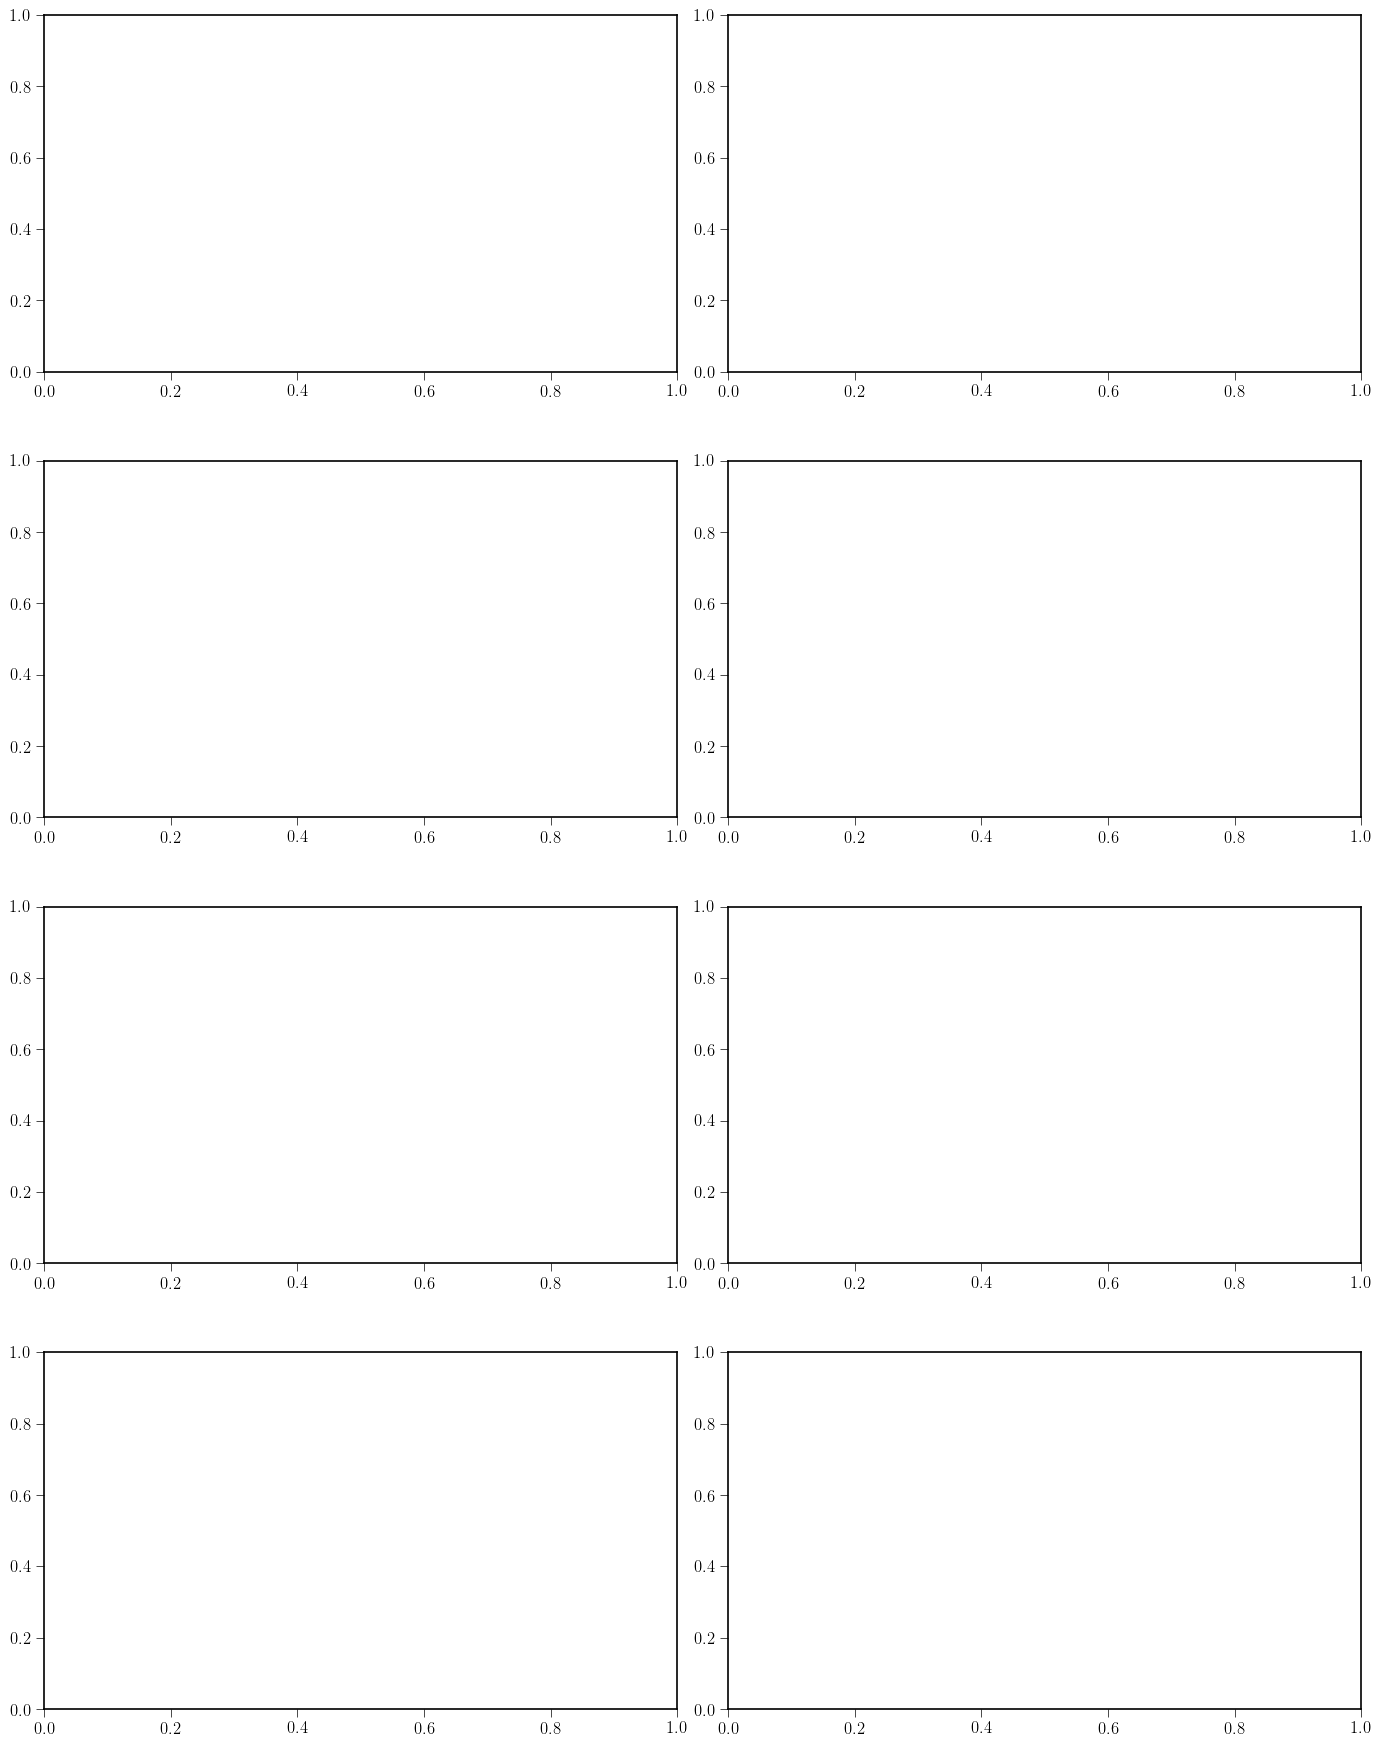

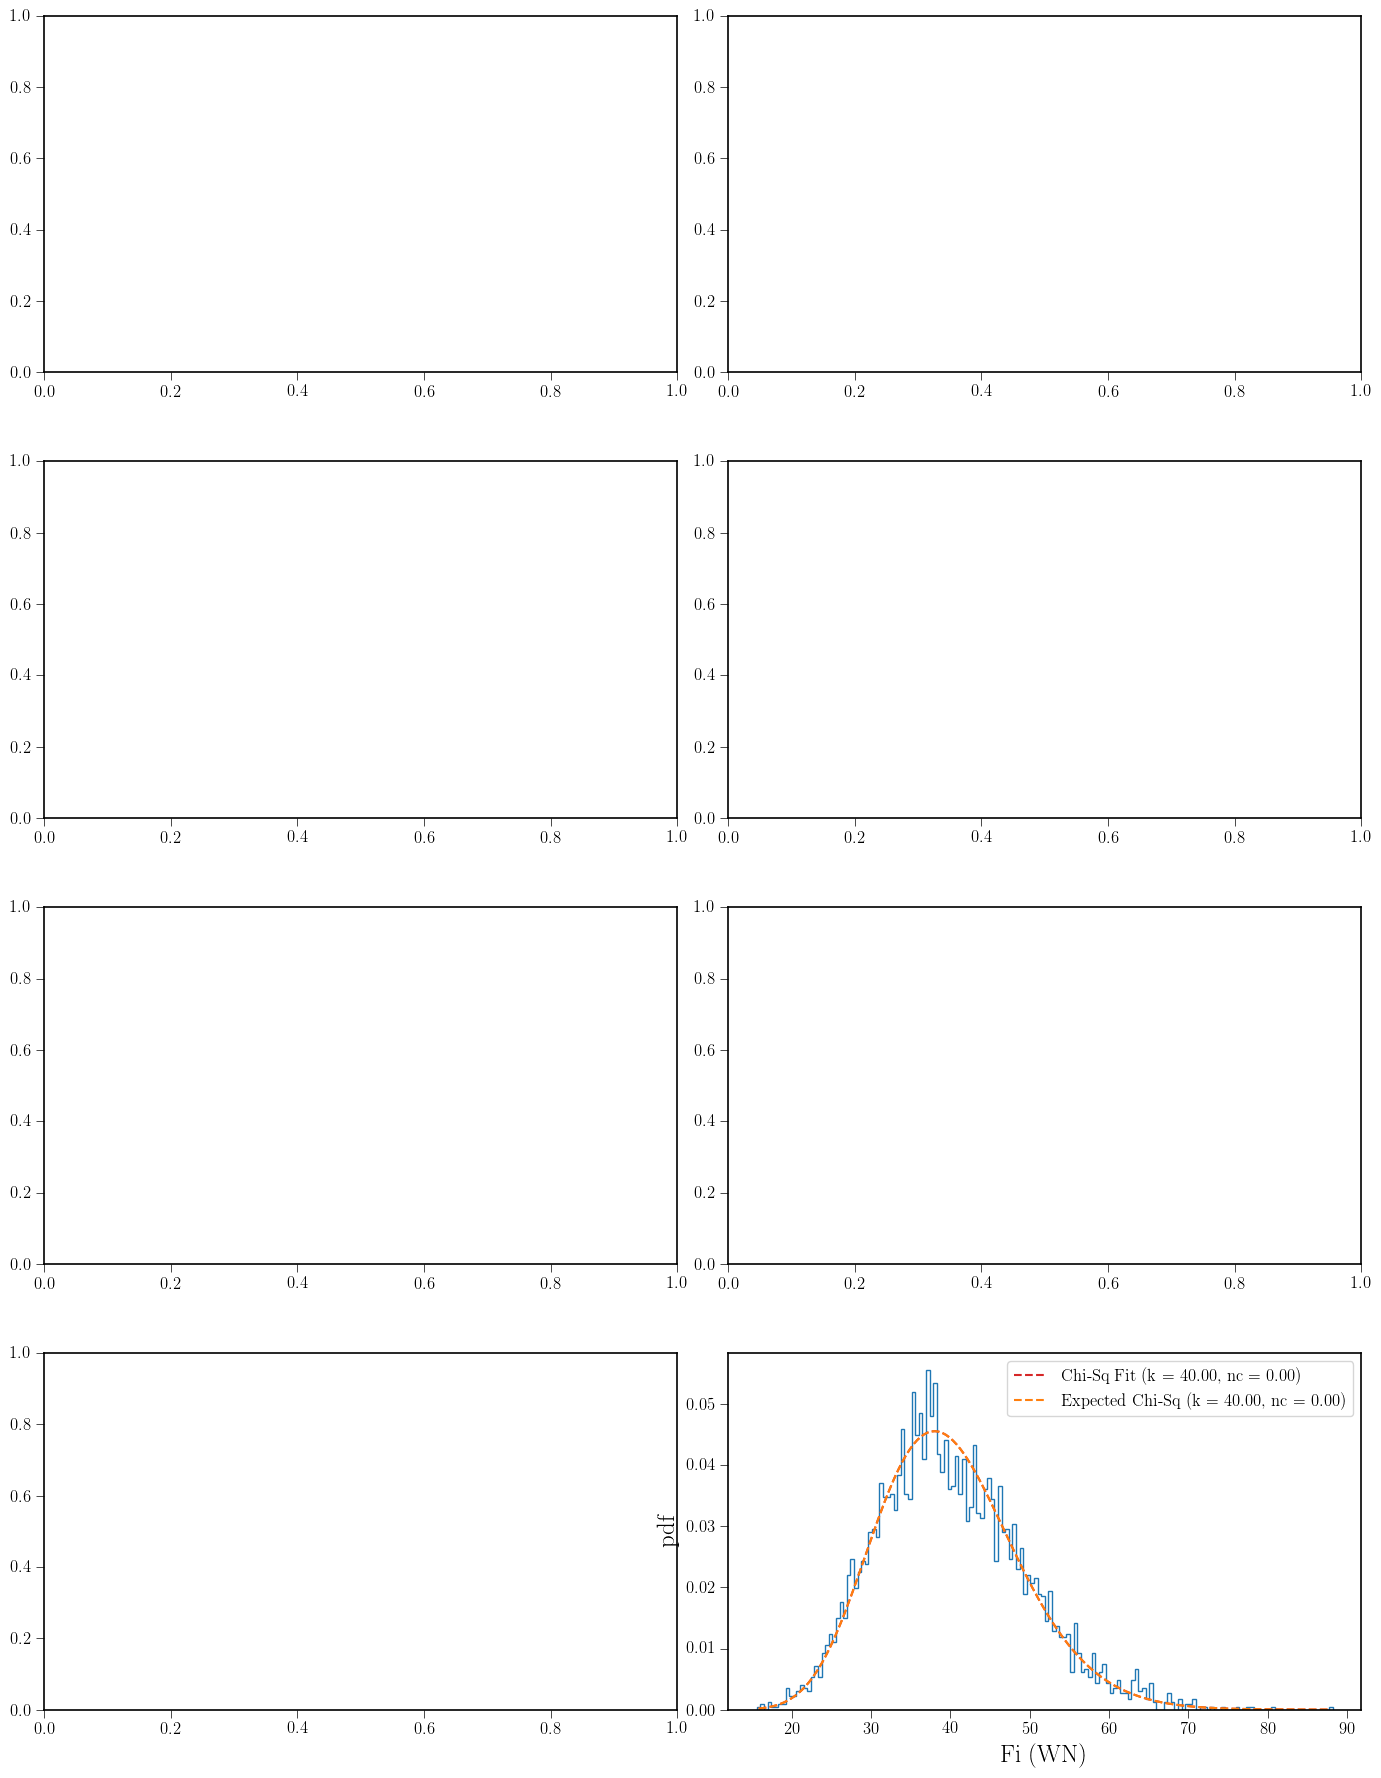

In [146]:
fi_wn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn.txt')
fi_wn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fi_wn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_midpts, fi_wn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fi_wn_opt_k = 40
fi_wn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_fitted = []
fi_wn_expected = []
for pt in fi_wn_midpts:
    fi_wn_fitted.append(nc_chisq_wrapper(pt, fi_wn_opt_k, fi_wn_opt_nc))
    fi_wn_expected.append(nc_chisq_wrapper(pt, fi_wn_opt_k, fi_wn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_midpts, fi_wn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_opt_k, fi_wn_opt_nc))
plt.plot(fi_wn_midpts, fi_wn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_opt_k, fi_wn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fi (WN)")
plt.ylabel("pdf")
plt.show()
plt.close()

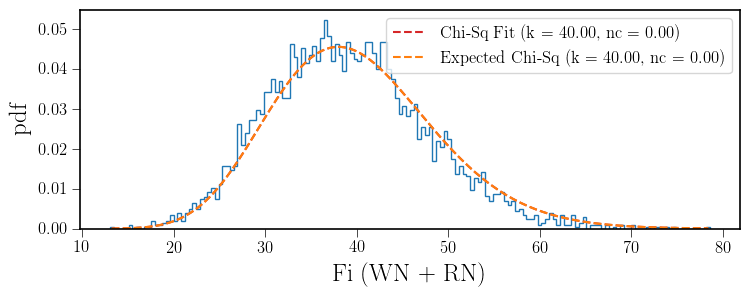

In [147]:
fi_wn_rn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn.txt')
fi_wn_rn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fi_wn_rn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_rn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_rn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_rn_midpts, fi_wn_rn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fi_wn_rn_opt_k = 40
fi_wn_rn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_rn_fitted = []
fi_wn_rn_expected = []
for pt in fi_wn_rn_midpts:
    fi_wn_rn_fitted.append(nc_chisq_wrapper(pt, fi_wn_rn_opt_k, fi_wn_rn_opt_nc))
    fi_wn_rn_expected.append(nc_chisq_wrapper(pt, fi_wn_rn_opt_k, fi_wn_rn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_rn_midpts, fi_wn_rn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_opt_k, fi_wn_rn_opt_nc))
plt.plot(fi_wn_rn_midpts, fi_wn_rn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_opt_k, fi_wn_rn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fi (WN + RN)")
plt.ylabel("pdf")
plt.show()
plt.close()

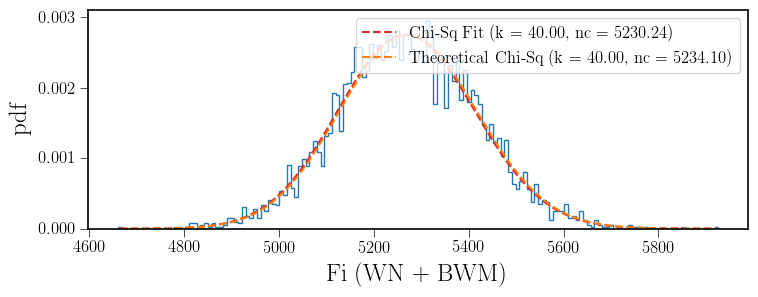

In [148]:
fi_wn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm.txt')
fi_wn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm_ncs.txt'))
ns, bins, patches = plt.hist(fi_wn_bwm_fps, histtype='step', bins=160, density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_bwm_midpts, fi_wn_bwm_counts, p0 = [5230],maxfev = 5000)


# opt_k = popt[0]
fi_wn_bwm_opt_k = 40
fi_wn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_bwm_fitted = []
fi_wn_bwm_expected = []
for pt in fi_wn_bwm_midpts:
    fi_wn_bwm_fitted.append(nc_chisq_wrapper(pt, fi_wn_bwm_opt_k, fi_wn_bwm_opt_nc))
    fi_wn_bwm_expected.append(nc_chisq_wrapper(pt, fi_wn_bwm_opt_k, fi_wn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_bwm_midpts, fi_wn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_bwm_opt_k, fi_wn_bwm_opt_nc))
plt.plot(fi_wn_bwm_midpts, fi_wn_bwm_expected, ls='--', color='tab:orange', label='Theoretical Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_bwm_opt_k, fi_wn_bwm_avg_nc))

plt.legend(loc='upper right')
plt.xlabel("Fi (WN + BWM)")
plt.ylabel("pdf")
plt.show()
plt.close()

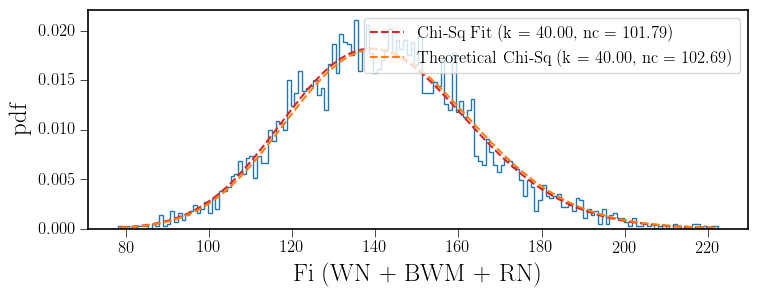

In [149]:
fi_wn_rn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm.txt')
fi_wn_rn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm_ncs.txt'))
ns, bins, patches = plt.hist(fi_wn_rn_bwm_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_rn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_rn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_counts, p0 = [120],maxfev = 5000)


# opt_k = popt[0]
fi_wn_rn_bwm_opt_k = 40
fi_wn_rn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_rn_bwm_fitted = []
fi_wn_rn_bwm_expected = []
for pt in fi_wn_rn_bwm_midpts:
    fi_wn_rn_bwm_fitted.append(nc_chisq_wrapper(pt, fi_wn_rn_bwm_opt_k, fi_wn_rn_bwm_opt_nc))
    fi_wn_rn_bwm_expected.append(nc_chisq_wrapper(pt, fi_wn_rn_bwm_opt_k, fi_wn_rn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_bwm_opt_k,fi_wn_rn_bwm_opt_nc))
plt.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_expected, ls='--', color='tab:orange', label='Theoretical Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_bwm_opt_k, fi_wn_rn_bwm_avg_nc))

plt.legend(loc='upper right')
plt.xlabel("Fi (WN + BWM + RN)")
plt.ylabel("pdf")
plt.show()
plt.close()

Fc

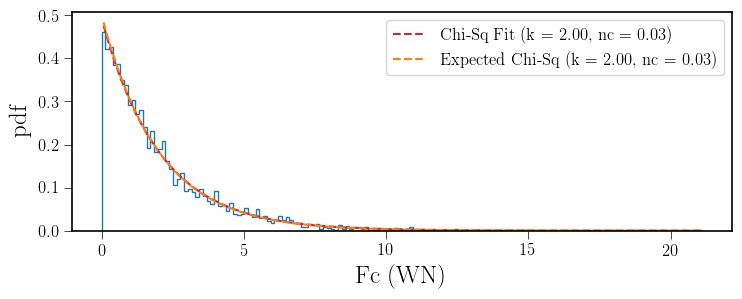

In [150]:
fc_wn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn.txt')
fc_wn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fc_wn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_midpts, fc_wn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_opt_k = 2
fc_wn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_fitted = []
fc_wn_expected = []
for pt in fc_wn_midpts:
    fc_wn_fitted.append(nc_chisq_wrapper(pt, fc_wn_opt_k, fc_wn_opt_nc))
    fc_wn_expected.append(nc_chisq_wrapper(pt, fc_wn_opt_k,fc_wn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_midpts, fc_wn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_opt_k, fc_wn_opt_nc))
plt.plot(fc_wn_midpts, fc_wn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_opt_k, fc_wn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN)")
plt.ylabel("pdf")
plt.show()
plt.close()

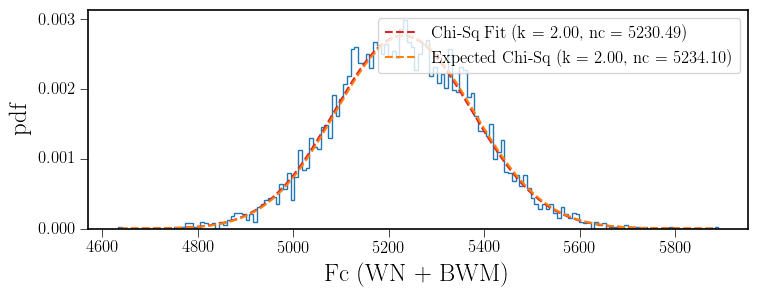

In [151]:
fc_wn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm.txt')
fc_wn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm_ncs.txt')) #noise only case
ns, bins, patches = plt.hist(fc_wn_bwm_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_bwm_midpts, fc_wn_bwm_counts, p0 = [5200],maxfev = 5000)


# opt_k = popt[0]
fc_wn_bwm_opt_k = 2
fc_wn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_bwm_fitted = []
fc_wn_bwm_expected = []
for pt in fc_wn_bwm_midpts:
    fc_wn_bwm_fitted.append(nc_chisq_wrapper(pt, fc_wn_bwm_opt_k, fc_wn_bwm_opt_nc))
    fc_wn_bwm_expected.append(nc_chisq_wrapper(pt, fc_wn_bwm_opt_k,fc_wn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_bwm_midpts, fc_wn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_bwm_opt_k, fc_wn_bwm_opt_nc))
plt.plot(fc_wn_bwm_midpts, fc_wn_bwm_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_bwm_opt_k, fc_wn_bwm_avg_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + BWM)")
plt.ylabel("pdf")
plt.show()
plt.close()

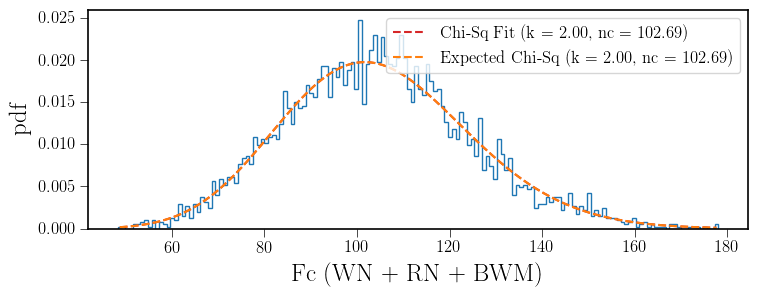

In [152]:
fc_wn_rn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm.txt')
fc_wn_rn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm_ncs.txt')) #noise only case
ns, bins, patches = plt.hist(fc_wn_rn_bwm_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_rn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_counts, p0 = [100],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_bwm_opt_k = 2
fc_wn_rn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_bwm_fitted = []
fc_wn_rn_bwm_expected = []
for pt in fc_wn_rn_bwm_midpts:
    fc_wn_rn_bwm_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_bwm_opt_k, fc_wn_rn_bwm_opt_nc))
    fc_wn_rn_bwm_expected.append(nc_chisq_wrapper(pt, fc_wn_rn_bwm_opt_k,fc_wn_rn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_bwm_opt_k, fc_wn_rn_bwm_opt_nc))
plt.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_bwm_opt_k, fc_wn_rn_bwm_avg_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN + BWM)")
plt.ylabel("pdf")
plt.show()
plt.close()

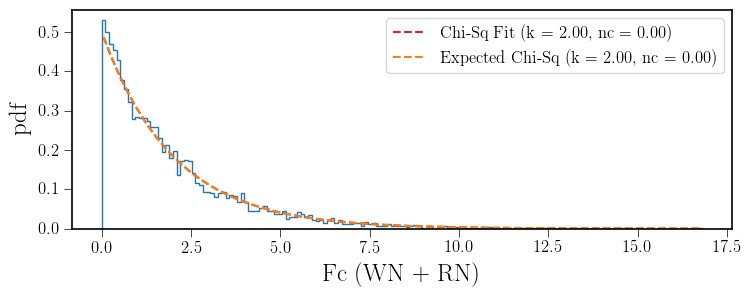

In [153]:
fc_wn_rn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn.txt')
fc_wn_rn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fc_wn_rn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_rn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_midpts, fc_wn_rn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_opt_k = 2
fc_wn_rn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_fitted = []
fc_wn_rn_expected = []
for pt in fc_wn_rn_midpts:
    fc_wn_rn_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
    fc_wn_rn_expected.append(nc_chisq_wrapper(pt, fc_wn_rn_opt_k, fc_wn_rn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_midpts, fc_wn_rn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
plt.plot(fc_wn_rn_midpts, fc_wn_rn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_avg_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN)")
plt.ylabel("pdf")
plt.show()
plt.close()

# Subplots

Let's combine all the above to make a disgusting gigaplot

/tmp/ipykernel_9765/2185014041.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.03)


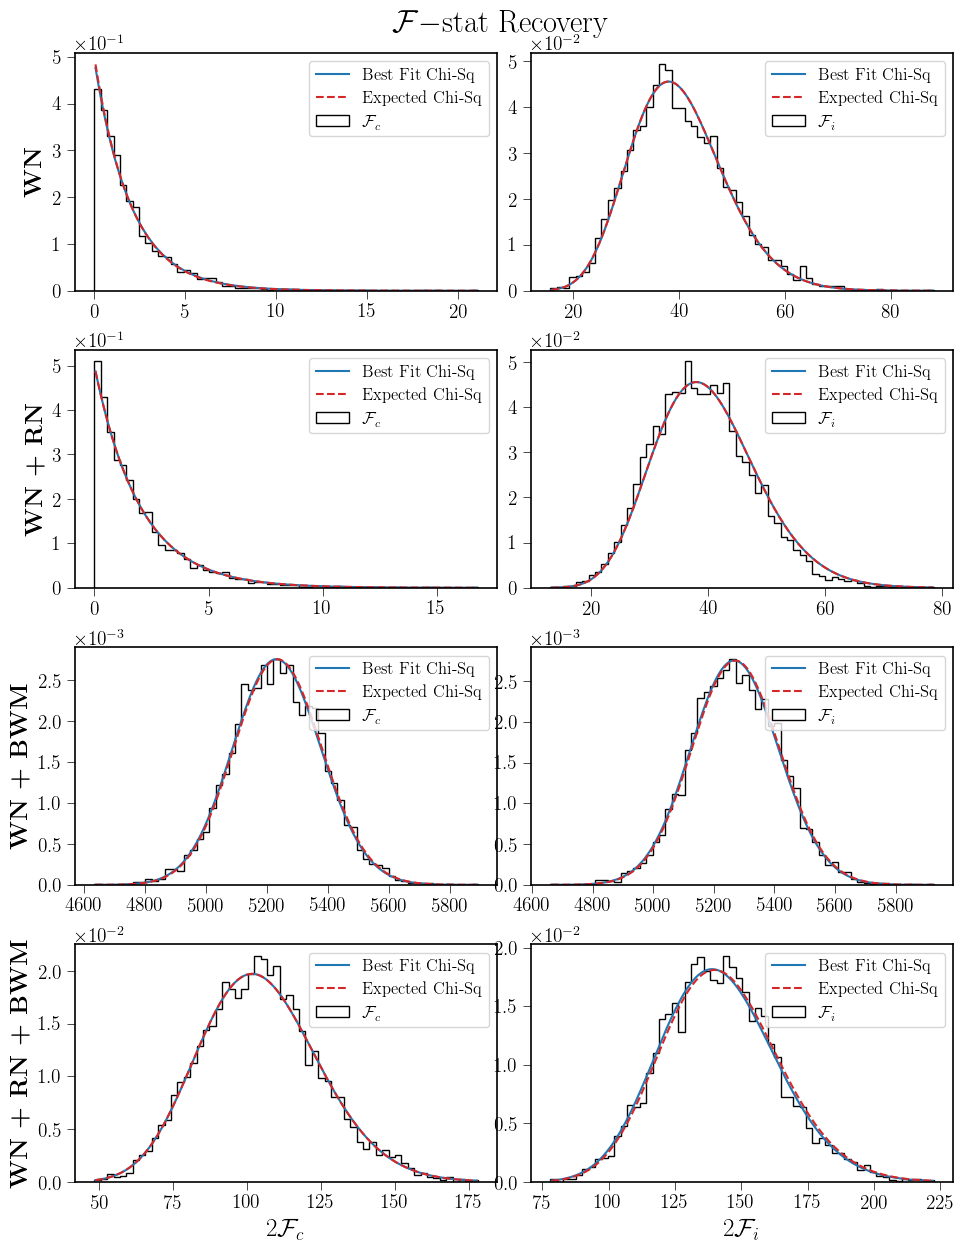

In [164]:
bigfig, bigaxs = plt.subplots(4, 2, figsize = (11.33,14.66), gridspec_kw = {'wspace':0.08, 'hspace':0.25})


# split axes up
fc_wn_ax = bigaxs[0,0]
fc_wn_rn_ax = bigaxs[1,0]
fc_wn_bwm_ax = bigaxs[2,0]
fc_wn_rn_bwm_ax = bigaxs[3,0]


fi_wn_ax = bigaxs[0,1]
fi_wn_rn_ax = bigaxs[1,1]
fi_wn_bwm_ax = bigaxs[2,1]
fi_wn_rn_bwm_ax = bigaxs[3,1]

# fc_plots
ns, bins, patches = fc_wn_ax.hist(fc_wn_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_ax.plot(fc_wn_midpts, fc_wn_fitted,  color='tab:blue',  label='Best Fit Chi-Sq')
fc_wn_ax.plot(fc_wn_midpts, fc_wn_expected, ls='--', color='tab:red',  label='Expected Chi-Sq')
fc_wn_ax.legend(loc='upper right', fontsize = 12)

ns, bins, patches = fc_wn_rn_ax.hist(fc_wn_rn_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_rn_ax.plot(fc_wn_rn_midpts, fc_wn_rn_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fc_wn_rn_ax.plot(fc_wn_rn_midpts, fc_wn_rn_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fc_wn_rn_ax.legend(loc='upper right', fontsize = 12)

ns, bins, patches = fc_wn_bwm_ax.hist(fc_wn_bwm_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_bwm_ax.plot(fc_wn_bwm_midpts, fc_wn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fc_wn_bwm_ax.plot(fc_wn_bwm_midpts, fc_wn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fc_wn_bwm_ax.legend(loc='upper right', fontsize = 12)


ns, bins, patches = fc_wn_rn_bwm_ax.hist(fc_wn_rn_bwm_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_rn_bwm_ax.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fc_wn_rn_bwm_ax.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fc_wn_rn_bwm_ax.legend(loc='upper right', fontsize = 12)


# fi_plots
fi_wn_ax.hist(fi_wn_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_ax.plot(fi_wn_midpts, fi_wn_fitted,  color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_ax.plot(fi_wn_midpts, fi_wn_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_ax.legend(loc='upper right', fontsize = 12)

fi_wn_rn_ax.hist(fi_wn_rn_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_rn_ax.plot(fi_wn_rn_midpts, fi_wn_rn_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_rn_ax.plot(fi_wn_rn_midpts, fi_wn_rn_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_rn_ax.legend(loc='upper right', fontsize = 12)

fi_wn_bwm_ax.hist(fi_wn_bwm_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_bwm_ax.plot(fi_wn_bwm_midpts, fi_wn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_bwm_ax.plot(fi_wn_bwm_midpts, fi_wn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_bwm_ax.legend(loc='upper right', fontsize = 12)

fi_wn_rn_bwm_ax.hist(fi_wn_rn_bwm_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_rn_bwm_ax.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_rn_bwm_ax.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_rn_bwm_ax.legend(loc='upper right', fontsize = 12)

#labels
fc_wn_rn_bwm_ax.set_xlabel(r'$2\pazocal{F}_c$', fontsize = 18)
fi_wn_rn_bwm_ax.set_xlabel(r'$2\pazocal{F}_i$', fontsize = 18)

fc_wn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fc_wn_rn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fc_wn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fc_wn_rn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fi_wn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fi_wn_rn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fi_wn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fi_wn_rn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fc_wn_ax.set_ylabel(r'\textbf{WN}', rotation='vertical', )
fc_wn_rn_ax.set_ylabel(r'\textbf{WN + RN}', rotation='vertical', )
fc_wn_bwm_ax.set_ylabel(r'\textbf{WN + BWM}', rotation='vertical', )
fc_wn_rn_bwm_ax.set_ylabel(r'\textbf{WN + RN + BWM}', rotation='vertical')

plt.suptitle("$\pazocal{F}-$stat Recovery",y = 0.91, fontsize=22)
plt.tight_layout(pad=1.03)
plt.savefig('/home/nima/nanograv/bwm_fpfe/fstat_recovery.pdf')
plt.show()
plt.close()

# Max Likely amplitude and polarization recovery
### Strong signal (log10_A = -13.5)

In [ ]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [ ]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [ ]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

In [ ]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_piby8_polarized_verbose.txt')

Using
$$\hat{h_0} = \sqrt{\hat{b}_{+}^2 + \hat{b}_{\times}^2}$$
$$\hat{\psi} = \tan^{-1}\left({\frac{\hat{b}_{\times}}{\hat{b}_{+}}}\right)$$

In [ ]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -13.5
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


In [ ]:
fig, axs = plt.subplots(1, 2)

# Strain recovery
strain_ax = axs[0]
strain_ax.hist(maxlike_strains, histtype='step', density=True)
strain_ax.set_xlabel(r"$\hat{h}_{0}$")
strain_ax.axvline(injected_strain, color='red', ls='--', label='Injected Strain')
strain_ax.legend()

pol_ax = axs[1]
pol_ax.hist(maxlike_pols, histtype='step', density=True)
pol_ax.set_xlabel(r"$\hat{\phi}$")
pol_ax.axvline(injected_pol, color='red', ls='--', label='Injected Polarization')
pol_ax.legend()

plt.suptitle("Parameter Recovery (WN + RN + BWM)", fontsize=16)
plt.show()

In [ ]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -13.50^{+0.06}_{-0.06} $', fontsize=16, y=1.02)
axs[3].set_title(r'$\hat{\psi} = 0.39^{+0.06}_{-0.07} $', fontsize=16, y=1.02)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery.pdf')
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

## Repeat with weaker injection
### Weak signal regime (log10h = -15)

In [ ]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -15
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [ ]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [ ]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

In [ ]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_piby8_polarized_verbose.txt')

In [ ]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -15
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


In [ ]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -14.32^{+0.22}_{-0.31} $', fontsize=16, y=1.02)
axs[3].set_title(r'$\hat{\psi} = 0.00^{+0.60}_{-0.62} $', fontsize=16, y=1.02)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery.pdf')
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

## Intermediate Signal

In [ ]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_phi = np.pi/8
log10_h = np.log10(3e-15)
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [ ]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [ ]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

In [ ]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_piby8_polarized_verbose.txt')

In [ ]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = np.log10(3e-15)
injected_pol = 0

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


In [ ]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -14.26^{+0.20}_{-0.29} $', fontsize=16, y=1.02)
axs[3].set_title(r'$\hat{\psi} = 0.00^{+0.55}_{-0.54} $', fontsize=16, y=1.02)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_intermediate.pdf')
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

## Intermediate-large Signal
### A = 7e-15

In [ ]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = np.log10(7e-15)
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [ ]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [ ]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interlargebwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interlargebwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

In [ ]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interlargebwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interlargebwm_piby8_polarized_verbose.txt')

In [ ]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = np.log10(7e-15)
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


In [ ]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -14.26^{+0.20}_{-0.29} $', fontsize=16, y=1.02)
axs[3].set_title(r'$\hat{\psi} = 0.00^{+0.55}_{-0.54} $', fontsize=16, y=1.02)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery.pdf')
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()